### convert jupyter to python file

In [157]:
#!jupyter nbconvert --to script 'jupyter_file_name.ipynb'

### import dependencies

In [340]:
# packages
import pandas as pd
import numpy as np
import sqlite3 as sql
from path import Path
import pandas_market_calendars as mcal
import time,requests,keyring
from datetime import datetime
from multiprocessing import Pool, cpu_count
#import yfinance as yf
import robin_stocks.robinhood as rh
import robin_stocks.tda as tda
import alpaca_trade_api as alpaca
from alpaca_trade_api.rest import TimeFrame
#import discord
# import backtrader as bt
import plotly.graph_objects as go # for candlestick charting
import matplotlib.pyplot as plt
import urllib.parse
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import MeanShift

# enables inline plots
%matplotlib inline
pd.set_option("display.precision", 5)
pd.set_option('display.max_columns', None)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)    

In [159]:
#!pip install robin_stocks

In [160]:
!python --version

Python 3.7.10


### alpaca api

In [161]:
paper_endpoint = 'https://paper-api.alpaca.markets'
live_endpoint = 'https://api.alpaca.markets' # dont use till confident!
data_feed = 'sip' # 'sip' for subscribers; 'iex' for free use

APCA_API_KEY_ID = 'PKIXPJJNRTUVSNIY1BAZ'
APCA_API_SECRET_KEY = 'iAvG9yYzOQIJDhg1B5NdU7twJ8dUpRgE81Tmy4xm'
APCA_API_BASE_URL=paper_endpoint
APCA_API_DATA_URL='https://data.alpaca.markets'

rest = alpaca.REST(key_id=APCA_API_KEY_ID,secret_key=APCA_API_SECRET_KEY,base_url=APCA_API_BASE_URL,api_version='v2') # alpaca rest api
stream = alpaca.Stream(key_id=APCA_API_KEY_ID,secret_key=APCA_API_SECRET_KEY,base_url=APCA_API_BASE_URL,data_feed=data_feed) # alpaca stream api (webhooks)

### formats seconds into seconds, minutes, hours, or days

In [162]:
def seconds_format(ts):
    tm = ts/60
    th = tm/60
    td = th/24
    if td > 1:
        return f'{round(td,1)}d'
    elif th > 1:
        return f'{round(th,1)}h'
    elif tm > 1:
        return f'{round(tm,1)}m'
    else:
        return f'{round(ts,1)}s'

In [163]:
seconds_format(10),seconds_format(1000),seconds_format(10000),seconds_format(100000)

('10s', '16.7m', '2.8h', '1.2d')

### data path

In [164]:
#Path('data/').mkdir()

In [165]:
# define data path and display contents
data_path = Path('data/')
[item.name for item in data_path.listdir()][:10]

[Path('buy_rules-v3.32.pickle'),
 Path('jpm_1m_20170101_20210903.pickle'),
 Path('aapl_5s_edit.csv'),
 Path('buy_rules-v3.51.pickle'),
 Path('buy_rules-v3.43.pickle'),
 Path('buy_rules-v3.0.pickle'),
 Path('unh_1m_20170101_20210903.pickle'),
 Path('v_1m_20170101_20210903.pickle'),
 Path('pypl_1m_20170101_20210903.pickle'),
 Path('jpm_1m_20190101_20211124.pickle')]

### results path

In [166]:
#Path('results/').mkdir()

In [167]:
# define stock folder path
results_path = Path('results/')
[item.name for item in results_path.listdir()][:10]

[Path('results_v1.73_V.csv'),
 Path('ssp_v3.31-fb-1629783876.pickle'),
 Path('ssp_v2.8-tjx-1628403459.pickle'),
 Path('results_v1.71_FB.csv'),
 Path('ssp_v2.9-allv4.xlsx'),
 Path('ssp_v3.22-matrix.xlsx'),
 Path('ssp_v3.49-tsla-1633431714.pickle'),
 Path('ssp_v2.8-spgi-1628403211.pickle'),
 Path('ssp_v2.5-dis-1627579044.pickle'),
 Path('ssp_v3.0-de-1628749431.pickle')]

### compress df to save memory
* converts int64 to in32
* converts float64 to float32

In [168]:
def compress_df(df,verbose=False):
    df = df.copy()
    
    if verbose:
        print(f'PRE-COMP SIZE: {round(df.memory_usage().sum()/(1024**2),2)} MB')
    
    for col in df.columns:
        if df[col].dtype == 'int':
            df[col] = df[col].astype('int32')
            
        if df[col].dtype == 'float':
            df[col] = df[col].astype('float32')
            
    if verbose:
        print(f'POST-COMP SIZE: {round(df.memory_usage().sum()/(1024**2),2)} MB')
    
    return df

### get s&p 500 list from wiki

In [169]:
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df_sp500 = data[0]
df_sp500.columns = df_sp500.columns.str.lower().str.replace(' ','_')
df_sp500 = df_sp500.rename(columns={'gics_sector':'sector','gics_sub-industry':'sub_sector'})
df_sp500 = df_sp500.loc[:,['symbol','security','sector','sub_sector']]
df_sp500.to_csv("data/sp500_list.csv")
df_sp500.head()

,symbol,security,sector,sub_sector
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Pharmaceuticals
4,ABMD,Abiomed,Health Care,Health Care Equipment


### get companies with largest market capitalization

In [170]:
def top_market_cap():
    r = requests.get('https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/')
    df_top = pd.read_html(r.text)[0]
    df_top = df_top.drop(['Price (30 days)','Country'],axis=1)
    df_top.columns = df_top.columns.str.lower().str.replace(' ','_')
    df_top.insert(2,'symbol',None)
    df_top.market_cap = df_top.market_cap.str.lstrip('$')
    df_top.price = df_top.price.str.lstrip('$').str.replace(',','').astype('float64')
    df_top['symbol'] = df_top.name.apply(lambda x: x.split()[-1].replace('-','.'))
    df_top.name = df_top.apply(lambda x: x['name'].rstrip(x['symbol']),axis=1)
    return df_top

In [171]:
df_top = top_market_cap()
df_top.head(20)

,rank,name,symbol,market_cap,price,today
0,1,Apple,AAPL,2.690 T,164.85,1.30%
1,2,Microsoft,MSFT,2.228 T,297.31,0.92%
2,3,Alphabet (Google),GOOG,1.778 T,2690.00,1.39%
3,4,Amazon,AMZN,1.565 T,3076.00,1.61%
4,5,Tesla,TSLA,837.00 B,809.87,1.14%
5,6,Berkshire Hathaway BRK-,BRK.A,713.98 B,479345.00,3.73%
6,7,NVIDIA,NVDA,601.99 B,241.57,1.72%
7,8,Meta (Facebook),FB,601.76 B,210.48,1.39%
8,9,Visa,V,471.88 B,219.27,0.91%
9,10,UnitedHealth,UNH,447.63 B,475.75,4.36%


### market status

In [172]:
def market_status():
    clock = rest.get_clock() # requires alpaca rest api to be called prior to running this funciton
    status = clock.is_open

    now = pd.Timestamp('now',tz='America/New_York')
    time_till_close,time_till_open = 0,0
    if status:
        time_till_close = (clock.next_close-clock.timestamp).total_seconds()
        #print(f'Markets are open; time_till_close: {seconds_format(time_till_close)}')
        print(f'[{now}] MARKET IS [OPEN] FOR {seconds_format(time_till_close)}')
        
    else:
        time_till_open = (clock.next_open-clock.timestamp).total_seconds()
        print(f'[{now}] MARKET IS [CLOSED] FOR {seconds_format(time_till_open)}')
        #time.sleep(time_till_open)

    return status,time_till_close,time_till_open

In [173]:
market_status()

[2022-02-26 20:51:24.992545-05:00] MARKET IS [CLOSED] FOR 1.5d


(False, 0, 131914.860337)

### build market index
* provides market index for regular trading hours between 9:30 to 16:00 each market day

In [174]:
def market_index(start_date,end_date=None,freq='1T'):
    # freq: 1T = 1 min, 5T = 5 min, 15T = 15 min, 1H = 1 hr, 1d = 1 day
    nyse = mcal.get_calendar('NYSE')
    if end_date == None:
#         end_date = pd.Timestamp('today').date()
        end_date = pd.Timestamp('now',tz='America/New_York').floor('1min')
#     else:
#         end_date = 

    market_schedule = nyse.schedule(start_date=start_date, end_date=end_date)
    date_index = mcal.date_range(market_schedule, frequency=freq,name='date',closed='left').tz_convert('America/New_York')

    date_index = date_index[date_index <= end_date]
    date_index = date_index[date_index >= start_date]
    
    return date_index

In [175]:
market_index(start_date='2021-07-01')

DatetimeIndex(['2021-07-01 09:30:00-04:00', '2021-07-01 09:31:00-04:00',
               '2021-07-01 09:32:00-04:00', '2021-07-01 09:33:00-04:00',
               '2021-07-01 09:34:00-04:00', '2021-07-01 09:35:00-04:00',
               '2021-07-01 09:36:00-04:00', '2021-07-01 09:37:00-04:00',
               '2021-07-01 09:38:00-04:00', '2021-07-01 09:39:00-04:00',
               ...
               '2022-02-25 15:51:00-05:00', '2022-02-25 15:52:00-05:00',
               '2022-02-25 15:53:00-05:00', '2022-02-25 15:54:00-05:00',
               '2022-02-25 15:55:00-05:00', '2022-02-25 15:56:00-05:00',
               '2022-02-25 15:57:00-05:00', '2022-02-25 15:58:00-05:00',
               '2022-02-25 15:59:00-05:00', '2022-02-25 16:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', length=64726, freq=None)

In [176]:
market_index('2021-07-01','2021-09-22')

DatetimeIndex(['2021-07-01 09:30:00-04:00', '2021-07-01 09:31:00-04:00',
               '2021-07-01 09:32:00-04:00', '2021-07-01 09:33:00-04:00',
               '2021-07-01 09:34:00-04:00', '2021-07-01 09:35:00-04:00',
               '2021-07-01 09:36:00-04:00', '2021-07-01 09:37:00-04:00',
               '2021-07-01 09:38:00-04:00', '2021-07-01 09:39:00-04:00',
               ...
               '2021-09-21 15:51:00-04:00', '2021-09-21 15:52:00-04:00',
               '2021-09-21 15:53:00-04:00', '2021-09-21 15:54:00-04:00',
               '2021-09-21 15:55:00-04:00', '2021-09-21 15:56:00-04:00',
               '2021-09-21 15:57:00-04:00', '2021-09-21 15:58:00-04:00',
               '2021-09-21 15:59:00-04:00', '2021-09-21 16:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', length=22287, freq=None)

In [177]:
market_index('2021-07-01 9:35','2021-09-22 12:00')

DatetimeIndex(['2021-07-01 09:35:00-04:00', '2021-07-01 09:36:00-04:00',
               '2021-07-01 09:37:00-04:00', '2021-07-01 09:38:00-04:00',
               '2021-07-01 09:39:00-04:00', '2021-07-01 09:40:00-04:00',
               '2021-07-01 09:41:00-04:00', '2021-07-01 09:42:00-04:00',
               '2021-07-01 09:43:00-04:00', '2021-07-01 09:44:00-04:00',
               ...
               '2021-09-22 11:51:00-04:00', '2021-09-22 11:52:00-04:00',
               '2021-09-22 11:53:00-04:00', '2021-09-22 11:54:00-04:00',
               '2021-09-22 11:55:00-04:00', '2021-09-22 11:56:00-04:00',
               '2021-09-22 11:57:00-04:00', '2021-09-22 11:58:00-04:00',
               '2021-09-22 11:59:00-04:00', '2021-09-22 12:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', length=22433, freq=None)

### function: basic adjust -- calculates price change and adjusted prices
* provides dividend and split adjustments to OHLC data using yahoo finance data

In [178]:
def basic_adjust(symbol,df,split_adjust=False,div_adjust=False,verbose=True):
    start_timestamp = int(df.index.min().timestamp()) # timestamp in seconds
    end_timestamp = int(df.index.max().timestamp()) # timestamp in seconds
    tz = 'America/New_York'
    
    df = df.copy()

    yahoo_url_div = f'https://query1.finance.yahoo.com/v7/finance/download/{symbol}?period1={start_timestamp}&period2={end_timestamp}&interval=1d&events=div'
    yahoo_url_split = f'https://query1.finance.yahoo.com/v7/finance/download/{symbol}?period1={start_timestamp}&period2={end_timestamp}&interval=1d&events=split'
    
    if verbose:
        print(f'-- SPLIT_ADJUST: {split_adjust}, DIV_ADJUST: {div_adjust}')
    
    if split_adjust or div_adjust:
        df['split_ratio'] = 1
        df['div_ratio'] = 1
        df['adj_ratio'] = 1
        
    # pulls splits and adjusts price accordingly
    if split_adjust:
        split_check = 0
        while split_check == 0:
            try:
                df_split = pd.read_csv(yahoo_url_split)
                df_split.columns = df_split.columns.str.lower().str.replace(' ','_')
                df_split = df_split.sort_values('date').reset_index(drop=True)
                split_check = 1
            except:
                print(f'Error while pulling yahoo split data for {symbol}; will try again in 10 secs')
                time.sleep(10)

        # calculate split ratios
        for idx,row in df_split.iterrows():
            date = row['date']
            split_factor = 1/int(row['stock_splits'].split(':')[0])
            if verbose:
                print(f'split adjustment -- date: {date}, split_factor: {split_factor}')

            df.loc[df.index < date,'split_ratio'] = df.loc[df.index < date,'split_ratio'] * split_factor

    # pulls dividends and adjusts price accordingly
    if div_adjust:
        div_check = 0
        while div_check == 0:
            try:
                df_div = pd.read_csv(yahoo_url_div)
                df_div.columns = df_div.columns.str.lower().str.replace(' ','_')
                df_div.date = pd.to_datetime(df_div.date)
                df_div = df_div.sort_values('date').reset_index(drop=True)
                div_check = 1
            except:
                print(f'Error while pulling yahoo div data for {symbol}; will try again in 10 secs')
                time.sleep(10)

        # calculate div ratios
        for idx,row in df_div[df_div.date >= df.index.min()].iterrows():            
            date = row['date']
            if df.loc[df.index < date,'close'].shape[0] > 0:
                prev_day_close = df.loc[df.index < date,'close'].values[-1]
                div_factor = 1-(float(row['dividends'])/prev_day_close)
                df.loc[df.index < date,'div_ratio'] = df.loc[df.index < date,'div_ratio'] * div_factor
                
                if verbose:
                    print(f'dividend adjustment -- date: {date}, dividend: {row["dividends"]}, previous day close: {prev_day_close}, div_factor: {div_factor}')
        
    if split_adjust or div_adjust:
        df['adj_ratio'] = df.split_ratio*df.div_ratio
        for col in ['open','high','low','close']:
            df[f'adj_{col}'] = df[col]*df['adj_ratio']
        df['pct_chg'] = df.adj_close.pct_change()
        df['pct_chg_log'] = df.adj_close.apply(np.log).diff()
    else:
        df.insert(5,'pct_chg',0)
        #df.column[5] = 'pct_chg'
        df['pct_chg'] = df.close.pct_change()
        df['pct_chg_log'] = df.close.apply(np.log).diff()

    return df

### alpaca api info

In [179]:
paper_endpoint = 'https://paper-api.alpaca.markets'
live_endpoint = 'https://api.alpaca.markets' # dont use till confident!
data_feed = 'sip' # 'sip' for subscribers; 'iex' for free use

APCA_API_KEY_ID = 'PKIXPJJNRTUVSNIY1BAZ'
APCA_API_SECRET_KEY = 'iAvG9yYzOQIJDhg1B5NdU7twJ8dUpRgE81Tmy4xm'
APCA_API_BASE_URL=paper_endpoint
APCA_API_DATA_URL=f'https://data.alpaca.markets/v1beta1/crypto/btcusd/bars'
#'/v1beta1/crypto/{symbol}/bars'
rest = alpaca.REST(key_id=APCA_API_KEY_ID,secret_key=APCA_API_SECRET_KEY,base_url=APCA_API_BASE_URL,api_version='crypto')

In [180]:
# start_date = '2021-12-01'
# end_date = '2022-01-11'
# rest.get_bars('btc',TimeFrame.Minute,start=start_date,end=end_date)

## function: get crypto data via Alpaca [wip]
* wasn't able to get this function working; need to revisit alpaca api for crypto

In [181]:
def crypto_alpaca(symbol='btc', months_of_data=None, start_date=None, end_date=None, split_adjust=True,div_adjust=True,resample_interval=None,verbose=True):
    # start_date: YYYY-MM-DD format
    # minute intervals: 5, 10, 15, 30 min or m
    # hour intervals: 1 hour or h
    if (months_of_data == None) and (start_date == None):
        print('ERROR: "months_of_data" or "start_date" NEEDS TO BE DEFINED')
        return
    elif (months_of_data != None) and (start_date != None):
        print('ERROR: "months_of_data" AND "start_date" ARGUMENTS PROVIDED')
        return
    
    # essential variables
    t0 = time.time()
    symbol = symbol.replace('-','.')

    # api info
    paper_endpoint = 'https://paper-api.alpaca.markets'
    live_endpoint = 'https://api.alpaca.markets' # dont use till confident!
    data_feed = 'sip' # 'sip' for subscribers; 'iex' for free use

    APCA_API_KEY_ID = 'PKIXPJJNRTUVSNIY1BAZ'
    APCA_API_SECRET_KEY = 'iAvG9yYzOQIJDhg1B5NdU7twJ8dUpRgE81Tmy4xm'
    APCA_API_BASE_URL=paper_endpoint
    APCA_API_DATA_URL='https://data.alpaca.markets/v1beta1/crypto'
    rest = alpaca.REST(key_id=APCA_API_KEY_ID,secret_key=APCA_API_SECRET_KEY,base_url=APCA_API_BASE_URL,api_version='v2')

    # common params
    #today = datetime.now().strftime('%Y-%m-%d')
    price_cols = ['open','high','low','close']
    date_fmt = '%Y-%m-%d %H:%M'
    tz = 'America/New_York'
    
    # determine start_date
    if months_of_data != None:
#         start_date = (pd.Timestamp('now',tz=tz) - pd.DateOffset(months=months_of_data)).date() # set start date relative to end date
        start_date = (pd.Timestamp('now',tz=tz) - pd.DateOffset(months=months_of_data)).floor('1min').isoformat() # set start date relative to end date
    else:
        start_date = pd.Timestamp(start_date,tz=tz).floor('1min').isoformat() # set start date relative to end date
        
#         if (start_date.hour == 0) and (start_date.minute == 0):
#             start_date = start_date.date()
        
    # determine end_date
    if end_date == None:
        end_date = pd.Timestamp('now',tz=tz).floor('1min').isoformat()
    else:
        end_date = pd.Timestamp(end_date,tz=tz).floor('1min').isoformat()

    # if end_date value is before start_date, return error
    if end_date < start_date:
        print(f'date range conflict -- start_date: {start_date}, end_date: {end_date}')
        return
    
    if verbose:
        # print(f'-- PULLING 1MIN INTRADAY DATA FOR {symbol.upper()} BETWEEN {start_date} AND {end_date}; SPLIT_ADJUST: {split_adjust}, DIV_ADJUST: {div_adjust}',end='')
        print(f'-- DATA PULL - SYMBOL: {symbol.upper()}, INTERVAL: 1MIN, START: {start_date}, END: {end_date}; SPLIT_ADJUST: {split_adjust}, DIV_ADJUST: {div_adjust}',end='')
    
    #api_url = f'https://api.tiingo.com/iex/{symbol}/prices?' #  # https://api.tiingo.com/documentation/iex
    #cols = 'date,open,high,low,close,volume'
    
#     start_date = start_date.strftime(date_fmt)
#     end_date = end_date.strftime(date_fmt)
    #min_date = end_date # set min_date to desired end_date
    #df_list = [] # create list of dfs and concat later
    #end_date_list = []
    #response_count = 0
    
    if split_adjust == True and div_adjust == True:
        adjust_factor = 'all'
    elif split_adjust == True and div_adjust == False:
        adjust_factor = 'split'
    elif split_adjust == False and div_adjust == True:
        adjust_factor = 'dividend'
    else:
        adjust_factor = 'raw'

#     print(start_date,end_date)
#     print(type(start_date),type(end_date))
    df = rest.get_bars(symbol,TimeFrame.Minute,start=start_date,end=end_date,adjustment=adjust_factor).df
#     df.index = df.index.tz_convert(tz)
#     df = df.between_time('09:30','16:00')
    
    #return df
    
    # convert date to datetime
    #df.date = pd.to_datetime(df.date) # convert date to datetime

    # clean data of any duplicate dates
    #df = df[~df.date.duplicated()].reset_index(drop=True) # drop any duplicated rows
    
    # monitor duplicates
    #date_duplicates = df.index.duplicated().sum() # get duplicate count after cleaning data
    price_duplicates = df.duplicated(price_cols).sum() # get duplicate count after cleaning data
    volume_zero_count = (df.volume == 0).sum()
    
    #df = df.set_index('date') # set date as index    
    #df = df.sort_index() # sort from oldest to newest aka ascending
    #df = basic_adjust(symbol,df,split_adjust=False,div_adjust=False,verbose=verbose) # get adjusted stock prices
    
    
    # resample data down from 1 minute to 5 min, 15 min, 1 hr, 1 day, etc.
    if resample_interval:
        interval_value = int(''.join([val for val in resample_interval if val.isdigit()]))

        # clean up interval date
        if 'm' in resample_interval:
            interval = str(interval_value) + 'min'
        elif 'h' in resample_interval:
            interval = str(interval_value) + 'hour'
        elif 'd' in resample_interval:
            interval = str(interval_value) + 'day'
        
        df = resample_data(df,interval)

    # reindex data to market hours
    df = df.reindex(index=market_index(start_date,end_date))
    df.insert(0,'na',0)
    df['na'] = df.close.isna() * 1
    price_na = df.na.sum()
    df = df.fillna(method='ffill')
    df.index.rename('timestamp',inplace=True)
    
    # apply log price changes 
    #df['pct_chg'] = df.adj_close.pct_change()
    df['pct_chg_log'] = df['close'].apply(np.log).diff()
    df['pct_chg_log_vwap'] = df['vwap'].apply(np.log).diff()
    
    # stock data stats
    n = df.shape[0]
    min_date = df.index.min()
    max_date = df.index.max()
    
#     # save memory
#     for col in df.columns:
#         if col == 'volume':
#             df[col] = df[col].astype('int32')
            
#         if col == 'trade_count':
#             df[col] = df[col].astype('int32')
        
#         if df[col].dtype == 'int64':
#             df[col] = df[col].astype('int32')

#         if df[col].dtype == 'float64':
#             df[col] = df[col].astype('float32')
    
    # save memory
    #df = compress_df(df)
    
    if verbose:
        # print stock data stats
        #print('-- REPORT: ',end='')
        print(f' [{seconds_format(time.time()-t0)}]')
        print(f'n: {n}, price_na: {price_na} ({round(100*price_na/n,1)}%), price_duplicates: {price_duplicates} ({round(100*price_duplicates/n,1)}%), min_date: {min_date}, max_date: {max_date}')
    
#     # pull daily stock data to determine split_ratio for intraday data
#     if adjust_price:
#         df_daily = stock_daily(symbol=symbol,start_date=min_date)
        
#         for idx in df_daily.index:
#             date = idx
#             split_ratio = df_daily.loc[idx,'split_ratio']

#             df.loc[(df.index >= date) & (df.index < (date + pd.DateOffset(days=1))),'split_ratio'] = split_ratio

    return df # return intraday stock data with no na's

In [182]:
# crypto_alpaca('BTCUSD',1)

## function: get market/stock data via Alpaca -- pulls 1M intraday OHLC data
* requires either months_of_data or start_date value
* if end_date is not specified, data is pulled to current market day
* can resample 1M data to 5M, 10M, 15M, 30M, 1H, 1D intervals (reaggregates OHLC data for each time period)

In [183]:
def stock_alpaca(symbol='aapl', months_of_data=None, start_date=None, end_date=None, split_adjust=True,div_adjust=True,resample_interval=None,verbose=True):
    # start_date: YYYY-MM-DD format
    # minute intervals: 5, 10, 15, 30 min or m
    # hour intervals: 1 hour or h
    if (months_of_data == None) and (start_date == None):
        print('ERROR: "months_of_data" or "start_date" NEEDS TO BE DEFINED')
        return
    elif (months_of_data != None) and (start_date != None):
        print('ERROR: "months_of_data" AND "start_date" ARGUMENTS PROVIDED')
        return
    
    # essential variables
    t0 = time.time()
    symbol = symbol.replace('-','.')

    # api info
    paper_endpoint = 'https://paper-api.alpaca.markets'
    live_endpoint = 'https://api.alpaca.markets' # dont use till confident!
    data_feed = 'sip' # 'sip' for subscribers; 'iex' for free use

    APCA_API_KEY_ID = 'PKIXPJJNRTUVSNIY1BAZ'
    APCA_API_SECRET_KEY = 'iAvG9yYzOQIJDhg1B5NdU7twJ8dUpRgE81Tmy4xm'
    APCA_API_BASE_URL=paper_endpoint
    APCA_API_DATA_URL='https://data.alpaca.markets'
    rest = alpaca.REST(key_id=APCA_API_KEY_ID,secret_key=APCA_API_SECRET_KEY,base_url=APCA_API_BASE_URL,api_version='v2')

    # common params
    #today = datetime.now().strftime('%Y-%m-%d')
    price_cols = ['open','high','low','close']
    date_fmt = '%Y-%m-%d %H:%M'
    tz = 'America/New_York'
    
    # determine start_date
    if months_of_data != None:
#         start_date = (pd.Timestamp('now',tz=tz) - pd.DateOffset(months=months_of_data)).date() # set start date relative to end date
        start_date = (pd.Timestamp('now',tz=tz) - pd.DateOffset(months=months_of_data)).floor('1min').isoformat() # set start date relative to end date
    else:
        start_date = pd.Timestamp(start_date,tz=tz).floor('1min').isoformat() # set start date relative to end date
        
#         if (start_date.hour == 0) and (start_date.minute == 0):
#             start_date = start_date.date()
        
    # determine end_date
    if end_date == None:
        end_date = pd.Timestamp('now',tz=tz).floor('1min').isoformat()
    else:
        end_date = pd.Timestamp(end_date,tz=tz).floor('1min').isoformat()

    # if end_date value is before start_date, return error
    if end_date < start_date:
        print(f'date range conflict -- start_date: {start_date}, end_date: {end_date}')
        return
    
    if verbose:
        # print(f'-- PULLING 1MIN INTRADAY DATA FOR {symbol.upper()} BETWEEN {start_date} AND {end_date}; SPLIT_ADJUST: {split_adjust}, DIV_ADJUST: {div_adjust}',end='')
        print(f'-- DATA PULL - SYMBOL: {symbol.upper()}, INTERVAL: 1MIN, START: {start_date}, END: {end_date}; SPLIT_ADJUST: {split_adjust}, DIV_ADJUST: {div_adjust}',end='')
    
    #api_url = f'https://api.tiingo.com/iex/{symbol}/prices?' #  # https://api.tiingo.com/documentation/iex
    #cols = 'date,open,high,low,close,volume'
    
#     start_date = start_date.strftime(date_fmt)
#     end_date = end_date.strftime(date_fmt)
    #min_date = end_date # set min_date to desired end_date
    #df_list = [] # create list of dfs and concat later
    #end_date_list = []
    #response_count = 0
    
    if split_adjust == True and div_adjust == True:
        adjust_factor = 'all'
    elif split_adjust == True and div_adjust == False:
        adjust_factor = 'split'
    elif split_adjust == False and div_adjust == True:
        adjust_factor = 'dividend'
    else:
        adjust_factor = 'raw'

#     print(start_date,end_date)
#     print(type(start_date),type(end_date))
    df = rest.get_bars(symbol,TimeFrame.Minute,start=start_date,end=end_date,adjustment=adjust_factor).df
#     df.index = df.index.tz_convert(tz)
#     df = df.between_time('09:30','16:00')
    
    #return df
    
    # convert date to datetime
    #df.date = pd.to_datetime(df.date) # convert date to datetime

    # clean data of any duplicate dates
    #df = df[~df.date.duplicated()].reset_index(drop=True) # drop any duplicated rows
    
    # monitor duplicates
    #date_duplicates = df.index.duplicated().sum() # get duplicate count after cleaning data
    price_duplicates = df.duplicated(price_cols).sum() # get duplicate count after cleaning data
    volume_zero_count = (df.volume == 0).sum()
    
    #df = df.set_index('date') # set date as index    
    #df = df.sort_index() # sort from oldest to newest aka ascending
    #df = basic_adjust(symbol,df,split_adjust=False,div_adjust=False,verbose=verbose) # get adjusted stock prices
    
    
    # resample data down from 1 minute to 5 min, 15 min, 1 hr, 1 day, etc.
    if resample_interval:
        interval_value = int(''.join([val for val in resample_interval if val.isdigit()]))

        # clean up interval date
        if 'm' in resample_interval:
            interval = str(interval_value) + 'min'
        elif 'h' in resample_interval:
            interval = str(interval_value) + 'hour'
        elif 'd' in resample_interval:
            interval = str(interval_value) + 'day'
        
        df = resample_data(df,interval)

    # reindex data to market hours
    df = df.reindex(index=market_index(start_date,end_date))
    df.insert(0,'na',0)
    df['na'] = df.close.isna() * 1
    price_na = df.na.sum()
    df = df.fillna(method='ffill')
    df.index.rename('timestamp',inplace=True)
    
    # apply log price changes 
    #df['pct_chg'] = df.adj_close.pct_change()
    df['pct_chg_log'] = df['close'].apply(np.log).diff()
    df['pct_chg_log_vwap'] = df['vwap'].apply(np.log).diff()
    
    # stock data stats
    n = df.shape[0]
    min_date = df.index.min()
    max_date = df.index.max()
    
#     # save memory
#     for col in df.columns:
#         if col == 'volume':
#             df[col] = df[col].astype('int32')
            
#         if col == 'trade_count':
#             df[col] = df[col].astype('int32')
        
#         if df[col].dtype == 'int64':
#             df[col] = df[col].astype('int32')

#         if df[col].dtype == 'float64':
#             df[col] = df[col].astype('float32')
    
    # save memory
    #df = compress_df(df)
    
    if verbose:
        # print stock data stats
        #print('-- REPORT: ',end='')
        print(f' [{seconds_format(time.time()-t0)}]')
        print(f'n: {n}, price_na: {price_na} ({round(100*price_na/n,1)}%), price_duplicates: {price_duplicates} ({round(100*price_duplicates/n,1)}%), min_date: {min_date}, max_date: {max_date}')
    
#     # pull daily stock data to determine split_ratio for intraday data
#     if adjust_price:
#         df_daily = stock_daily(symbol=symbol,start_date=min_date)
        
#         for idx in df_daily.index:
#             date = idx
#             split_ratio = df_daily.loc[idx,'split_ratio']

#             df.loc[(df.index >= date) & (df.index < (date + pd.DateOffset(days=1))),'split_ratio'] = split_ratio

    return df # return intraday stock data with no na's

In [184]:
df_aapl = stock_alpaca('aapl',months_of_data=6)
df_aapl

-- DATA PULL - SYMBOL: AAPL, INTERVAL: 1MIN, START: 2021-08-26T20:51:00-04:00, END: 2022-02-26T20:51:00-05:00; SPLIT_ADJUST: True, DIV_ADJUST: True [16.4s]
n: 49086, price_na: 15 (0.0%), price_duplicates: 14666 (29.9%), min_date: 2021-08-27 09:30:00-04:00, max_date: 2022-02-25 16:00:00-05:00


,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap
timestamp,,,,,,,,,,
2021-08-27 09:30:00-04:00,0,147.05820,147.24449,146.63934,147.22773,1059178.0,5360.0,146.95777,NaN,NaN
2021-08-27 09:31:00-04:00,0,147.21776,147.33743,147.09809,147.12790,316238.0,2800.0,147.23932,-0.00068,0.00191
2021-08-27 09:32:00-04:00,0,147.11803,147.46708,146.98838,147.26762,299887.0,2314.0,147.30453,0.00095,0.00044
2021-08-27 09:33:00-04:00,0,147.27759,147.27759,147.07814,147.09809,222329.0,2000.0,147.16533,-0.00115,-0.00095
2021-08-27 09:34:00-04:00,0,147.08821,147.09709,146.81386,147.01840,294671.0,2468.0,146.97179,-0.00054,-0.00132
...,...,...,...,...,...,...,...,...,...,...
2022-02-25 15:56:00-05:00,0,164.87110,164.91000,164.76000,164.82500,303116.0,2726.0,164.83671,-0.00027,0.00005
2022-02-25 15:57:00-05:00,0,164.84000,164.84000,164.65000,164.78000,393515.0,3313.0,164.74379,-0.00027,-0.00056
2022-02-25 15:58:00-05:00,0,164.79000,164.85000,164.75000,164.83000,528911.0,4180.0,164.80739,0.00030,0.00039


In [185]:
df_spy = stock_alpaca('spy',months_of_data=6)
df_spy

-- DATA PULL - SYMBOL: SPY, INTERVAL: 1MIN, START: 2021-08-26T20:51:00-04:00, END: 2022-02-26T20:51:00-05:00; SPLIT_ADJUST: True, DIV_ADJUST: True [16.3s]
n: 49086, price_na: 45 (0.1%), price_duplicates: 10122 (20.6%), min_date: 2021-08-27 09:30:00-04:00, max_date: 2022-02-25 16:00:00-05:00


,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap
timestamp,,,,,,,,,,
2021-08-27 09:30:00-04:00,0,444.09774,444.34605,444.03814,444.32618,425412.0,2528.0,444.14500,NaN,NaN
2021-08-27 09:31:00-04:00,0,444.33611,444.61422,444.30135,444.54469,142413.0,1477.0,444.47079,0.00049,7.33253e-04
2021-08-27 09:32:00-04:00,0,444.54469,444.68375,444.49503,444.63409,238643.0,1942.0,444.60154,0.00020,2.94125e-04
2021-08-27 09:33:00-04:00,0,444.62415,444.76321,444.52483,444.75675,342079.0,2355.0,444.61143,0.00028,2.22376e-05
2021-08-27 09:34:00-04:00,0,444.75327,444.75327,444.46524,444.47517,147858.0,1406.0,444.60744,-0.00063,-8.96292e-06
...,...,...,...,...,...,...,...,...,...,...
2022-02-25 15:56:00-05:00,0,437.52500,437.70000,437.33000,437.53500,632509.0,5188.0,437.52803,0.00003,4.43159e-05
2022-02-25 15:57:00-05:00,0,437.54000,437.57000,437.15000,437.31990,871970.0,5368.0,434.67340,-0.00049,-6.54583e-03
2022-02-25 15:58:00-05:00,0,437.32000,437.53000,437.24000,437.53000,655780.0,5483.0,437.40765,0.00048,6.27066e-03


### get data interval length
* determines interval size and time scale based on index

In [186]:
def get_interval(df):
    df = df.copy()
    col = df.index.name
    interval_seconds = df.reset_index()[col].diff().median().total_seconds()
    interval_minutes = interval_seconds/60
    interval_hours = interval_minutes/60
    interval_days = interval_hours/24
    
    if interval_days >= 1:
        unit='day'
        #print('interval unit: days')
        return int(interval_days),unit
    elif (interval_hours >= 1) and (interval_hours <= 8):
        unit='hour'
        #print('interval unit: hours')
        return int(interval_hours),unit
    else:
        unit='minute'
        #print('interval unit: minutes')
        return int(interval_minutes),unit

In [187]:
get_interval(df_aapl)

(1, 'minute')

### function: resample OHLC data at various intervals -- can down/up sample data as needeed
* 1min or 5min ticks converted to 10min, 15min, 30min, 60min/1hr, 1day ticks [downsample]
* 1hr or 1day ticks converted to 5min, 10min, 15min, 30min ticks using forward fill [upsample]

In [188]:
def resample_data(df,scale='1d',verbose=True): # will properly up/down sample data
    df = df.copy()

    ohlc_dict_all = {'open':'first','high':'max','low':'min','close':'last','y_adj_close':'last','volume':'sum','trade_count':'sum','vwap':'mean','split_ratio':'mean','div_ratio':'mean','adj_ratio':'mean','adj_open':'first','adj_high':'max','adj_low':'min','adj_close':'last'}
    ohlc_dict_relevant = {}
    for key,val in ohlc_dict_all.items():
        if key in df.columns:
            ohlc_dict_relevant.update({key:val})

    if 'adj_close' in df.columns:
        base = 'adj_close'
    elif 'y_adj_close' in df.columns:
        base = 'y_adj_close'
    else:
        base = 'close'

    # get interval info
    data_interval_value,data_interval_unit = get_interval(df)

    # minutes per data period
    if data_interval_unit == 'minute':
        data_minutes = data_interval_value
    elif data_interval_unit == 'hour':
        data_minutes = data_interval_value * 60
    elif data_interval_unit == 'day':
        data_minutes = data_interval_value * 60 * 6.5

    # create interval string
    data_interval_str = f'{data_interval_value}{data_interval_unit[:1]}'

    scale = scale.lower() # all lowercase
    scale_value = int(''.join([char for char in scale if char.isdigit()])) # pull scale value

    # convert any scales between 6h to 24h to 1d
    if (scale_value >= 6) and ('h' in scale):
        scale = '1d'
        scale_value = 1

    # scaling parameters
    if 'd' in scale:
        rule_unit,scale_unit = 'd','d'
        scale_minutes = int(scale_value * 60 * 6.5)
    elif 'h' in scale:
        rule_unit,scale_unit = 'h','h'
        scale_minutes = int(scale_value * 60)
    elif 'm' in scale:
        rule_unit,scale_unit = 't','m'
        scale_minutes = int(scale_value)

    scale_print = str(scale_value) + scale_unit
    scale_rule = str(scale_value) + rule_unit

    periods_per_scale = df.resample(scale_rule,closed='right')[base].count().max() # pull number of periods per scale
    
    if 'd' in scale_unit:
        label = 'left'
    else:
        label = 'right'
        
    if data_minutes > scale_minutes:
        # upsample data with ffill
        if verbose:
            print('-- UPSAMPLING:',end='')

        df = df.reindex(pd.bdate_range(df.index.min(),df.index.max()+pd.Timedelta(days=1),freq=scale_rule)).ffill().between_time('09:30', '16:00')
    else:
        # downsampling data with proper aggregation
        if verbose:
            print('-- DOWNSAMPLING: ',end='')
        
        df = df.resample(scale_rule,closed='right',label=label).agg(ohlc_dict_relevant).dropna()
        #df[f'pct_chg'] = df[base].pct_change()
        df[f'pct_chg_log'] = df[base].apply(np.log).diff()

    if verbose:
        print(f'{data_interval_str}->{scale_print}, periods_per_scale: {periods_per_scale}')
        
    return df

In [189]:
resample_data(df_aapl,'5m')

-- DOWNSAMPLING: 1m->5m, periods_per_scale: 5


,open,high,low,close,volume,trade_count,vwap,pct_chg_log
timestamp,,,,,,,,
2021-08-27 09:30:00-04:00,147.05820,147.24449,146.63934,147.22773,1059178.0,5360.0,146.95777,NaN
2021-08-27 09:35:00-04:00,147.21776,147.46708,146.81386,147.09809,1383404.0,11828.0,147.14607,-0.00088
2021-08-27 09:40:00-04:00,147.07814,147.24768,146.53104,146.69917,1443845.0,13583.0,146.89020,-0.00272
2021-08-27 09:45:00-04:00,146.71912,146.84747,146.45305,146.73907,1106700.0,10281.0,146.70689,0.00027
2021-08-27 09:50:00-04:00,146.73518,146.90860,146.44986,146.47838,1423481.0,10934.0,146.64751,-0.00178
...,...,...,...,...,...,...,...,...
2022-02-25 15:40:00-05:00,164.54000,164.85500,164.50000,164.64000,2182255.0,8664.0,164.62876,0.00058
2022-02-25 15:45:00-05:00,164.64000,165.00000,164.54000,164.93000,1124208.0,9928.0,164.78350,0.00176
2022-02-25 15:50:00-05:00,164.92000,165.04000,164.45000,164.66500,1679606.0,15594.0,164.83182,-0.00161


### function: sma [TA]

In [190]:
def sma_adjust(df,scale='1d',period_list=[5,10,20,50],verbose=True):
    # scale: 5m, 10m, 15m, 30m, 1h, 1d
    # note: periods are described in their respective unit 
    # i.e. if the unit is set to hours, then a 20 period sma is reflective of a 20 hour moving average 
    
    df = df.copy()
    
    if verbose:
        print('-- CALCULATING SMA')

    if 'adj_close' in df.columns:
        base = 'adj_close'
    elif 'y_adj_close' in df.columns:
        base = 'y_adj_close'
    else:
        base = 'close'

    # get interval info
    data_interval_value,data_interval_unit = get_interval(df)
    
    # minutes per data period
    if data_interval_unit == 'minute':
        data_minutes = data_interval_value
    elif data_interval_unit == 'hour':
        data_minutes = data_interval_value * 60
    elif data_interval_unit == 'day':
        data_minutes = data_interval_value * 60 * 6.5
    
    # create interval string
    data_interval_str = f'{data_interval_value}{data_interval_unit[:1]}'

    scale = scale.lower() # all lowercase
    scale_value = int(''.join([char for char in scale if char.isdigit()])) # pull scale value
    
    # convert any scales between 6h to 24h to 1d
    if (scale_value >= 6) and ('h' in scale):
        scale = '1d'
        scale_value = 1

    # scaling parameters
    if 'd' in scale:
        rule_unit,scale_unit = 'd','d'
        scale_minutes = int(scale_value * 60 * 6.5)
    elif 'h' in scale:
        rule_unit,scale_unit = 'h','h'
        scale_minutes = int(scale_value * 60)
    elif 'm' in scale:
        rule_unit,scale_unit = 't','m'
        scale_minutes = int(scale_value)
        
    # check if we have enough data resolution to aggregate results
    if data_minutes > scale_minutes:
        print('data resolution error -- data granularity not high enough to aggregate intended scale')
        return
    
    if (scale_value == 1):
        scale_print = scale_unit
    else:
        scale_print = str(scale_value) + scale_unit
    
    scale_rule = str(scale_value) + rule_unit
    
    periods_per_scale = df.resample(scale_rule,closed='right')[base].count().max() # pull number of periods per scale
    
    if verbose:
        print(f'{data_interval_str} data->{scale_print} periods; periods_per_scale: {periods_per_scale}')
    
    # aggregate results
    for period in period_list:
        df[f'sma_{scale_print}{str(period).zfill(2)}'] = df[base].dropna().rolling(period*periods_per_scale).mean()
        
        if verbose:
            print(f'raw_period: {period}, adj_period: {period*periods_per_scale}')

    return df

In [191]:
sma_adjust(df_aapl,scale='1d').tail()

-- CALCULATING SMA
1m data->d periods; periods_per_scale: 391
raw_period: 5, adj_period: 1955
raw_period: 10, adj_period: 3910
raw_period: 20, adj_period: 7820
raw_period: 50, adj_period: 19550


,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,sma_d05,sma_d10,sma_d20,sma_d50
timestamp,,,,,,,,,,,,,,
2022-02-25 15:56:00-05:00,0,164.8711,164.91,164.76,164.825,303116.0,2726.0,164.83671,-0.00027,0.00005,163.43607,166.97941,170.02565,171.27132
2022-02-25 15:57:00-05:00,0,164.8400,164.84,164.65,164.780,393515.0,3313.0,164.74379,-0.00027,-0.00056,163.43406,166.97755,170.02636,171.27085
2022-02-25 15:58:00-05:00,0,164.7900,164.85,164.75,164.830,528911.0,4180.0,164.80739,0.00030,0.00039,163.43202,166.97562,170.02707,171.27039
2022-02-25 15:59:00-05:00,0,164.8300,164.91,164.59,164.870,1111720.0,8025.0,164.80244,0.00024,-0.00003,163.42996,166.97376,170.02782,171.26992
2022-02-25 16:00:00-05:00,0,164.8500,164.87,164.70,164.850,5375605.0,136.0,164.84992,-0.00012,0.00029,163.42780,166.97190,170.02865,171.26945


### function: ema [TA]

In [414]:
def ema_adjust(df,scale='1d',period_list=[5,10,20,50],vwap=True,verbose=True):
    # scale: 5m, 10m, 15m, 30m, 1h, 1d
    # note: periods are described in their respective unit
    # i.e. if the unit is set to hours, then a 20 period sma is reflective of a 20 hour moving average 
    
    df = df.copy()
    
    

    if vwap == False:
        if verbose:
            print('-- CALCULATING EMA; CLOSE PRICE MOVING AVERAGE')
        
        if 'adj_close' in df.columns:
            base = 'adj_close'
        elif 'y_adj_close' in df.columns:
            base = 'y_adj_close'
        else:
            base = 'close'
    else:
        print('VWAP PRICE MOVING AVERAGE')
        base = 'vwap'
        
    # get interval info
    data_interval_value,data_interval_unit = get_interval(df)
    
    # minutes per data period
    if data_interval_unit == 'minute':
        data_minutes = data_interval_value
    elif data_interval_unit == 'hour':
        data_minutes = data_interval_value * 60
    elif data_interval_unit == 'day':
        data_minutes = data_interval_value * 60 * 6.5
    
    # create interval string
    data_interval_str = f'{data_interval_value}{data_interval_unit[:1]}'

    scale = scale.lower() # all lowercase
    scale_value = int(''.join([char for char in scale if char.isdigit()])) # pull scale value
    
    # convert any scales between 6h to 24h to 1d
    if (scale_value >= 6) and ('h' in scale):
        scale = '1d'
        scale_value = 1

    # scaling parameters
    if 'd' in scale:
        rule_unit,scale_unit = 'd','d'
        scale_minutes = int(scale_value * 60 * 6.5)
    elif 'h' in scale:
        rule_unit,scale_unit = 'h','h'
        scale_minutes = int(scale_value * 60)
    elif 'm' in scale:
        rule_unit,scale_unit = 't','m'
        scale_minutes = int(scale_value)
        
    # check if we have enough data resolution to aggregate results
    if data_minutes > scale_minutes:
        print('data resolution error -- data granularity not high enough to aggregate intended scale')
        return
    
    if (scale_value == 1):
        scale_print = scale_unit
    else:
        scale_print = str(scale_value) + scale_unit
    
    scale_rule = str(scale_value) + rule_unit
    
    periods_per_scale = df.resample(scale_rule,closed='right')[base].count().max() # pull number of periods per scale
    
    if verbose:
        print(f'{data_interval_str} data->{scale_print} periods; periods_per_scale: {periods_per_scale}')
    
    # aggregate results
    for period in period_list:
        df[f'ema_{scale_print}{str(period).zfill(2)}'] = df[base].ewm(span=period*periods_per_scale,min_periods=period*periods_per_scale).mean()
        
        if verbose:
            print(f'raw_period: {period}, adj_period: {period*periods_per_scale}')
    
    return df

In [415]:
ema_adjust(df_aapl,scale='5m').tail()

-- CALCULATING EMA
VWAP PRICE MOVING AVERAGE
1m data->5m periods; periods_per_scale: 5
raw_period: 5, adj_period: 25
raw_period: 10, adj_period: 50
raw_period: 20, adj_period: 100
raw_period: 50, adj_period: 250


,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,ema_5m05,ema_5m10,ema_5m20,ema_5m50
timestamp,,,,,,,,,,,,,,
2022-03-02 15:56:00-05:00,0,166.87,166.89,166.78,166.845,232098.0,2328.0,166.83732,-0.00015,-0.00010,167.00857,167.01242,166.95803,166.52203
2022-03-02 15:57:00-05:00,0,166.84,166.85,166.53,166.610,404491.0,3731.0,166.68296,-0.00141,-0.00093,166.98352,166.99950,166.95258,166.52331
2022-03-02 15:58:00-05:00,0,166.61,166.63,166.40,166.530,574044.0,5028.0,166.52035,-0.00048,-0.00098,166.94789,166.98071,166.94402,166.52329
2022-03-02 15:59:00-05:00,0,166.53,166.77,166.43,166.500,985604.0,7487.0,166.59457,-0.00018,0.00045,166.92071,166.96557,166.93710,166.52385
2022-03-02 16:00:00-05:00,0,166.56,166.56,166.40,166.420,8639391.0,110.0,166.55998,-0.00048,-0.00021,166.89297,166.94966,166.92963,166.52414


In [194]:
ema_adjust(df_aapl,scale='1d').tail()

-- CALCULATING EMA
1m data->d periods; periods_per_scale: 391
raw_period: 5, adj_period: 1955
raw_period: 10, adj_period: 3910
raw_period: 20, adj_period: 7820
raw_period: 50, adj_period: 19550


,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,ema_d05,ema_d10,ema_d20,ema_d50
timestamp,,,,,,,,,,,,,,
2022-02-25 15:56:00-05:00,0,164.8711,164.91,164.76,164.825,303116.0,2726.0,164.83671,-0.00027,0.00005,163.81431,166.02621,167.95420,168.22696
2022-02-25 15:57:00-05:00,0,164.8400,164.84,164.65,164.780,393515.0,3313.0,164.74379,-0.00027,-0.00056,163.81530,166.02557,167.95339,168.22661
2022-02-25 15:58:00-05:00,0,164.7900,164.85,164.75,164.830,528911.0,4180.0,164.80739,0.00030,0.00039,163.81633,166.02496,167.95259,168.22626
2022-02-25 15:59:00-05:00,0,164.8300,164.91,164.59,164.870,1111720.0,8025.0,164.80244,0.00024,-0.00003,163.81741,166.02437,167.95180,168.22591
2022-02-25 16:00:00-05:00,0,164.8500,164.87,164.70,164.850,5375605.0,136.0,164.84992,-0.00012,0.00029,163.81847,166.02377,167.95101,168.22557


### function: rsi [TA]

In [195]:
def rsi_adjust(df,period_list=[3,6,9,14],verbose=True):
    # scale: 5m, 10m, 15m, 30m, 1h, 1d
    # note: periods are described in their respective unit 
    # i.e. if the unit is set to hours, then a 20 period sma is reflective of a 20 hour moving average 

    df = df.copy()
    scale='1d'

    if verbose:
        print('-- CALCULATING RSI')

    if 'adj_close' in df.columns:
        base = 'adj_close'
    elif 'y_adj_close' in df.columns:
        base = 'y_adj_close'
    else:
        base = 'close'

    # get interval info
    data_interval_value,data_interval_unit = get_interval(df)

    # minutes per data period
    if data_interval_unit == 'minute':
        data_minutes = data_interval_value
    elif data_interval_unit == 'hour':
        data_minutes = data_interval_value * 60
    elif data_interval_unit == 'day':
        data_minutes = data_interval_value * 60 * 6.5

    # create interval string
    data_interval_str = f'{data_interval_value}{data_interval_unit[:1]}'

    scale = scale.lower() # all lowercase
    scale_value = int(''.join([char for char in scale if char.isdigit()])) # pull scale value

    # convert any scales between 6h to 24h to 1d
    if (scale_value >= 6) and ('h' in scale):
        scale = '1d'
        scale_value = 1

    # scaling parameters
    if 'd' in scale:
        rule_unit,scale_unit = 'd','d'
        scale_minutes = int(scale_value * 60 * 6.5)
    elif 'h' in scale:
        rule_unit,scale_unit = 'h','h'
        scale_minutes = int(scale_value * 60)
    elif 'm' in scale:
        rule_unit,scale_unit = 't','m'
        scale_minutes = int(scale_value)

    # check if we have enough data resolution to aggregate results
    if data_minutes > scale_minutes:
        print('data resolution error -- data granularity not high enough to aggregate intended scale')
        #return

    if (scale_value == 1):
        scale_print = scale_unit
    else:
        scale_print = str(scale_value) + scale_unit
        
    scale_rule = str(scale_value) + rule_unit

    periods_per_scale = df.resample(scale_rule,closed='right')[base].count().max() # pull number of periods per scale

    if verbose:
        print(f'{data_interval_str} data->{scale_print} periods; periods_per_scale: {periods_per_scale}')

    # downsample to daily data
    df_downsample = resample_data(df,scale=scale,verbose=False)

    delta = df_downsample[base].diff()
    up,dn = delta.copy(),delta.copy()

    up[up < 0] = 0
    dn[dn > 0] = 0

    df1 = pd.DataFrame(index=df_downsample.index)

    # aggregate results
    for period in period_list:
        up_ewm = up.ewm(com=(period-1),adjust=False).mean()
        dn_ewm = dn.abs().ewm(com=(period-1),adjust=False).mean()

        rs = up_ewm/dn_ewm
        rsi = 100 - (100/(1+rs))

        df1[f'rsi_{scale_print}{str(period).zfill(2)}'] = rsi
        df1[f'rsi_{scale_print}{str(period).zfill(2)}'].fillna(0,inplace=True)

        if verbose:
            print(f'raw_period: {period}, adj_period: {period}')

    df1_upsample = df1.reindex(df.index,method='ffill')

    # concat the aggregates with the original df
    df_final = pd.concat([df,df1_upsample],axis=1,join='inner')
    
    return df_final

In [196]:
rsi_adjust(df_aapl).tail()

-- CALCULATING RSI
1m data->d periods; periods_per_scale: 391
raw_period: 3, adj_period: 3
raw_period: 6, adj_period: 6
raw_period: 9, adj_period: 9
raw_period: 14, adj_period: 14


,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,rsi_d03,rsi_d06,rsi_d09,rsi_d14
timestamp,,,,,,,,,,,,,,
2022-02-25 15:56:00-05:00,0,164.8711,164.91,164.76,164.825,303116.0,2726.0,164.83671,-0.00027,0.00005,53.03855,42.7729,42.6153,44.06991
2022-02-25 15:57:00-05:00,0,164.8400,164.84,164.65,164.780,393515.0,3313.0,164.74379,-0.00027,-0.00056,53.03855,42.7729,42.6153,44.06991
2022-02-25 15:58:00-05:00,0,164.7900,164.85,164.75,164.830,528911.0,4180.0,164.80739,0.00030,0.00039,53.03855,42.7729,42.6153,44.06991
2022-02-25 15:59:00-05:00,0,164.8300,164.91,164.59,164.870,1111720.0,8025.0,164.80244,0.00024,-0.00003,53.03855,42.7729,42.6153,44.06991
2022-02-25 16:00:00-05:00,0,164.8500,164.87,164.70,164.850,5375605.0,136.0,164.84992,-0.00012,0.00029,53.03855,42.7729,42.6153,44.06991


### function: macd [TA]

In [197]:
def macd_adjust(df,verbose=True):
    df = df.copy()
    scale='1d'

    if verbose:
        print('-- CALCULATING MACD')

    if 'adj_close' in df.columns:
        base = 'adj_close'
    elif 'y_adj_close' in df.columns:
        base = 'y_adj_close'
    else:
        base = 'close'

    # get interval info
    data_interval_value,data_interval_unit = get_interval(df)

    # minutes per data period
    if data_interval_unit == 'minute':
        data_minutes = data_interval_value
    elif data_interval_unit == 'hour':
        data_minutes = data_interval_value * 60
    elif data_interval_unit == 'day':
        data_minutes = data_interval_value * 60 * 6.5

    # create interval string
    data_interval_str = f'{data_interval_value}{data_interval_unit[:1]}'

    scale = scale.lower() # all lowercase
    scale_value = int(''.join([char for char in scale if char.isdigit()])) # pull scale value

    # convert any scales between 6h to 24h to 1d
    if (scale_value >= 6) and ('h' in scale):
        scale = '1d'
        scale_value = 1

    # scaling parameters
    if 'd' in scale:
        rule_unit,scale_unit = 'd','d'
        scale_minutes = int(scale_value * 60 * 6.5)
    elif 'h' in scale:
        rule_unit,scale_unit = 'h','h'
        scale_minutes = int(scale_value * 60)
    elif 'm' in scale:
        rule_unit,scale_unit = 't','m'
        scale_minutes = int(scale_value)

    # check if we have enough data resolution to aggregate results
    if data_minutes > scale_minutes:
        print('data resolution error -- data granularity not high enough to aggregate intended scale')
        #return

    if (scale_value == 1):
        scale_print = scale_unit
    else:
        scale_print = str(scale_value) + scale_unit
        
    scale_rule = str(scale_value) + rule_unit

    periods_per_scale = df.resample(scale_rule,closed='right')[base].count().max() # pull number of periods per scale

    if verbose:
        print(f'{data_interval_str} data->{scale_print} periods; periods_per_scale: {periods_per_scale}')

    # downsample to daily data
    #df_downsample = resample_data(df,interval=scale)
    
    # concat the aggregates with the original df
    #df_final = pd.concat([df0,df_upsample],axis=1,join='inner')
    
    #return df_final
    # -------
    
#     exp1 = df[base].ewm(span=12*periods_per_scale, adjust=False).mean()
#     exp2 = df[base].ewm(span=26*periods_per_scale, adjust=False).mean()
#     macd = exp1 - exp2
#     exp3 = macd.ewm(span=9*periods_per_scale, adjust=False).mean()
    
    
    exp1 = df[base].ewm(span=6*periods_per_scale, adjust=False).mean()
    exp2 = df[base].ewm(span=13*periods_per_scale, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=5*periods_per_scale, adjust=False).mean()
    
    #df[f'macd_macd'] = macd
    #df[f'macd_signal'] = exp3
    df[f'macd_delta'] = macd-exp3
    
    #df_upsample = df1.reindex(df.index,method='ffill')

    return df

In [198]:
macd_adjust(df_aapl).tail()

-- CALCULATING MACD
1m data->d periods; periods_per_scale: 391


,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,macd_delta
timestamp,,,,,,,,,,,
2022-02-25 15:56:00-05:00,0,164.8711,164.91,164.76,164.825,303116.0,2726.0,164.83671,-0.00027,0.00005,-0.75947
2022-02-25 15:57:00-05:00,0,164.8400,164.84,164.65,164.780,393515.0,3313.0,164.74379,-0.00027,-0.00056,-0.75751
2022-02-25 15:58:00-05:00,0,164.7900,164.85,164.75,164.830,528911.0,4180.0,164.80739,0.00030,0.00039,-0.75554
2022-02-25 15:59:00-05:00,0,164.8300,164.91,164.59,164.870,1111720.0,8025.0,164.80244,0.00024,-0.00003,-0.75355
2022-02-25 16:00:00-05:00,0,164.8500,164.87,164.70,164.850,5375605.0,136.0,164.84992,-0.00012,0.00029,-0.75157


### function: sharpe ratio [TA]
* calculates average return, std dev of returns, and annualized sharpe for a number of periods

In [199]:
def asr_adjust(df,scale='1d',period_list=[3,5,7,10,20],verbose=True):
    df = df.copy()

    if verbose:
        print('-- CALCULATING SHARPE RATIO')

    if 'adj_close' in df.columns:
        base = 'adj_close'
    elif 'y_adj_close' in df.columns:
        base = 'y_adj_close'
    else:
        base = 'close'

    # get interval info
    data_interval_value,data_interval_unit = get_interval(df)

    # minutes per data period
    if data_interval_unit == 'minute':
        data_minutes = data_interval_value
    elif data_interval_unit == 'hour':
        data_minutes = data_interval_value * 60
    elif data_interval_unit == 'day':
        data_minutes = data_interval_value * 60 * 6.5

    # create interval string
    data_interval_str = f'{data_interval_value}{data_interval_unit[:1]}'

    scale = scale.lower() # all lowercase
    scale_value = int(''.join([char for char in scale if char.isdigit()])) # pull scale value

    # convert any scales between 6h to 24h to 1d
    if (scale_value >= 6) and ('h' in scale):
        scale = '1d'
        scale_value = 1

    # scaling parameters
    if 'd' in scale:
        rule_unit,scale_unit = 'd','d'
        scale_minutes = int(scale_value * 60 * 6.5)
    elif 'h' in scale:
        rule_unit,scale_unit = 'h','h'
        scale_minutes = int(scale_value * 60)
    elif 'm' in scale:
        rule_unit,scale_unit = 't','m'
        scale_minutes = int(scale_value)

    # check if we have enough data resolution to aggregate results
    if data_minutes > scale_minutes:
        print('data resolution error -- data granularity not high enough to aggregate intended scale')
        #return

    if (scale_value == 1):
        scale_print = scale_unit
    else:
        scale_print = str(scale_value) + scale_unit

    scale_rule = str(scale_value) + rule_unit
    periods_per_scale = df.resample(scale_rule,closed='right')[base].count().max() # pull number of periods per scale

    if verbose:
        print(f'{data_interval_str} data->{scale_print} periods; periods_per_scale: {periods_per_scale}')
    
    intraday_factor = int(df.groupby(pd.Grouper(freq='D')).close.count().median()) # retrieves number of records in a day; ensures that daily and intraday data is treated accordingly
    
    #adj_period = period*intraday_factor
    
    # log adjusted return for each period
    for period in period_list:
        df[f'ret_{scale_print}{str(period).zfill(2)}'] = df.pct_chg_log.rolling(period*intraday_factor).mean()
        
    # log adjusted std dev for each period
    for period in period_list:
        df[f'std_{scale_print}{str(period).zfill(2)}'] = df.pct_chg_log.rolling(period*intraday_factor).std()
        
    # annualized sharpe ratio for each period
    for period in period_list:
        # df[f'asrv1_{scale_print}{str(period).zfill(2)}'] = (df[f'ret_{scale_print}{str(period).zfill(2)}']/df[f'std_{scale_print}{str(period).zfill(2)}']) * np.sqrt(252*intraday_factor)
        df[f'asr_{scale_print}{str(period).zfill(2)}'] = (df[f'ret_{scale_print}{str(period).zfill(2)}']/df[f'std_{scale_print}{str(period).zfill(2)}']) * np.sqrt(252)
        
    
#     # downsample to daily data
#     df_downsample = resample_data(df,scale=scale,verbose=False)

#     # calc log pct_chg
#     pct_chg_log = np.log(df_downsample['pct_chg']+1)
    
#     # log adjusted return for each period
#     for period in period_list:
#         df_downsample[f'ret_{scale_print}{str(period).zfill(2)}'] = pct_chg_log.rolling(period).mean()
        
#     # log adjusted std dev for each period
#     for period in period_list:
#         df_downsample[f'std_{scale_print}{str(period).zfill(2)}'] = pct_chg_log.rolling(period).std()
        
#     # annualized sharpe ratio for each period
#     for period in period_list:
#         df_downsample[f'asr_{scale_print}{str(period).zfill(2)}'] = (df_downsample[f'ret_{scale_print}{str(period).zfill(2)}']/df_downsample[f'std_{scale_print}{str(period).zfill(2)}']) * np.sqrt(252)

#     df_upsample = df_downsample.iloc[:,-3*len(period_list):].reindex(df.index,method='ffill')

#     # concat the aggregates with the original df
#     df_final = pd.concat([df,df_upsample],axis=1,join='inner')
    
    return df

In [200]:
asr_adjust(df_aapl)

-- CALCULATING SHARPE RATIO
1m data->d periods; periods_per_scale: 391


,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,ret_d03,ret_d05,ret_d07,ret_d10,ret_d20,std_d03,std_d05,std_d07,std_d10,std_d20,asr_d03,asr_d05,asr_d07,asr_d10,asr_d20
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-27 09:30:00-04:00,0,147.05820,147.24449,146.63934,147.22773,1059178.0,5360.0,146.95777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-27 09:31:00-04:00,0,147.21776,147.33743,147.09809,147.12790,316238.0,2800.0,147.23932,-0.00068,0.00191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-27 09:32:00-04:00,0,147.11803,147.46708,146.98838,147.26762,299887.0,2314.0,147.30453,0.00095,0.00044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-27 09:33:00-04:00,0,147.27759,147.27759,147.07814,147.09809,222329.0,2000.0,147.16533,-0.00115,-0.00095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-27 09:34:00-04:00,0,147.08821,147.09709,146.81386,147.01840,294671.0,2468.0,146.97179,-0.00054,-0.00132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25 15:56:00-05:00,0,164.87110,164.91000,164.76000,164.82500,303116.0,2726.0,164.83671,-0.00027,0.00005,4.71978e-06,-0.00001,-0.00002,-0.00001,4.42678e-06,0.00175,0.00149,0.00131,0.0012,0.00116,0.04272,-0.12466,-0.20443,-0.14612,0.06047
2022-02-25 15:57:00-05:00,0,164.84000,164.84000,164.65000,164.78000,393515.0,3313.0,164.74379,-0.00027,-0.00056,4.12301e-06,-0.00001,-0.00002,-0.00001,4.37582e-06,0.00175,0.00149,0.00131,0.0012,0.00116,0.03732,-0.12868,-0.20092,-0.14606,0.05978
2022-02-25 15:58:00-05:00,0,164.79000,164.85000,164.75000,164.83000,528911.0,4180.0,164.80739,0.00030,0.00039,3.36850e-06,-0.00001,-0.00002,-0.00001,4.40660e-06,0.00175,0.00149,0.00131,0.0012,0.00116,0.03049,-0.13033,-0.20347,-0.15113,0.06020


### function: on balance volume [TA]

In [395]:
def obv_adjust(df,scale='1m',period_list=[5,10,15,20,30,60],verbose=True):
    # scale: 1m, 5m, 10m, 15m, 30m, 1h, 1d
    # note: periods are described in their respective unit
    # i.e. if the unit is set to hours, then a 20 period sma is reflective of a 20 hour moving average 
    
    df = df.copy()
    
    if verbose:
        print('-- CALCULATING OBV')

    if 'adj_close' in df.columns:
        base = 'adj_close'
    elif 'y_adj_close' in df.columns:
        base = 'y_adj_close'
    else:
        base = 'close'
        
    # get interval info
    data_interval_value,data_interval_unit = get_interval(df)
    
    # minutes per data period
    if data_interval_unit == 'minute':
        data_minutes = data_interval_value
    elif data_interval_unit == 'hour':
        data_minutes = data_interval_value * 60
    elif data_interval_unit == 'day':
        data_minutes = data_interval_value * 60 * 6.5
    
    # create interval string
    data_interval_str = f'{data_interval_value}{data_interval_unit[:1]}'

    scale = scale.lower() # all lowercase
    scale_value = int(''.join([char for char in scale if char.isdigit()])) # pull scale value
    
    # convert any scales between 6h to 24h to 1d
    if (scale_value >= 6) and ('h' in scale):
        scale = '1d'
        scale_value = 1

    # scaling parameters
    if 'd' in scale:
        rule_unit,scale_unit = 'd','d'
        scale_minutes = int(scale_value * 60 * 6.5)
    elif 'h' in scale:
        rule_unit,scale_unit = 'h','h'
        scale_minutes = int(scale_value * 60)
    elif 'm' in scale:
        rule_unit,scale_unit = 't','m'
        scale_minutes = int(scale_value)

    # check if we have enough data resolution to aggregate results
    if data_minutes > scale_minutes:
        print('data resolution error -- data granularity not high enough to aggregate intended scale')
        return
    
    if (scale_value == 1):
        scale_print = scale_unit
    else:
        scale_print = str(scale_value) + scale_unit
    
    scale_rule = str(scale_value) + rule_unit
    
    periods_per_scale = df.resample(scale_rule,closed='right')[base].count().max() # pull number of periods per scale
    
    if verbose:
        print(f'{data_interval_str} data->{scale_print} periods; periods_per_scale: {periods_per_scale}')
        
        
    #df[f'obv'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).cumsum()
    
    # aggregate results
    for period in period_list:
        df[f'obv_{scale_print}{period}'] = (np.sign(df['close'].diff()) * df['volume']).fillna(0).rolling(period*periods_per_scale).sum()
        
        if verbose:
            print(f'raw_period: {period}, adj_period: {period*periods_per_scale}')
    
    return df

In [396]:
obv_adjust(df_aapl).tail(60)

-- CALCULATING OBV
1m data->m periods; periods_per_scale: 1
raw_period: 5, adj_period: 5
raw_period: 10, adj_period: 10
raw_period: 15, adj_period: 15
raw_period: 20, adj_period: 20
raw_period: 30, adj_period: 30
raw_period: 60, adj_period: 60


,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,obv_m5,obv_m10,obv_m15,obv_m20,obv_m30,obv_m60
timestamp,,,,,,,,,,,,,,,,
2022-02-25 15:01:00-05:00,0,164.2800,164.2900,164.0900,164.2100,148380.0,1528.0,164.17695,-4.26193e-04,-9.64846e-04,72.0,-114178.0,-562240.0,-677204.0,-959865.0,-394333.0
2022-02-25 15:02:00-05:00,0,164.2086,164.2500,164.0000,164.0000,179516.0,1727.0,164.09559,-1.27967e-03,-4.95716e-04,-364819.0,-159230.0,-833887.0,-713430.0,-1030591.0,-710122.0
2022-02-25 15:03:00-05:00,0,164.0000,164.2000,163.9800,164.0296,122511.0,1233.0,164.08838,1.80472e-04,-4.38961e-05,-456818.0,156258.0,-604876.0,-741243.0,-778547.0,-752281.0
2022-02-25 15:04:00-05:00,0,164.0201,164.1900,164.0100,164.1600,713813.0,1247.0,164.16791,7.94663e-04,4.84530e-04,404879.0,688276.0,205560.0,-144378.0,138577.0,-250098.0
2022-02-25 15:05:00-05:00,0,164.1700,164.2300,164.0700,164.1000,167654.0,1604.0,164.14370,-3.65564e-04,-1.47506e-04,340774.0,405007.0,181666.0,-184039.0,-210465.0,-306670.0
2022-02-25 15:06:00-05:00,0,164.1300,164.2900,164.1100,164.2300,194552.0,1793.0,164.23225,7.91886e-04,5.39351e-04,683706.0,683778.0,569528.0,121466.0,-142329.0,-3899.0
2022-02-25 15:07:00-05:00,0,164.2250,164.2600,164.0701,164.1300,141282.0,1470.0,164.16871,-6.09088e-04,-3.86984e-04,721940.0,357121.0,562710.0,-111947.0,-209373.0,3207.0
2022-02-25 15:08:00-05:00,0,164.1400,164.3200,164.0200,164.3200,137936.0,1469.0,164.13646,1.15695e-03,-1.96445e-04,737365.0,280547.0,893623.0,132489.0,40309.0,264812.0
2022-02-25 15:09:00-05:00,0,164.3200,164.3600,164.1750,164.2250,150480.0,1682.0,164.28250,-5.78307e-04,8.89334e-04,-126928.0,277951.0,561348.0,78632.0,-187505.0,15733.0


### function: rate of change [TA]

In [509]:
def roc_adjust(df,scale='1m',period_list=[5,10,15,20,30,60],verbose=True):
    # scale: 1m, 5m, 10m, 15m, 30m, 1h, 1d
    # note: periods are described in their respective unit
    # i.e. if the unit is set to hours, then a 20 period sma is reflective of a 20 hour moving average 
    
    df = df.copy()
    
    if verbose:
        print('-- CALCULATING ROC')

    if 'adj_close' in df.columns:
        base = 'adj_close'
    elif 'y_adj_close' in df.columns:
        base = 'y_adj_close'
    else:
        base = 'close'
        
    # get interval info
    data_interval_value,data_interval_unit = get_interval(df)
    
    # minutes per data period
    if data_interval_unit == 'minute':
        data_minutes = data_interval_value
    elif data_interval_unit == 'hour':
        data_minutes = data_interval_value * 60
    elif data_interval_unit == 'day':
        data_minutes = data_interval_value * 60 * 6.5
    
    # create interval string
    data_interval_str = f'{data_interval_value}{data_interval_unit[:1]}'

    scale = scale.lower() # all lowercase
    scale_value = int(''.join([char for char in scale if char.isdigit()])) # pull scale value
    
    # convert any scales between 6h to 24h to 1d
    if (scale_value >= 6) and ('h' in scale):
        scale = '1d'
        scale_value = 1

    # scaling parameters
    if 'd' in scale:
        rule_unit,scale_unit = 'd','d'
        scale_minutes = int(scale_value * 60 * 6.5)
    elif 'h' in scale:
        rule_unit,scale_unit = 'h','h'
        scale_minutes = int(scale_value * 60)
    elif 'm' in scale:
        rule_unit,scale_unit = 't','m'
        scale_minutes = int(scale_value)

    # check if we have enough data resolution to aggregate results
    if data_minutes > scale_minutes:
        print('data resolution error -- data granularity not high enough to aggregate intended scale')
        return
    
    if (scale_value == 1):
        scale_print = scale_unit
    else:
        scale_print = str(scale_value) + scale_unit
    
    scale_rule = str(scale_value) + rule_unit
    
    periods_per_scale = df.resample(scale_rule,closed='right')[base].count().max() # pull number of periods per scale
    
    if verbose:
        print(f'{data_interval_str} data->{scale_print} periods; periods_per_scale: {periods_per_scale}')
    
    # aggregate results
    for period in period_list:
        df[f'roc_{scale_print}{period}_0'] = df[f'pct_chg_log_vwap'].rolling(period*periods_per_scale).sum().rolling(period*periods_per_scale).median(span=period*periods_per_scale,min_periods=period*periods_per_scale)
        df[f'roc_{scale_print}{period}_1'] = df[f'pct_chg_log_vwap'].rolling(period*periods_per_scale).sum()
        df[f'roc_{scale_print}{period}_2'] = df[f'pct_chg_log_vwap'].rolling(period*periods_per_scale).sum().diff()
        df[f'roc_{scale_print}{period}_3'] = df[f'pct_chg_log_vwap'].rolling(period*periods_per_scale).sum().diff().rolling(period*periods_per_scale).sum()
        df[f'roc_{scale_print}{period}_4'] = df[f'pct_chg_log_vwap'].rolling(period*periods_per_scale).sum().diff().rolling(period*periods_per_scale).sum().ewm(span=period*periods_per_scale,min_periods=period*periods_per_scale).mean()*(period*periods_per_scale)
        
#         df[f'roc_{scale_print}{period}_5'] = df[f'vwap'].ewm(span=period*periods_per_scale,min_periods=period*periods_per_scale).mean() * df[f'volume'].ewm(span=period*periods_per_scale,min_periods=period*periods_per_scale).mean()
#         df[f'roc_{scale_print}{period}_6'] = df[f'vwap'].ewm(span=period*periods_per_scale,min_periods=period*periods_per_scale).mean().apply(np.log).diff()
        #df[f'cmf_{scale_print}{period}'] = df[f'mfv'].rolling(period).sum()/df[f'volume'].rolling(period).sum()
        
        
#         df[f'ema_{scale_print}{str(period).zfill(2)}'] = df[base].ewm(span=period*periods_per_scale,min_periods=period*periods_per_scale).mean()
        
        if verbose:
            print(f'raw_period: {period}, adj_period: {period*periods_per_scale}')
    
    return df

In [510]:
df = roc_adjust(df_aapl)

-- CALCULATING ROC
1m data->m periods; periods_per_scale: 1
raw_period: 5, adj_period: 5
raw_period: 10, adj_period: 10
raw_period: 15, adj_period: 15
raw_period: 20, adj_period: 20
raw_period: 30, adj_period: 30
raw_period: 60, adj_period: 60


In [511]:
df

,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,roc_m5_0,roc_m5_1,roc_m5_2,roc_m5_3,roc_m5_4,roc_m10_0,roc_m10_1,roc_m10_2,roc_m10_3,roc_m10_4,roc_m15_0,roc_m15_1,roc_m15_2,roc_m15_3,roc_m15_4,roc_m20_0,roc_m20_1,roc_m20_2,roc_m20_3,roc_m20_4,roc_m30_0,roc_m30_1,roc_m30_2,roc_m30_3,roc_m30_4,roc_m60_0,roc_m60_1,roc_m60_2,roc_m60_3,roc_m60_4
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-03 09:30:00-04:00,0,153.33105,154.20866,153.22135,153.75988,1998914.0,11498.0,153.74027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-03 09:31:00-04:00,0,153.77983,154.01917,153.53051,153.56043,502924.0,4237.0,153.78769,-0.00130,0.00031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-03 09:32:00-04:00,0,153.58027,153.73984,153.34103,153.41084,458345.0,3548.0,153.57107,-0.00097,-0.00141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-03 09:33:00-04:00,0,153.41084,153.49062,152.98201,152.99118,524667.0,4901.0,153.24919,-0.00274,-0.00210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-03 09:34:00-04:00,0,152.99198,153.19144,152.80469,152.80749,522843.0,4381.0,153.00485,-0.00120,-0.00160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-02 15:56:00-05:00,0,166.87000,166.89000,166.78000,166.84500,232098.0,2328.0,166.83732,-0.00015,-0.00010,-0.00065,-0.00005,0.00056,0.00159,-0.00016,-0.00008,-0.00169,-0.00027,-0.00163,0.00009,-0.00089,-0.00142,-7.68664e-04,-0.00174,-0.02184,-0.00007,-0.00174,0.00016,-0.00369,-0.03346,0.00071,-0.00110,-0.00005,-0.00221,0.01579,0.00031,5.38850e-06,0.00002,-0.00010,-0.06572
2022-03-02 15:57:00-05:00,0,166.84000,166.85000,166.53000,166.61000,404491.0,3731.0,166.68296,-0.00141,-0.00093,-0.00065,-0.00161,-0.00156,-0.00076,-0.00137,-0.00015,-0.00245,-0.00077,-0.00234,-0.00418,-0.00092,-0.00151,-8.18854e-05,-0.00093,-0.02085,-0.00038,-0.00257,-0.00083,-0.00401,-0.03791,0.00069,-0.00208,-0.00098,-0.00350,0.00800,0.00031,-6.68447e-04,-0.00067,-0.00078,-0.06510
2022-03-02 15:58:00-05:00,0,166.61000,166.63000,166.40000,166.53000,574044.0,5028.0,166.52035,-0.00048,-0.00098,-0.00065,-0.00251,-0.00090,-0.00160,-0.00358,-0.00071,-0.00342,-0.00097,-0.00318,-0.00919,-0.00096,-0.00251,-1.00170e-03,-0.00168,-0.02140,-0.00060,-0.00366,-0.00110,-0.00512,-0.04404,0.00067,-0.00333,-0.00125,-0.00514,-0.00246,0.00031,-1.52518e-03,-0.00086,-0.00178,-0.06647


In [305]:
df = roc_adjust(df_aapl)
df.index = df.index.strftime('%x %X')

-- CALCULATING CMF
1m data->m periods; periods_per_scale: 1
raw_period: 5, adj_period: 5
raw_period: 10, adj_period: 10
raw_period: 15, adj_period: 15
raw_period: 20, adj_period: 20
raw_period: 30, adj_period: 30
raw_period: 60, adj_period: 60


In [249]:
df.to_excel(data_path/'aapl_roc_data.xlsx')

### function: chaikin money flow [TA]

In [401]:
def cmf_adjust(df,scale='1m',period_list=[3,10,20,30,60,90],verbose=True):
    # scale: 1m, 5m, 10m, 15m, 30m, 1h, 1d
    # note: periods are described in their respective unit
    # i.e. if the unit is set to hours, then a 20 period sma is reflective of a 20 hour moving average 
    
    df = df.copy()
    
    if verbose:
        print('-- CALCULATING CMF')

    if 'adj_close' in df.columns:
        base = 'adj_close'
    elif 'y_adj_close' in df.columns:
        base = 'y_adj_close'
    else:
        base = 'close'
        
    # get interval info
    data_interval_value,data_interval_unit = get_interval(df)
    
    # minutes per data period
    if data_interval_unit == 'minute':
        data_minutes = data_interval_value
    elif data_interval_unit == 'hour':
        data_minutes = data_interval_value * 60
    elif data_interval_unit == 'day':
        data_minutes = data_interval_value * 60 * 6.5
    
    # create interval string
    data_interval_str = f'{data_interval_value}{data_interval_unit[:1]}'

    scale = scale.lower() # all lowercase
    scale_value = int(''.join([char for char in scale if char.isdigit()])) # pull scale value
    
    # convert any scales between 6h to 24h to 1d
    if (scale_value >= 6) and ('h' in scale):
        scale = '1d'
        scale_value = 1

    # scaling parameters
    if 'd' in scale:
        rule_unit,scale_unit = 'd','d'
        scale_minutes = int(scale_value * 60 * 6.5)
    elif 'h' in scale:
        rule_unit,scale_unit = 'h','h'
        scale_minutes = int(scale_value * 60)
    elif 'm' in scale:
        rule_unit,scale_unit = 't','m'
        scale_minutes = int(scale_value)

    # check if we have enough data resolution to aggregate results
    if data_minutes > scale_minutes:
        print('data resolution error -- data granularity not high enough to aggregate intended scale')
        return
    
    if (scale_value == 1):
        scale_print = scale_unit
    else:
        scale_print = str(scale_value) + scale_unit
    
    scale_rule = str(scale_value) + rule_unit
    
    periods_per_scale = df.resample(scale_rule,closed='right')[base].count().max() # pull number of periods per scale
    
    if verbose:
        print(f'{data_interval_str} data->{scale_print} periods; periods_per_scale: {periods_per_scale}')
    
    # money flow multiplier
    df[f'mfm'] = ((df.close - df.low)-(df.high-df.close))/(df.high-df.low)

    # money flow volume
    df[f'mfv'] = df[f'mfm'] * df.volume

    # accumulation distribution line
    df[f'adl'] = df[f'mfv'].cumsum()
        
    # chaikin money flow (oscillator)
#     df[f'cmf_{scale_print}3_{scale_print}10'] = df[f'adl'].ewm(span=3).mean()-df[f'adl'].ewm(span=10).mean()
#     df[f'cmf_{scale_print}7_{scale_print}21'] = df[f'adl'].ewm(span=7).mean()-df[f'adl'].ewm(span=21).mean()
#     df[f'cmf_{scale_print}10_{scale_print}30'] = df[f'adl'].ewm(span=10).mean()-df[f'adl'].ewm(span=30).mean()
#     df[f'cmf_{scale_print}20_{scale_print}60'] = df[f'adl'].ewm(span=20).mean()-df[f'adl'].ewm(span=60).mean()
#     df[f'cmf_{scale_print}30_{scale_print}90'] = df[f'adl'].ewm(span=20).mean()-df[f'adl'].ewm(span=120).mean()
    
    # aggregate results
    for period in period_list:
        df[f'cmf_{scale_print}{period}'] = df[f'mfv'].rolling(period).sum()/df[f'volume'].rolling(period).sum()
        
        
#         df[f'ema_{scale_print}{str(period).zfill(2)}'] = df[base].ewm(span=period*periods_per_scale,min_periods=period*periods_per_scale).mean()
        
        if verbose:
            print(f'raw_period: {period}, adj_period: {period*periods_per_scale}')
    
    return df

In [402]:
df_cmf = cmf_adjust(df_aapl)
df_macd = macd_adjust(df_aapl)

-- CALCULATING CMF
1m data->m periods; periods_per_scale: 1
raw_period: 3, adj_period: 3
raw_period: 10, adj_period: 10
raw_period: 20, adj_period: 20
raw_period: 30, adj_period: 30
raw_period: 60, adj_period: 60
raw_period: 90, adj_period: 90
-- CALCULATING MACD
1m data->d periods; periods_per_scale: 391


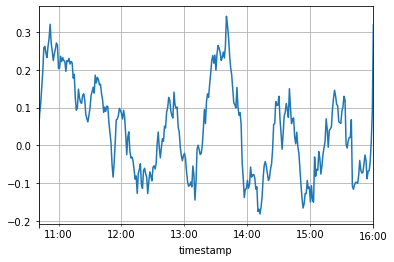

In [203]:
df_cmf.iloc[-320:].cmf_m30.plot().grid(True,which='both')

<AxesSubplot:xlabel='timestamp'>

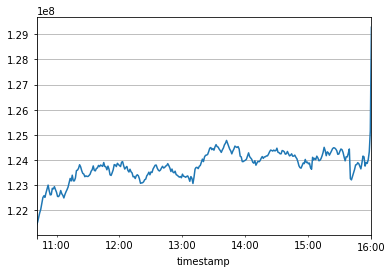

In [204]:
df_cmf.iloc[-320:].adl.plot(grid=True)

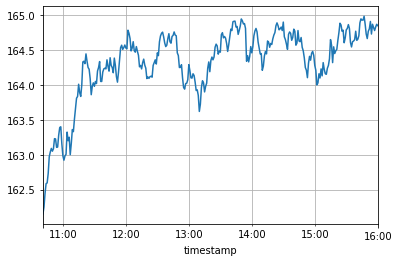

In [205]:
df_cmf.iloc[-320:].close.plot().grid(True,which='both')

### function: ATR [TA]
https://school.stockcharts.com/doku.php?id=technical_indicators:average_true_range_atr

In [206]:
def atr_adjust(df,period_list = [7,14,21],verbose=True):
    df = df.copy()
    scale='1d'

    if verbose:
        print('-- CALCULATING ATR --')

#     if 'adj_close' in df.columns:
#         base = 'adj_close'
#         prefix = 'adj_'
#     elif 'y_adj_close' in df.columns:
#         base = 'y_adj_close'
#         prefix = 'adj_'
#     else:
    base = 'close'
    prefix = ''

    # get interval info
    data_interval_value,data_interval_unit = get_interval(df)

    # minutes per data period
    if data_interval_unit == 'minute':
        data_minutes = data_interval_value
    elif data_interval_unit == 'hour':
        data_minutes = data_interval_value * 60
    elif data_interval_unit == 'day':
        data_minutes = data_interval_value * 60 * 6.5

    # create interval string
    data_interval_str = f'{data_interval_value}{data_interval_unit[:1]}'

    scale = scale.lower() # all lowercase
    scale_value = int(''.join([char for char in scale if char.isdigit()])) # pull scale value

    # convert any scales between 6h to 24h to 1d
    if (scale_value >= 6) and ('h' in scale):
        scale = '1d'
        scale_value = 1

    # scaling parameters
    if 'd' in scale:
        rule_unit,scale_unit = 'd','d'
        scale_minutes = int(scale_value * 60 * 6.5)
    elif 'h' in scale:
        rule_unit,scale_unit = 'h','h'
        scale_minutes = int(scale_value * 60)
    elif 'm' in scale:
        rule_unit,scale_unit = 't','m'
        scale_minutes = int(scale_value)

    # check if we have enough data resolution to aggregate results
    if data_minutes > scale_minutes:
        print('data resolution error -- data granularity not high enough to aggregate intended scale')
        #return
        
    if (scale_value == 1):
        scale_print = scale_unit
    else:
        scale_print = str(scale_value) + scale_unit

    scale_rule = str(scale_value) + rule_unit

    periods_per_scale = df.resample(scale_rule,closed='right')['close'].count().max() # pull number of periods per scale

    if verbose:
        print(f'{data_interval_str} data->{scale_print} periods; periods_per_scale: {periods_per_scale}')
    
    # downsample to daily data
    df_downsample = resample_data(df,scale=scale,verbose=False)
    
    # ATR calculations
    df_downsample[f'ch-cl'] = df_downsample['high'] - df_downsample['low'] # current high minus current low
    df_downsample[f'ch-pc'] = abs(df_downsample['high'] - df_downsample['close'].shift(1)) # absolute of current high minus previous close
    df_downsample[f'cl-pc'] = abs(df_downsample['low'] - df_downsample['close'].shift(1)) # absolute of current low minus previous close
    df_downsample[f'tr'] = df_downsample[['ch-cl','ch-pc','cl-pc']].values.max(1)
    
    for period in period_list:
        df_downsample[f'atr_{scale_print}{str(period).zfill(2)}'] = df_downsample.tr.ewm(span=period,min_periods=period).mean() # use exponential weigted moving average so that recent prices are weighted higher
    
    #df_upsample = df_downsample.iloc[:,df.shape[1]:].reindex(df.index,method='ffill')
    df_upsample = df_downsample.iloc[:,-7:].reindex(df.index,method='ffill')

    # concat the aggregates with the original df
    df_final = pd.concat([df,df_upsample],axis=1,join='inner')
    
    return df_final

In [207]:
atr_adjust(df_aapl)

-- CALCULATING ATR --
1m data->d periods; periods_per_scale: 391


,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,ch-cl,ch-pc,cl-pc,tr,atr_d07,atr_d14,atr_d21
timestamp,,,,,,,,,,,,,,,,,
2021-08-27 09:30:00-04:00,0,147.05820,147.24449,146.63934,147.22773,1059178.0,5360.0,146.95777,NaN,NaN,1.91477,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-27 09:31:00-04:00,0,147.21776,147.33743,147.09809,147.12790,316238.0,2800.0,147.23932,-0.00068,0.00191,1.91477,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-27 09:32:00-04:00,0,147.11803,147.46708,146.98838,147.26762,299887.0,2314.0,147.30453,0.00095,0.00044,1.91477,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-27 09:33:00-04:00,0,147.27759,147.27759,147.07814,147.09809,222329.0,2000.0,147.16533,-0.00115,-0.00095,1.91477,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-27 09:34:00-04:00,0,147.08821,147.09709,146.81386,147.01840,294671.0,2468.0,146.97179,-0.00054,-0.00132,1.91477,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25 15:56:00-05:00,0,164.87110,164.91000,164.76000,164.82500,303116.0,2726.0,164.83671,-0.00027,0.00005,4.24620,2.92,1.3262,4.2462,5.78797,5.19375,4.95958
2022-02-25 15:57:00-05:00,0,164.84000,164.84000,164.65000,164.78000,393515.0,3313.0,164.74379,-0.00027,-0.00056,4.24620,2.92,1.3262,4.2462,5.78797,5.19375,4.95958
2022-02-25 15:58:00-05:00,0,164.79000,164.85000,164.75000,164.83000,528911.0,4180.0,164.80739,0.00030,0.00039,4.24620,2.92,1.3262,4.2462,5.78797,5.19375,4.95958


### data pull + best indicator analysis

In [408]:
df_aapl = stock_alpaca(months_of_data=6)

-- DATA PULL - SYMBOL: AAPL, INTERVAL: 1MIN, START: 2021-09-02T22:59:00-04:00, END: 2022-03-02T22:59:00-05:00; SPLIT_ADJUST: True, DIV_ADJUST: True [16.8s]
n: 48304, price_na: 15 (0.0%), price_duplicates: 14208 (29.4%), min_date: 2021-09-03 09:30:00-04:00, max_date: 2022-03-02 16:00:00-05:00


In [411]:
df = df_aapl.copy()
df = ema_adjust(df,vwap=True)
df = roc_adjust(df)
df = obv_adjust(df)
df = cmf_adjust(df)
df

-- CALCULATING ROC
1m data->m periods; periods_per_scale: 1
raw_period: 5, adj_period: 5
raw_period: 10, adj_period: 10
raw_period: 15, adj_period: 15
raw_period: 20, adj_period: 20
raw_period: 30, adj_period: 30
raw_period: 60, adj_period: 60
-- CALCULATING OBV
1m data->m periods; periods_per_scale: 1
raw_period: 5, adj_period: 5
raw_period: 10, adj_period: 10
raw_period: 15, adj_period: 15
raw_period: 20, adj_period: 20
raw_period: 30, adj_period: 30
raw_period: 60, adj_period: 60
-- CALCULATING CMF
1m data->m periods; periods_per_scale: 1
raw_period: 3, adj_period: 3
raw_period: 10, adj_period: 10
raw_period: 20, adj_period: 20
raw_period: 30, adj_period: 30
raw_period: 60, adj_period: 60
raw_period: 90, adj_period: 90


,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,roc_m5_1,roc_m5_2,roc_m5_3,roc_m5_4,roc_m10_1,roc_m10_2,roc_m10_3,roc_m10_4,roc_m15_1,roc_m15_2,roc_m15_3,roc_m15_4,roc_m20_1,roc_m20_2,roc_m20_3,roc_m20_4,roc_m30_1,roc_m30_2,roc_m30_3,roc_m30_4,roc_m60_1,roc_m60_2,roc_m60_3,roc_m60_4,obv_m5,obv_m10,obv_m15,obv_m20,obv_m30,obv_m60,mfm,mfv,adl,cmf_m3,cmf_m10,cmf_m20,cmf_m30,cmf_m60,cmf_m90
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-03 09:30:00-04:00,0,153.33105,154.20866,153.22135,153.75988,1998914.0,11498.0,153.74027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09091,1.81722e+05,1.81722e+05,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-03 09:31:00-04:00,0,153.77983,154.01917,153.53051,153.56043,502924.0,4237.0,153.78769,-0.00130,0.00031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.87755,-4.41340e+05,-2.59618e+05,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-03 09:32:00-04:00,0,153.58027,153.73984,153.34103,153.41084,458345.0,3548.0,153.57107,-0.00097,-0.00141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.64991,-2.97885e+05,-5.57503e+05,-0.18833,NaN,NaN,NaN,NaN,NaN
2021-09-03 09:33:00-04:00,0,153.41084,153.49062,152.98201,152.99118,524667.0,4901.0,153.24919,-0.00274,-0.00210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.96392,-5.05738e+05,-1.06324e+06,-0.83783,NaN,NaN,NaN,NaN,NaN
2021-09-03 09:34:00-04:00,0,152.99198,153.19144,152.80469,152.80749,522843.0,4381.0,153.00485,-0.00120,-0.00160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2008779.0,NaN,NaN,NaN,NaN,NaN,-0.98556,-5.15291e+05,-1.57853e+06,-0.87586,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-02 15:56:00-05:00,0,166.87000,166.89000,166.78000,166.84500,232098.0,2328.0,166.83732,-0.00015,-0.00010,-0.00005,0.00056,0.00159,-0.00016,-0.00169,-0.00027,-0.00163,0.00009,-0.00142,-7.68664e-04,-0.00174,-0.02184,-0.00174,0.00016,-0.00369,-0.03346,-0.00110,-0.00005,-0.00221,0.01579,5.38850e-06,0.00002,-0.00010,-0.06572,-598650.0,-896204.0,-449733.0,-568449.0,-705978.0,-97210.0,0.18182,4.21996e+04,1.36854e+08,0.00484,0.05898,0.05912,0.07508,0.08608,0.08879
2022-03-02 15:57:00-05:00,0,166.84000,166.85000,166.53000,166.61000,404491.0,3731.0,166.68296,-0.00141,-0.00093,-0.00161,-0.00156,-0.00076,-0.00137,-0.00245,-0.00077,-0.00234,-0.00418,-0.00151,-8.18854e-05,-0.00093,-0.02085,-0.00257,-0.00083,-0.00401,-0.03791,-0.00208,-0.00098,-0.00350,0.00800,-6.68447e-04,-0.00067,-0.00078,-0.06510,-760494.0,-1130721.0,-634028.0,-1103093.0,-979601.0,-428773.0,-0.50000,-2.02245e+05,1.36652e+08,-0.34607,0.00064,0.00589,0.03972,0.06740,0.06820
2022-03-02 15:58:00-05:00,0,166.61000,166.63000,166.40000,166.53000,574044.0,5028.0,166.52035,-0.00048,-0.00098,-0.00251,-0.00090,-0.00160,-0.00358,-0.00342,-0.00097,-0.00318,-0.00919,-0.00251,-1.00170e-03,-0.00168,-0.02140,-0.00366,-0.00110,-0.00512,-0.04404,-0.00333,-0.00125,-0.00514,-0.00246,-1.52518e-03,-0.00086,-0.00178,-0.06647,-1116596.0,-1915750.0,-1327404.0,-1532695.0,-1663194.0,-921886.0,0.13043,7.48753e+04,1.36727e+08,-0.07035,0.00130,0.04336,0.03767,0.07556,0.06741


In [ ]:
df.index = df.index.strftime('%x %X')
df.to_excel(data_path/'aapl_roc_data.xlsx')

### function: momentum adjust [TA]
Returns slope, r^2, and momentum score values

In [208]:
def slope_value(prices): # returns momentum scores
    x = np.arange(len(prices)).reshape(-1,1)
    y = np.log(prices)
    reg = LinearRegression().fit(X=x,y=y)
    slope = reg.coef_[0]
#     print(f'slope: {slope}, r^2: {r_sq}')

    return slope.round(5)

def r2_value(prices): # returns momentum scores
    x = np.arange(len(prices)).reshape(-1,1)
    y = np.log(prices)
    reg = LinearRegression().fit(X=x,y=y)
    r2_value = reg.score(x,y)

    # print(f'slope: {slope}, r^2: {r_sq}')

    return r2_value.round(4)

def momentum_value(prices): # returns momentum scores
    x = np.arange(len(prices)).reshape(-1,1)
    y = np.log(prices)
    reg = LinearRegression().fit(X=x,y=y)
    slope = reg.coef_[0]
    r2_value = reg.score(x,y)
    momentum_value = ((1+slope) ** 252) * r2_value # annualized momentum change value
    
#     print(f'slope: {slope}, r^2: {r_sq}')

    return momentum_value.round(4)

# momentum trading strategy

### Buy Rules
* Market
    * S&P 500 index price is above its sma(200)
* Stock
    * Stock is part of S&P 500
    * Stock price is above its sma(100)
    * Price hasn't had a drastic 15% change in last 90 days -- chg_max(90)
    * Track r2_coef(90) -- r^2 with a value closer to 1 means it conforms to a more linear growth and has less volatility
    * Track mom(90) -- 90 day annualized momentum change -- higher value means higher growth trend

### Sell Rules
* Stock no longer part of the top 20% of momentum rankings
* Stock price falls under its sma(100)
* Index price falls under its sma(200)

### Position Sizing -- calculated based on risk
* shares = (account_value * risk_factor)/ATR
* risk_factor = 10 basis points or 0.1% (0.001)
* ATR -- average true range of period 14

### function: momentum strategy adjust -- track strategy rules

In [209]:
def momentum_strategy_adjust(df,period_list=[3,5,7]):
    df = df.copy()
    intraday_factor = int(df.groupby(pd.Grouper(freq='D')).close.count().median()) # retrieves number of records in a day; ensures that daily and intraday data is treated accordingly
    
    #print(period,intraday_factor,adj_period)
    
    for period in period_list:
        #df[f'pct_chg_max_{str(period).zfill(2)}'] = df.pct_chg.rolling(adj_period).max()
        df[f'slope_d{str(period).zfill(2)}'] = df['close'].rolling(period*intraday_factor).apply(slope_value)
        df[f'r2_d{str(period).zfill(2)}'] = df['close'].rolling(period*intraday_factor).apply(r2_value)
        df[f'mom_d{str(period).zfill(2)}'] = df['close'].rolling(period*intraday_factor).apply(momentum_value)
    
    return df

In [210]:
momentum_strategy_adjust(df_aapl).tail()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/selim/opt/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-210-04ef0e892603>", line 1, in <module>
    momentum_strategy_adjust(df_aapl).tail()
  File "<ipython-input-209-173fe4cbd448>", line 9, in momentum_strategy_adjust
    df[f'slope_d{str(period).zfill(2)}'] = df['close'].rolling(period*intraday_factor).apply(slope_value)
  File "/Users/selim/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/window/rolling.py", line 2036, in apply
    kwargs=kwargs,
  File "/Users/selim/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/window/rolling.py", line 1321, in apply
    numba_cache_key=numba_cache_key,
  File "/Users/selim/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/window/rolling.py", line 469, in _apply
    return self._apply_blockwise(homogeneous_func, name)

TypeError: object of type 'NoneType' has no len()

### stock data pipeline
* step 1: pull data
* step 2: process ta indicators

In [ ]:
def stock_pipeline(symbol='aapl',interval='1m',months_of_data=None,start_date=None,period_list=[4,12],onehot_encode=False,div_adjust=True,split_adjust=True,verbose=True):
#     if 'd' in interval:
#         # via yahoo finance
#         df = stock_daily(symbol=symbol,months_of_data=months_of_data,start_date=start_date,div_adjust=div_adjust,split_adjust=split_adjust,verbose=verbose)
#     else:
#         # via tiinga api
#         df = stock_intraday(symbol=symbol,interval=interval,months_of_data=months_of_data,start_date=start_date,div_adjust=div_adjust,split_adjust=split_adjust,verbose=verbose)
    
    df = stock_alpaca(symbol=symbol,months_of_data=months_of_data,start_date=start_date,split_adjust=split_adjust,div_adjust=div_adjust,verbose=verbose)
    df = sma_adjust(df,period_list=period_list,verbose=verbose) # sma lines
    df = ema_adjust(df,period_list=period_list,verbose=verbose) # ema lines
    #df = rsi_adjust(df,verbose=verbose) # rsi
    #df = macd_adjust(df,verbose=verbose) # macd 
    df = asr_adjust(df,period_list=[2,3,4,5,6],verbose=verbose) # sharpe ratio
    #df = atr_adjust(df,verbose=verbose) # atr (measures daily volatility)
    #df = momentum_strategy_adjust(df,period_list=[1,3])
    #df = momentum_strategy_adjust(df,period=60)
    #print(f'Pulled {months_of_data} years of {symbol.upper()}; record_count: {df.shape[0]}')    
    #stk = stock_pipeline(stock_symbol,interval,start_date=start_date) # pull stock data
    
    if onehot_encode:
        if verbose:
            print('-- APPLYING ONE-HOT ENCODING TO BUY RULES --')
        df_market = market_pipeline(interval=interval,start_date=df.index.min(),verbose=verbose) # pull market data
        df_market = df_market.reindex(index=df.index) # sync market to stock index
        df = onehot_encode(df,df_market,unique_rule_list)
    
    return df

In [ ]:
# df_aapl = stock_pipeline(symbol='aapl',months_of_data=12)
# df_aapl.tail()

### technical analysis pipeline
Process technical indicators

In [ ]:
def ta_pipeline(df,scale='1d',ma_periods=np.arange(1,22,2),asr_periods=np.arange(1,8,2),verbose=True):
    t0 = time.time()
    df = df.copy()
    
    df['pct_chg_log'] = df.close.apply(np.log).diff() # calc pct_chg_log
    
    df = sma_adjust(df,scale=scale,period_list=ma_periods,verbose=verbose) # sma lines
    df = ema_adjust(df,scale=scale,period_list=ma_periods,verbose=verbose) # ema lines
    #df = rsi_adjust(df,verbose=verbose) # rsi
    #df = macd_adjust(df,verbose=verbose) # macd 
    df = asr_adjust(df,scale=scale,period_list=asr_periods,verbose=verbose) # sharpe ratio
    #df = atr_adjust(df,verbose=verbose) # atr (measures daily volatility)
    #df = momentum_strategy_adjust(df,period_list=[1,3])
    #df = momentum_strategy_adjust(df,period=60)
    #print(f'Pulled {months_of_data} years of {symbol.upper()}; record_count: {df.shape[0]}')    
    #stk = stock_pipeline(stock_symbol,interval,start_date=start_date) # pull stock data
    
#     if onehot_encode:
#         if verbose:
#             print('-- APPLYING ONE-HOT ENCODING TO BUY RULES --')
#         df_market = market_pipeline(interval=interval,start_date=df.index.min(),verbose=verbose) # pull market data
#         df_market = df_market.reindex(index=df.index) # sync market to stock index
#         df = onehot_encode(df,df_market,unique_rule_list)
    
    if verbose:
        print(f'-- TA INDICATORS PROCESSED [{seconds_format(time.time()-t0)}]')

    return df

In [ ]:
ta_pipeline(df_aapl)

### function: plot stock chart

In [ ]:
def stock_chart(df,scale='1d',ema_only=True,title=None,log_norm=False):
    df = df.copy()
#     if (lookback_months != None) and (lookback_years != None):
#         print('Only provide lookback_months or lookback_years')
#         return
    
#     if lookback_years != None:
#         df_plot = df[df.index >= (df.index.max() - pd.DateOffset(years=lookback_years))]
#     elif lookback_months != None:
#         df_plot = df[df.index >= (df.index.max() - pd.DateOffset(months=lookback_months))]
#     else:
#         df_plot = df # all the price data
    
#     plt.figure(figsize=(20,12))
    
    if 'adj_close' in df.columns:
        base = 'adj_close'
    else:
        base = 'close'
    
    # apply log norm conversion
    if log_norm:
        for col in ['open','high','low','close']:
            df[col] = df[col].apply(np.log)

    if ema_only:
        rel_cols = [col for col in df.columns if (('ema' in col)) and ('<' not in col) and ('>' not in col)]
    else:
        rel_cols = [col for col in df.columns if (('sma' in col) or ('ema' in col)) and ('<' not in col) and ('>' not in col)]
        
#    print(rel_cols)
#     for col in rel_cols:
#         if log_norm:
#             plt.plot(df_plot[col].apply(np.log),label=col)
#         else:
#             plt.plot(df_plot[col],label=col)
        
#     plt.xticks()
#     plt.grid()
#     plt.legend()
    
#     if title:
#         plt.title(title)
        
    df = resample_data(df,scale=scale)
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                    open=df['open'],
                    high=df['high'],
                    low=df['low'],
                    close=df['close'])])
    
    fig.update_layout(title_text=title, title_x=0.5)
    fig.show(renderer='iframe')

In [ ]:
stock_chart(df_aapl,title='AAPL')

In [ ]:
stock_chart(df_spy,title='SPY')

### function to transform various buy_rules to a standardized set type

In [ ]:
def rule_cleanup(buy_rules):
    #return sorted({rule for rule in str(buy_rules).replace('[','').replace(']','').replace('{','').replace('}','').replace(' ','').replace('"','').replace("'",'').replace('<',' < ').replace('>',' > ').split(',')})
    return sorted({rule for rule in str(buy_rules).replace('[','').replace(']','').replace('{','').replace('}','').replace(' ','').replace('"','').replace("'",'').split(',')})

In [ ]:
rule_cleanup("['mkt.asr_20 > 1.5', 'stk.asr_20 > 1.0']")

In [ ]:
rule_cleanup(['mkt.asr_20>1.5', 'stk.asr_20>1.0'])

In [ ]:
rule_cleanup(['mkt.asr_20 > 1.5', 'stk.asr_20 > 1.0'])

In [ ]:
rule_cleanup([{'mkt.asr_20>1.5', 'stk.asr_20>1.0'},{'mkt.asr_20>1.5', 'stk.asr_20>1.0'}])

In [ ]:
' & '.join(rule_cleanup({'mkt.asr_20>1.5', 'stk.asr_20>1.0'}))

### buy rules generator v4

In [140]:
#period_list = [None,3,5,10,15,30,60,120]
period_list = [4,6,8,10,12,20,30,40,60,90]
#period_list = [4,6,8,10,12,20,30,40,60,90]
volume_list = [None,10,20,30,40,60]
cmf_list = [None,10,20,30]
rsi_list = [None,6,9,14]
stock_inc_list = [None] + np.arange(1,4).tolist()
verbose = False # if we want print readouts for every buy_rule
print_interval = 1000 # tracks total buy_rule results acquired

buy_rules_list = []
results_list = []
t0 = time.time()
t1 = time.time()
i = 0
# for chg_log_index in np.arange(len(period_list)-3):
#     for chg_log_value in np.arange(0,0.004,0.001):
for stock_index in np.arange(6):
    for stock_index_inc1 in stock_inc_list:
        for stock_index_inc2 in stock_inc_list:
            for stock_index_inc3 in stock_inc_list:
                for vol_index in np.arange(len(volume_list)):
                    for vol_index_inc1 in np.arange(1,4):
                        for cmf in cmf_list:
                            for macd in [None,True]:
                                #for rsi in rsi_list:
                                #for conf in np.arange(1,4):
                                buy_rules = []

                                #if period_list[chg_log_index] != None:
                                #    buy_rules.append(f'df.pct_chg_log_m{str(period_list[chg_log_index]).zfill(2)} > {chg_log_value}')
                                #else:
                                #    pass

                                if period_list[stock_index] != None:
                                    if stock_index_inc1 != None:
                                        if stock_index+stock_index_inc1 < len(period_list):
                                            buy_rules.append(f'df.ema_m{str(period_list[stock_index]).zfill(2)} > df.ema_m{str(period_list[stock_index+stock_index_inc1]).zfill(2)}')
                                        else:
                                            pass

                                    if stock_index_inc1 != None and stock_index_inc2 != None:
                                        if stock_index+stock_index_inc1+stock_index_inc2 < len(period_list):
                                            buy_rules.append(f'df.ema_m{str(period_list[stock_index+stock_index_inc1]).zfill(2)} > df.ema_m{str(period_list[stock_index+stock_index_inc1+stock_index_inc2]).zfill(2)}')
                                        else:
                                            pass

                                    if stock_index_inc1 != None and stock_index_inc2 != None and stock_index_inc3 != None:
                                        if stock_index+stock_index_inc1+stock_index_inc2+stock_index_inc3 < len(period_list):
                                            buy_rules.append(f'df.ema_m{str(period_list[stock_index+stock_index_inc1+stock_index_inc2]).zfill(2)} > df.ema_m{str(period_list[stock_index+stock_index_inc1+stock_index_inc2+stock_index_inc3]).zfill(2)}')
                                        else:
                                            pass

                                if volume_list[vol_index] != None:
                                    if vol_index+vol_index_inc1 < len(volume_list):
                                        buy_rules.append(f'df.vol_m{str(volume_list[vol_index]).zfill(2)} > df.vol_m{str(volume_list[vol_index+vol_index_inc1]).zfill(2)}')

                                if cmf != None:
                                    buy_rules.append(f'df.cmf_m{str(cmf).zfill(2)} > 0')

                                if macd != None:
                                    buy_rules.append(f'df.macd_delta > 0')

#                                 if rsi != None:
#                                     buy_rules.append(f'df.rsi_d{str(rsi).zfill(2)} < 70')



                                #if len(buy_rules) > 0:
                                #    buy_rules.append(f'df.cnt >= {conf}')
                                #else:
                                #    continue
                                if len(buy_rules) == 0:
                                    continue

                                if buy_rules not in buy_rules_list:
                                    buy_rules_list.append(buy_rules)
                                    i += 1

                                    if i % print_interval == 0:
                                        print(i,str(buy_rules))

1000 ['df.ema_m04 > df.ema_m06', 'df.ema_m06 > df.ema_m12', 'df.ema_m12 > df.ema_m30', 'df.vol_m20 > df.vol_m40']
2000 ['df.ema_m04 > df.ema_m08', 'df.ema_m08 > df.ema_m20', 'df.ema_m20 > df.ema_m40']
3000 ['df.ema_m04 > df.ema_m10', 'df.ema_m10 > df.ema_m30', 'df.ema_m30 > df.ema_m40', 'df.vol_m20 > df.vol_m40']
4000 ['df.ema_m06 > df.ema_m08', 'df.ema_m08 > df.ema_m20', 'df.ema_m20 > df.ema_m30']
5000 ['df.ema_m06 > df.ema_m10', 'df.ema_m10 > df.ema_m30', 'df.vol_m20 > df.vol_m40']
6000 ['df.ema_m06 > df.ema_m12', 'df.ema_m12 > df.ema_m40']
7000 ['df.ema_m08 > df.ema_m10', 'df.ema_m10 > df.ema_m30', 'df.vol_m20 > df.vol_m40']
8000 ['df.ema_m08 > df.ema_m12', 'df.ema_m12 > df.ema_m40']
9000 ['df.ema_m08 > df.ema_m20', 'df.ema_m20 > df.ema_m60', 'df.ema_m60 > df.ema_m90', 'df.vol_m20 > df.vol_m40']
10000 ['df.ema_m10 > df.ema_m20']
11000 ['df.ema_m10 > df.ema_m30', 'df.ema_m30 > df.ema_m40', 'df.ema_m40 > df.ema_m60', 'df.vol_m20 > df.vol_m40']
12000 ['df.ema_m12 > df.ema_m20', 'df.ema

In [141]:
len(buy_rules_list)

14079

### pull stock data and run technical indicators

In [145]:
ema_cols = [col for col in df.columns if 'ema' in col]
for col in ema_cols:
    df[f'{col}_roc'] = df[col].apply(np.log).diff()*100 # rate of change measure for ema

In [146]:
ema_cols

['ema_m3',
 'ema_m5',
 'ema_m10',
 'ema_m15',
 'ema_m20',
 'ema_m30',
 'ema_m40',
 'ema_m60']

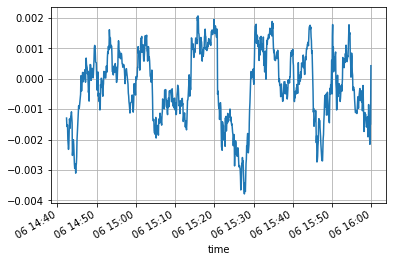

In [155]:
df.ema_m10_roc.iloc[-920:].plot().grid()

In [147]:
df

,open,high,low,close,volume,vol_m3,vol_m5,vol_m10,vol_m20,pct_chg_log,pct_chg_log_m3,pct_chg_log_m5,pct_chg_log_m10,pct_chg_log_m15,pct_chg_log_m20,pct_chg_log_m30,pct_chg_log_m40,pct_chg_log_m60,ema_m3,ema_m5,ema_m10,ema_m15,ema_m20,ema_m30,ema_m40,ema_m60,ema_m3_roc,ema_m5_roc,ema_m10_roc,ema_m15_roc,ema_m20_roc,ema_m30_roc,ema_m40_roc,ema_m60_roc
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-03 14:04:50-05:00,160.30,160.33,160.300,160.300,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-03 14:04:55-05:00,160.29,160.29,160.250,160.250,228,NaN,NaN,NaN,NaN,-0.00031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-03 14:05:00-05:00,160.29,160.31,160.250,160.250,3862,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-03 14:05:05-05:00,160.25,160.26,160.245,160.250,513,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-03 14:05:10-05:00,160.24,160.26,160.200,160.220,1092,NaN,NaN,NaN,NaN,-0.00019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-06 15:59:35-05:00,165.16,165.16,165.110,165.125,3930,2208.91667,2175.13333,2191.05833,1701.81667,-0.00027,-0.00118,-0.00251,-0.00112,-0.00317,-0.00233,-0.00130,-0.00348,-0.00251,165.23801,165.27302,165.31567,165.33805,165.35414,165.38030,165.40490,165.45542,-0.00391,-0.00304,-0.00194,-0.00144,-1.15961e-03,-0.00086,-0.00071,-0.00056
2021-12-06 15:59:40-05:00,165.13,165.14,165.090,165.100,4409,2300.16667,2113.18333,2215.83333,1716.88333,-0.00015,-0.00121,-0.00218,-0.00145,-0.00314,-0.00260,-0.00145,-0.00369,-0.00266,165.23055,165.26735,165.31211,165.33542,165.35203,165.37875,165.40363,165.45443,-0.00451,-0.00343,-0.00216,-0.00159,-1.27547e-03,-0.00094,-0.00077,-0.00060
2021-12-06 15:59:45-05:00,165.10,165.17,165.095,165.160,25110,2982.02778,2519.76667,2419.17500,1820.22917,0.00036,-0.00073,-0.00175,-0.00103,-0.00272,-0.00224,-0.00097,-0.00326,-0.00242,165.22673,165.26383,165.30959,165.33348,165.35043,165.37754,165.40262,165.45362,-0.00231,-0.00213,-0.00152,-0.00117,-9.63764e-04,-0.00073,-0.00061,-0.00049


In [567]:
df = stock_alpaca('aapl',months_of_data=12)

period_list = [2,3,4,5,6,7,8,9,10,12,15,20,30,40,45,60,90,120]
volume_list = [5,10,15,20,30,60,120]

# volume MAs
periods_per_scale = 1 # 12
for period in period_list:
    df[f'vol_m{str(period).zfill(2)}'] = df.volume.rolling(period*periods_per_scale).median()

# pct chg log across various timeframes
for period in volume_list:
    df[f'pct_chg_log_m{str(period).zfill(2)}'] = df.pct_chg_log.rolling(period*periods_per_scale).sum()
    
# ema adjust
# df = sma_adjust(df,scale='1m',period_list=period_list)
df = ema_adjust(df,scale='1m',period_list=[2,3,4,5,6,7,8,9,10,12,15,20,30,40,45,60,90,120])
df = ema_adjust(df,scale='1h',period_list=[1,2,3,4,5,6,7,8,9,10,12,15,20,30,40,45,60,90,120])
df = ema_adjust(df,scale='1d',period_list=[1,2,3,4,5,6,7,8,9,10,12,15,20,30,40,45,60,90,120])
df = cmf_adjust(df)
df = macd_adjust(df)
df = rsi_adjust(df)
df = roc_adjust(df)

# ema rate of change
# ema_cols = [col for col in df.columns if 'ema' in col]
# for col in ema_cols:
#     df[f'{col}_roc'] = df[col].apply(np.log).diff()*100 # rate of change measure for ema

# ## apply buy/sell rule conditions
# # example_buy_rule = '(df["pct_chg_log_m5"] > 0.001) & (df["m5>0_count"] >= 2)'
# for period in [3,5,10,15,20,30,40,60]:
#     for conf_count in [1,2,3,4,5,6,7,8,9,10]:
#         for value in np.arange(0,0.01,0.0005)[:1]:
#             print(f'period: {period}, conf_count: {conf_count}, value: {value}')
#             df['signal'] = (df[f'pct_chg_log_m{period}'] > value)*1
#             df['group'] = (df['signal'] != df['signal'].shift()).cumsum()
#             df['count'] = df.groupby('group')['signal'].cumsum()
            
#             buy_rule = f'(df["pct_chg_log_m{period}"] > {value}) & (df["m{period}>_count"] >= {conf_count})'
            
#             pd.eval(buy_rule)
    
# df['m5>0'] = (df.pct_chg_log_m5 > 0.001)*1
# df['m5>0_grp'] = (df['m5>0']!=df['m5>0'].shift()).cumsum()
# df['m5>0_count'] = df.groupby('m5>0_grp')['m5>0'].cumsum()
df.tail()

-- DATA PULL - SYMBOL: AAPL, INTERVAL: 1MIN, START: 2021-03-08T01:21:00-05:00, END: 2022-03-08T01:21:00-05:00; SPLIT_ADJUST: True, DIV_ADJUST: True [34.8s]
n: 98743, price_na: 15 (0.0%), price_duplicates: 32023 (32.4%), min_date: 2021-03-08 09:30:00-05:00, max_date: 2022-03-07 16:00:00-05:00
-- CALCULATING EMA
VWAP PRICE MOVING AVERAGE
1m data->m periods; periods_per_scale: 1
raw_period: 2, adj_period: 2
raw_period: 3, adj_period: 3
raw_period: 4, adj_period: 4
raw_period: 5, adj_period: 5
raw_period: 6, adj_period: 6
raw_period: 7, adj_period: 7
raw_period: 8, adj_period: 8
raw_period: 9, adj_period: 9
raw_period: 10, adj_period: 10
raw_period: 12, adj_period: 12
raw_period: 15, adj_period: 15
raw_period: 20, adj_period: 20
raw_period: 30, adj_period: 30
raw_period: 40, adj_period: 40
raw_period: 45, adj_period: 45
raw_period: 60, adj_period: 60
raw_period: 90, adj_period: 90
raw_period: 120, adj_period: 120
-- CALCULATING EMA
VWAP PRICE MOVING AVERAGE
1m data->h periods; periods_per_

,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,vol_m02,vol_m03,vol_m04,vol_m05,vol_m06,vol_m07,vol_m08,vol_m09,vol_m10,vol_m12,vol_m15,vol_m20,vol_m30,vol_m40,vol_m45,vol_m60,vol_m90,vol_m120,pct_chg_log_m05,pct_chg_log_m10,pct_chg_log_m15,pct_chg_log_m20,pct_chg_log_m30,pct_chg_log_m60,pct_chg_log_m120,ema_m02,ema_m03,ema_m04,ema_m05,ema_m06,ema_m07,ema_m08,ema_m09,ema_m10,ema_m12,ema_m15,ema_m20,ema_m30,ema_m40,ema_m45,ema_m60,ema_m90,ema_m120,ema_h01,ema_h02,ema_h03,ema_h04,ema_h05,ema_h06,ema_h07,ema_h08,ema_h09,ema_h10,ema_h12,ema_h15,ema_h20,ema_h30,ema_h40,ema_h45,ema_h60,ema_h90,ema_h120,ema_d01,ema_d02,ema_d03,ema_d04,ema_d05,ema_d06,ema_d07,ema_d08,ema_d09,ema_d10,ema_d12,ema_d15,ema_d20,ema_d30,ema_d40,ema_d45,ema_d60,ema_d90,ema_d120,mfm,mfv,adl,cmf_m3,cmf_m10,cmf_m20,cmf_m30,cmf_m60,cmf_m90,macd_delta,rsi_d03,rsi_d06,rsi_d09,rsi_d14,roc_m5_0,roc_m5_1,roc_m5_2,roc_m5_3,roc_m5_4,roc_m10_0,roc_m10_1,roc_m10_2,roc_m10_3,roc_m10_4,roc_m15_0,roc_m15_1,roc_m15_2,roc_m15_3,roc_m15_4,roc_m20_0,roc_m20_1,roc_m20_2,roc_m20_3,roc_m20_4,roc_m30_0,roc_m30_1,roc_m30_2,roc_m30_3,roc_m30_4,roc_m60_0,roc_m60_1,roc_m60_2,roc_m60_3,roc_m60_4
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-07 15:56:00-05:00,0,159.480,159.680,159.45,159.455,504754.0,4314.0,159.57030,-0.00016,0.00152,495681.5,486609.0,472050.0,457491.0,446521.5,457491.0,446521.5,435552.0,402890.5,402890.5,336270.0,287000.5,280331.0,265768.5,264101.0,234200.5,193460.5,161771.0,-0.00002,-0.00194,-0.00369,-0.00272,-0.00572,-0.00747,-0.01197,159.48166,159.44507,159.43730,159.44451,159.45934,159.47783,159.49783,159.51814,159.53814,159.57606,159.62663,159.69625,159.80308,159.89121,159.93215,160.04774,160.25608,160.44138,160.04774,160.44138,160.75956,161.02558,161.25710,161.46632,161.65981,161.84043,162.00918,162.16636,162.44663,162.78716,163.18365,163.62752,163.92694,164.07034,164.51151,165.36103,166.06869,161.56801,162.57423,163.15486,163.48536,163.70978,163.90117,164.08814,164.27837,164.47141,164.66453,165.04070,165.55882,166.27645,167.17906,167.45397,167.40609,166.77120,164.52305,162.16538,-0.95652,-4.82808e+05,2.80007e+08,-0.21446,-0.22854,-0.17678,-0.18439,-0.16141,-0.12522,-0.01377,16.3942,28.22471,33.03883,37.50587,-0.00227,0.00005,0.00193,0.00178,0.00058,-0.00230,-0.00168,0.00258,-1.38654e-03,-0.02695,-0.00186,-0.00251,0.00142,-0.00034,-0.02575,-0.00236,-0.00197,0.00194,-0.00129,-0.03028,-0.00217,-0.00468,0.00052,-0.00300,0.01329,-0.00584,-0.00635,0.00025,-0.00126,-0.11458
2022-03-07 15:57:00-05:00,0,159.480,159.930,159.48,159.790,574929.0,5431.0,159.70630,0.00210,0.00085,539841.5,504754.0,495681.5,486609.0,472050.0,457491.0,472050.0,457491.0,446521.5,402890.5,370229.0,308706.0,280331.0,271594.5,267436.0,236333.5,196824.5,162986.5,0.00260,-0.00016,-0.00163,-0.00088,-0.00359,-0.00450,-0.00913,159.63142,159.57569,159.54490,159.53177,159.52990,159.53495,159.54415,159.55577,159.56872,159.59610,159.63659,159.69721,159.79683,159.88219,159.92233,160.03655,160.24400,160.42923,160.03655,160.42923,160.74793,161.01463,161.24679,161.45657,161.65053,161.83155,162.00067,162.15817,162.43902,162.78032,163.17786,163.62317,163.92343,164.06711,164.50884,165.35894,166.06692,161.55851,162.56691,163.14899,163.48053,163.70569,163.89760,164.08494,164.27545,164.46871,164.66199,165.03843,165.55682,166.27476,167.17778,167.45298,167.40521,166.77059,164.52277,162.16528,0.37778,2.17195e+05,2.80224e+08,0.14110,-0.15630,-0.13347,-0.16004,-0.13737,-0.10846,-0.01512,16.3942,28.22471,33.03883,37.50587,-0.00188,0.00167,0.00162,0.00394,0.00695,-0.00230,-0.00061,0.00107,1.87964e-04,-0.02171,-0.00202,-0.00204,0.00047,-0.00017,-0.02285,-0.00236,-0.00140,0.00057,-0.00177,-0.03076,-0.00231,-0.00390,0.00078,-0.00234,0.00791,-0.00584,-0.00546,0.00089,-0.00062,-0.11205
2022-03-07 15:58:00-05:00,0,159.790,159.840,159.51,159.550,709749.0,6259.0,159.66683,-0.00150,-0.00025,642339.0,

In [94]:
# df.index = df.index.strftime('%x %X')
# df.to_excel(data_path/'aapl.xlsx')

### backtest different trading strategies

In [417]:
def backtest_strategy(df,buy_rules,slippage=0.00025):
    # slippage: 0.025% expected ask/bid slippage; use higher value for a more conservative estimate
    df = df.copy()
    buy_rules = rule_cleanup(buy_rules)
    
    conf_list = [rule for rule in buy_rules if 'cnt' in rule]
    if len(conf_list) > 0:
        #conf = int(conf_list[0].split('>=')[-1][0])
        conf = int(conf_list[0].split('>=')[-1].strip())
    else:
        #print('no confirmation rule found in buy rules')
        conf = 1
    
    df['signal'] = (pd.eval('&'.join([rule for rule in buy_rules if 'cnt' not in rule])))*1
    df['group'] = (df['signal'] != df['signal'].shift()).cumsum()
    df['cnt'] = df.groupby('group')['signal'].cumsum()

    df['rule'] = df['signal'] & (df['cnt'] >= conf)*1
    # buy_rule = f'df.pct_chg_log_m{chg_log_period} > {chg_log_value} & df.cnt >= {conf_count}'            
    # df['rule2'] = pd.eval(buy_rule)*1

    close_col = df.columns.get_loc('close')
    
    if df[df.rule == 1].shape[0] > 0:
        df_trades = pd.DataFrame(df[df.rule == 1].groupby('group').apply(lambda x: [x.index[0],x.index[-1],x.shape[0],x.iat[0,close_col]*(1+slippage),x.iat[-1,close_col]*(1-slippage),np.log((x.iat[-1,close_col]*(1-slippage))/(x.iat[0,close_col]*(1+slippage))),x['low'].min(),x['high'].max(),x.iat[-1,close_col]/x['high'].max()]).to_list(),columns=['buy_ts','sell_ts','tim','buy_price','sell_price','roi','min','max','peak_sale'])
    else:
        df_trades = pd.DataFrame(columns=['buy_ts','sell_ts','tim','buy_price','sell_price','roi','min','max','peak_sale'])
    
    return df,df_trades

In [420]:
df

,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,vol_m02,vol_m03,vol_m04,vol_m05,vol_m06,vol_m07,vol_m08,vol_m09,vol_m10,vol_m12,vol_m15,vol_m20,vol_m30,vol_m40,vol_m45,vol_m60,vol_m90,vol_m120,pct_chg_log_m05,pct_chg_log_m10,pct_chg_log_m15,pct_chg_log_m20,pct_chg_log_m30,pct_chg_log_m60,pct_chg_log_m120,ema_m02,ema_m03,ema_m04,ema_m05,ema_m06,ema_m07,ema_m08,ema_m09,ema_m10,ema_m12,ema_m15,ema_m20,ema_m30,ema_m40,ema_m45,ema_m60,ema_m90,ema_m120,mfm,mfv,adl,cmf_m3,cmf_m10,cmf_m20,cmf_m30,cmf_m60,cmf_m90,macd_delta,rsi_d03,rsi_d06,rsi_d09,rsi_d14
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-03-08 09:30:00-05:00,0,120.25585,120.28568,119.65940,119.90295,2029960.0,12265.0,120.08745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.22222,-4.51100e+05,-4.51100e+05,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.0000,0.00000,0.00000,0.00000
2021-03-08 09:31:00-05:00,0,119.90792,119.90792,119.14247,119.22199,916323.0,10084.0,119.43249,-0.00570,-0.00547,1473141.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.59623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.79221,-7.25917e+05,-1.17702e+06,NaN,NaN,NaN,NaN,NaN,NaN,-0.00031,0.0000,0.00000,0.00000,0.00000
2021-03-08 09:32:00-05:00,0,119.23193,119.24188,118.63548,118.90885,996729.0,8866.0,118.87303,-0.00263,-0.00470,956526.0,996729.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119.09555,119.20636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.09836,-9.80409e+04,-1.27506e+06,-0.32337,NaN,NaN,NaN,NaN,NaN,-0.00077,0.0000,0.00000,0.00000,0.00000
2021-03-08 09:33:00-05:00,0,118.88400,119.05300,118.70685,119.04296,632847.0,5384.0,118.83273,0.00113,-0.00034,814788.0,916323.0,956526.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.91815,119.00709,119.06762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.94199,5.96135e+05,-6.78924e+05,-0.08949,NaN,NaN,NaN,NaN,NaN,-0.00116,0.0000,0.00000,0.00000,0.00000
2021-03-08 09:34:00-05:00,0,119.02317,119.07288,118.38695,118.47642,785022.0,6688.0,118.62387,-0.00477,-0.00176,708934.5,785022.0,850672.5,916323.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.72115,118.80930,118.87515,118.92279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.73913,-5.80235e+05,-1.25916e+06,-0.03402,NaN,NaN,NaN,NaN,NaN,-0.00181,0.0000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07 15:56:00-05:00,0,159.48000,159.68000,159.45000,159.45500,504754.0,4314.0,159.57030,-0.00016,0.00152,495681.5,486609.0,472050.0,457491.0,446521.5,457491.0,446521.5,435552.0,402890.5,402890.5,336270.0,287000.5,280331.0,265768.5,264101.0,234200.5,193460.5,161771.0,-0.00002,-0.00194,-0.00369,-0.00272,-0.00572,-0.00747,-0.01197,159.48166,159.44507,159.43730,159.44451,159.45934,159.47783,159.49783,159.51814,159.53814,159.57606,159.62663,159.69625,159.80308,159.89121,159.93215,160.04774,160.25608,160.44138,-0.95652,-4.82808e+05,2.80007e+08,-0.21446,-0.22854,-0.17678,-0.18439,-0.16141,-0.12522,-0.01377,16.3942,28.22471,33.03883,37.50587
2022-03-07 15:57:00-05:00,0,159.48000,159.93000,159.48000,159.79000,574929.0,5431.0,159.70630,0.00210,0.00085,539841.5,504754.0,495681.5,486609.0,472050.0,457491.0,472050.0,457491.0,446521.5,402890.5,370229.0,308706.0,280331.0,271594.5,267436.0,236333.5,196824.5,162986.5,0.00260,-0.00016,-0.00163,-0.00088,-0.00359,-0.00450,-0.00913,159.63142,159.57569,159.54490,159.53177,159.52990,159.534

In [568]:
df.columns

Index(['na', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap',
       'pct_chg_log', 'pct_chg_log_vwap',
       ...
       'roc_m30_0', 'roc_m30_1', 'roc_m30_2', 'roc_m30_3', 'roc_m30_4',
       'roc_m60_0', 'roc_m60_1', 'roc_m60_2', 'roc_m60_3', 'roc_m60_4'],
      dtype='object', length=135)

In [569]:
df.tail()

,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,vol_m02,vol_m03,vol_m04,vol_m05,vol_m06,vol_m07,vol_m08,vol_m09,vol_m10,vol_m12,vol_m15,vol_m20,vol_m30,vol_m40,vol_m45,vol_m60,vol_m90,vol_m120,pct_chg_log_m05,pct_chg_log_m10,pct_chg_log_m15,pct_chg_log_m20,pct_chg_log_m30,pct_chg_log_m60,pct_chg_log_m120,ema_m02,ema_m03,ema_m04,ema_m05,ema_m06,ema_m07,ema_m08,ema_m09,ema_m10,ema_m12,ema_m15,ema_m20,ema_m30,ema_m40,ema_m45,ema_m60,ema_m90,ema_m120,ema_h01,ema_h02,ema_h03,ema_h04,ema_h05,ema_h06,ema_h07,ema_h08,ema_h09,ema_h10,ema_h12,ema_h15,ema_h20,ema_h30,ema_h40,ema_h45,ema_h60,ema_h90,ema_h120,ema_d01,ema_d02,ema_d03,ema_d04,ema_d05,ema_d06,ema_d07,ema_d08,ema_d09,ema_d10,ema_d12,ema_d15,ema_d20,ema_d30,ema_d40,ema_d45,ema_d60,ema_d90,ema_d120,mfm,mfv,adl,cmf_m3,cmf_m10,cmf_m20,cmf_m30,cmf_m60,cmf_m90,macd_delta,rsi_d03,rsi_d06,rsi_d09,rsi_d14,roc_m5_0,roc_m5_1,roc_m5_2,roc_m5_3,roc_m5_4,roc_m10_0,roc_m10_1,roc_m10_2,roc_m10_3,roc_m10_4,roc_m15_0,roc_m15_1,roc_m15_2,roc_m15_3,roc_m15_4,roc_m20_0,roc_m20_1,roc_m20_2,roc_m20_3,roc_m20_4,roc_m30_0,roc_m30_1,roc_m30_2,roc_m30_3,roc_m30_4,roc_m60_0,roc_m60_1,roc_m60_2,roc_m60_3,roc_m60_4
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-07 15:56:00-05:00,0,159.480,159.680,159.45,159.455,504754.0,4314.0,159.57030,-0.00016,0.00152,495681.5,486609.0,472050.0,457491.0,446521.5,457491.0,446521.5,435552.0,402890.5,402890.5,336270.0,287000.5,280331.0,265768.5,264101.0,234200.5,193460.5,161771.0,-0.00002,-0.00194,-0.00369,-0.00272,-0.00572,-0.00747,-0.01197,159.48166,159.44507,159.43730,159.44451,159.45934,159.47783,159.49783,159.51814,159.53814,159.57606,159.62663,159.69625,159.80308,159.89121,159.93215,160.04774,160.25608,160.44138,160.04774,160.44138,160.75956,161.02558,161.25710,161.46632,161.65981,161.84043,162.00918,162.16636,162.44663,162.78716,163.18365,163.62752,163.92694,164.07034,164.51151,165.36103,166.06869,161.56801,162.57423,163.15486,163.48536,163.70978,163.90117,164.08814,164.27837,164.47141,164.66453,165.04070,165.55882,166.27645,167.17906,167.45397,167.40609,166.77120,164.52305,162.16538,-0.95652,-4.82808e+05,2.80007e+08,-0.21446,-0.22854,-0.17678,-0.18439,-0.16141,-0.12522,-0.01377,16.3942,28.22471,33.03883,37.50587,-0.00227,0.00005,0.00193,0.00178,0.00058,-0.00230,-0.00168,0.00258,-1.38654e-03,-0.02695,-0.00186,-0.00251,0.00142,-0.00034,-0.02575,-0.00236,-0.00197,0.00194,-0.00129,-0.03028,-0.00217,-0.00468,0.00052,-0.00300,0.01329,-0.00584,-0.00635,0.00025,-0.00126,-0.11458
2022-03-07 15:57:00-05:00,0,159.480,159.930,159.48,159.790,574929.0,5431.0,159.70630,0.00210,0.00085,539841.5,504754.0,495681.5,486609.0,472050.0,457491.0,472050.0,457491.0,446521.5,402890.5,370229.0,308706.0,280331.0,271594.5,267436.0,236333.5,196824.5,162986.5,0.00260,-0.00016,-0.00163,-0.00088,-0.00359,-0.00450,-0.00913,159.63142,159.57569,159.54490,159.53177,159.52990,159.53495,159.54415,159.55577,159.56872,159.59610,159.63659,159.69721,159.79683,159.88219,159.92233,160.03655,160.24400,160.42923,160.03655,160.42923,160.74793,161.01463,161.24679,161.45657,161.65053,161.83155,162.00067,162.15817,162.43902,162.78032,163.17786,163.62317,163.92343,164.06711,164.50884,165.35894,166.06692,161.55851,162.56691,163.14899,163.48053,163.70569,163.89760,164.08494,164.27545,164.46871,164.66199,165.03843,165.55682,166.27476,167.17778,167.45298,167.40521,166.77059,164.52277,162.16528,0.37778,2.17195e+05,2.80224e+08,0.14110,-0.15630,-0.13347,-0.16004,-0.13737,-0.10846,-0.01512,16.3942,28.22471,33.03883,37.50587,-0.00188,0.00167,0.00162,0.00394,0.00695,-0.00230,-0.00061,0.00107,1.87964e-04,-0.02171,-0.00202,-0.00204,0.00047,-0.00017,-0.02285,-0.00236,-0.00140,0.00057,-0.00177,-0.03076,-0.00231,-0.00390,0.00078,-0.00234,0.00791,-0.00584,-0.00546,0.00089,-0.00062,-0.11205
2022-03-07 15:58:00-05:00,0,159.790,159.840,159.51,159.550,709749.0,6259.0,159.66683,-0.00150,-0.00025,642339.0,

In [599]:
df_trades[df_trades.roi > 0].shape[0]/df_trades.shape[0]

0.3333333333333333

In [597]:
buy_rules = ['df.ema_h02 > df.ema_d03']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 15.56%, tim_1: 0.0%, tim_2: 0.0%, tim_3: 0.0%, tim_4: 1.52%, tim_5: 0.0%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
46,2021-11-09 10:42:00-05:00,2021-11-10 09:31:00-05:00,321,150.96013,148.68303,-0.01520,148.47053,151.04724,0.98459
47,2021-11-12 11:41:00-05:00,2021-11-23 11:52:00-05:00,2749,149.78633,159.79606,0.06469,149.10172,165.48881,0.96584
48,2021-11-23 15:12:00-05:00,2021-11-26 09:55:00-05:00,466,160.89633,158.28836,-0.01634,158.15816,161.93335,0.97774
49,2021-11-29 12:21:00-05:00,2021-12-02 09:51:00-05:00,1024,160.45039,161.18394,0.00456,157.59888,170.08294,0.94792
50,2021-12-03 09:49:00-05:00,2021-12-03 09:52:00-05:00,4,163.52224,162.99119,-0.00325,163.02195,164.05064,0.99379
51,2021-12-06 09:59:00-05:00,2021-12-14 10:16:00-05:00,2364,166.94872,174.15414,0.04225,164.67984,181.89787,0.95767
52,2021-12-15 14:45:00-05:00,2021-12-16 12:20:00-05:00,247,177.28312,174.74824,-0.01440,174.01792,180.90913,0.96619
53,2021-12-21 14:17:00-05:00,2021-12-30 15:41:00-05:00,2431,171.35920,178.44110,0.04050,170.60228,181.09889,0.98557
54,2022-01-03 09:57:00-05:00,2022-01-04 12:49:00-05:00,564,180.69462,179.22640,-0.00816,178.97160,182.70683,0.98120
55,2022-01-11 11:33:00-05:00,2022-01-13 12:46:00-05:00,856,173.77172,172.94988,-0.00474,172.37002,176.95417,0.97762


In [594]:
(df_trades.roi > 0).sum()

37

In [542]:
buy_rules = ['df.roc_m30_0 > 0.004']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: -4.58%, tim_1: 0.38%, tim_2: 0.38%, tim_3: 0.38%, tim_4: 0.38%, tim_5: 0.75%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
245,2022-02-18 14:03:00-05:00,2022-02-18 14:23:00-05:00,21,167.22180,167.62208,0.00239,167.0300,167.6700,0.99996
246,2022-02-18 14:42:00-05:00,2022-02-18 15:02:00-05:00,21,168.25655,168.53286,0.00164,167.7100,168.6556,0.99952
247,2022-02-22 10:29:00-05:00,2022-02-22 10:39:00-05:00,11,166.67166,165.69857,-0.00586,165.7400,166.6900,0.99430
248,2022-02-22 14:52:00-05:00,2022-02-22 15:39:00-05:00,48,164.36348,165.10871,0.00452,163.9700,165.3586,0.99874
249,2022-02-23 09:51:00-05:00,2022-02-23 10:10:00-05:00,20,164.88111,164.10896,-0.00469,163.9700,164.9781,0.99498
250,2022-02-23 12:16:00-05:00,2022-02-23 12:28:00-05:00,13,164.05100,164.24893,0.00121,163.9600,164.4700,0.99891
251,2022-02-24 10:16:00-05:00,2022-02-24 10:34:00-05:00,19,156.75918,155.90102,-0.00549,155.3850,157.8000,0.98821
252,2022-02-24 11:10:00-05:00,2022-02-24 11:54:00-05:00,45,157.47936,157.89522,0.00264,155.1200,158.6800,0.99530
253,2022-02-24 13:40:00-05:00,2022-02-24 14:11:00-05:00,32,159.03975,158.83028,-0.00132,158.2500,159.9300,0.99337
254,2022-02-24 14:43:00-05:00,2022-02-24 15:17:00-05:00,35,160.63005,160.77980,0.00093,160.2700,160.9500,0.99919


In [513]:
buy_rules = ['df.roc_m15_4 > 0.1']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: -11.12%, tim_1: 4.88%, tim_2: 7.32%, tim_3: 4.27%, tim_4: 7.32%, tim_5: 4.88%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
144,2022-01-28 09:32:00-05:00,2022-01-28 09:45:00-05:00,14,163.98177,162.81146,-0.00716,162.59250,164.54002,0.98974
145,2022-01-28 12:09:00-05:00,2022-01-28 12:10:00-05:00,2,168.88674,168.76237,-0.00074,168.54491,168.86450,0.99965
146,2022-02-04 09:51:00-05:00,2022-02-04 10:03:00-05:00,13,171.32282,172.36690,0.00608,171.07000,172.54000,0.99925
147,2022-02-07 09:46:00-05:00,2022-02-07 09:46:00-05:00,1,173.49336,173.40664,-0.00050,173.40000,173.63000,0.99896
148,2022-02-10 09:54:00-05:00,2022-02-10 10:05:00-05:00,12,175.13377,175.12621,-0.00004,174.86000,175.48000,0.99823
149,2022-02-15 09:36:00-05:00,2022-02-15 09:47:00-05:00,12,170.81269,171.22718,0.00242,170.63500,171.45060,0.99895
150,2022-02-22 09:50:00-05:00,2022-02-22 10:04:00-05:00,15,165.75143,165.41864,-0.00201,165.34000,166.50000,0.99375
151,2022-02-23 09:36:00-05:00,2022-02-23 09:45:00-05:00,10,165.25990,165.32366,0.00039,165.17000,165.98320,0.99628
152,2022-02-24 09:48:00-05:00,2022-02-24 10:04:00-05:00,17,156.01399,155.63108,-0.00246,155.57000,156.91000,0.99210
153,2022-02-24 10:52:00-05:00,2022-02-24 11:05:00-05:00,14,156.06401,156.88077,0.00522,155.57000,157.47000,0.99651


In [492]:
buy_rules = ['df.roc_m30_4 > 0.35']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 4.04%, tim_1: 5.26%, tim_2: 1.75%, tim_3: 3.51%, tim_4: 0.0%, tim_5: 1.75%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
37,2021-12-06 09:37:00-05:00,2021-12-06 10:04:00-05:00,28,164.92880,166.64061,0.01033,164.51006,167.16567,0.99711
38,2021-12-07 09:39:00-05:00,2021-12-07 10:04:00-05:00,26,169.38622,169.94048,0.00327,168.88447,170.56233,0.99660
39,2021-12-15 14:25:00-05:00,2021-12-15 14:35:00-05:00,11,175.74969,175.73174,-0.00010,175.39616,176.50475,0.99587
40,2021-12-16 10:46:00-05:00,2021-12-16 10:59:00-05:00,14,175.91952,175.51467,-0.00230,175.30628,176.34495,0.99554
41,2021-12-17 10:54:00-05:00,2021-12-17 11:10:00-05:00,17,172.37815,172.19713,-0.00105,171.69089,172.58974,0.99797
42,2022-01-03 10:00:00-05:00,2022-01-03 10:00:00-05:00,1,180.68463,180.59431,-0.00050,180.04154,180.64946,0.99994
43,2022-01-11 11:27:00-05:00,2022-01-11 11:36:00-05:00,10,173.57213,174.00437,0.00249,173.40870,174.07785,0.99983
44,2022-01-20 09:58:00-05:00,2022-01-20 10:04:00-05:00,7,168.61701,168.39893,-0.00129,168.39510,168.84453,0.99761
45,2022-01-21 10:48:00-05:00,2022-01-21 10:57:00-05:00,10,165.02060,165.09797,0.00047,164.53003,165.62863,0.99705
46,2022-01-24 12:55:00-05:00,2022-01-24 13:16:00-05:00,22,157.03889,157.76916,0.00464,156.58018,157.84856,0.99975


In [432]:
buy_rules = ['df.ema_m15 > df.ema_m60']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 7.82%, tim_1: 4.47%, tim_2: 2.09%, tim_3: 2.39%, tim_4: 2.49%, tim_5: 1.69%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
986,2022-02-28 15:46:00-05:00,2022-03-01 10:42:00-05:00,88,163.99559,165.09871,0.00670,163.9100,166.6000,0.99124
987,2022-03-01 11:18:00-05:00,2022-03-01 11:18:00-05:00,1,165.56968,165.48692,-0.00050,165.4100,165.6350,0.99936
988,2022-03-01 12:49:00-05:00,2022-03-01 13:09:00-05:00,21,164.27216,163.76905,-0.00307,163.6600,164.4000,0.99641
989,2022-03-01 14:28:00-05:00,2022-03-01 14:51:00-05:00,24,163.29581,162.79719,-0.00306,162.8050,163.5100,0.99589
990,2022-03-01 15:05:00-05:00,2022-03-01 15:28:00-05:00,24,163.66091,163.01924,-0.00393,163.0000,163.8900,0.99494
991,2022-03-02 09:30:00-05:00,2022-03-02 10:15:00-05:00,46,164.15103,163.31916,-0.00508,163.0500,164.6900,0.99192
992,2022-03-02 10:30:00-05:00,2022-03-02 14:33:00-05:00,244,164.69116,166.79839,0.01271,164.1600,167.1500,0.99815
993,2022-03-02 14:35:00-05:00,2022-03-02 14:58:00-05:00,24,167.03175,166.69911,-0.00199,166.7200,167.2500,0.99696
994,2022-03-02 15:03:00-05:00,2022-03-02 15:14:00-05:00,12,167.22180,166.76800,-0.00272,166.7300,167.2000,0.99767
995,2022-03-02 15:23:00-05:00,2022-03-02 15:54:00-05:00,32,167.06176,167.10321,0.00025,166.7000,167.3600,0.99872


In [545]:
[col for col in df.columns if 'cmf' in col]

['cmf_m3', 'cmf_m10', 'cmf_m20', 'cmf_m30', 'cmf_m60', 'cmf_m90']

In [565]:
buy_rules = ['df.ema_m10 > df.ema_m30']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: -14.44%, tim_1: 3.95%, tim_2: 4.47%, tim_3: 3.95%, tim_4: 3.72%, tim_5: 3.54%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
1701,2022-03-02 14:02:00-05:00,2022-03-02 14:24:00-05:00,23,166.94473,166.82828,-0.00070,166.8000,167.1500,0.99832
1702,2022-03-02 14:37:00-05:00,2022-03-02 14:54:00-05:00,18,167.04175,166.74830,-0.00176,166.7300,167.2500,0.99725
1703,2022-03-02 15:05:00-05:00,2022-03-02 15:12:00-05:00,8,167.09176,166.83828,-0.00152,166.8200,167.2000,0.99809
1704,2022-03-02 15:23:00-05:00,2022-03-02 15:42:00-05:00,20,167.06176,166.87827,-0.00110,166.8400,167.3500,0.99743
1705,2022-03-02 15:46:00-05:00,2022-03-02 15:50:00-05:00,5,167.19189,166.82828,-0.00218,166.7000,167.3600,0.99707
1706,2022-03-03 09:30:00-05:00,2022-03-03 10:07:00-05:00,38,168.27706,167.28817,-0.00589,167.3100,168.9100,0.99065
1707,2022-03-03 11:23:00-05:00,2022-03-03 12:25:00-05:00,63,166.60164,166.66332,0.00037,166.3000,168.4400,0.98970
1708,2022-03-03 12:35:00-05:00,2022-03-03 13:34:00-05:00,60,167.57188,167.15560,-0.00249,166.8700,167.9276,0.99565
1709,2022-03-03 13:56:00-05:00,2022-03-03 14:37:00-05:00,42,167.53187,167.48812,-0.00026,167.1400,167.9000,0.99780
1710,2022-03-03 15:29:00-05:00,2022-03-03 15:31:00-05:00,3,166.72977,166.33850,-0.00235,166.3762,166.7400,0.99784


In [738]:
buy_rules = ['df.ema_m03 > df.ema_m09', 'df.ema_m15 > df.ema_m30', 'df.ema_m30 > df.ema_m60','df.vol_m30 > df.vol_m90','df.vol_m60 > df.vol_m120','df.cmf_m20_m60>0']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 18.27%, tim_1: 16.28%, tim_2: 12.08%, tim_3: 8.3%, tim_4: 8.19%, tim_5: 5.99%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
932,2022-02-09 15:59:00-05:00,2022-02-09 16:00:00-05:00,2,176.32407,176.17595,-0.00084,175.8800,176.2900,0.99960
933,2022-02-14 14:51:00-05:00,2022-02-14 14:56:00-05:00,6,168.51212,168.00799,-0.00300,168.0100,168.5600,0.99697
934,2022-02-14 15:27:00-05:00,2022-02-14 15:27:00-05:00,1,168.75218,168.66782,-0.00050,168.5600,168.8000,0.99947
935,2022-02-15 09:30:00-05:00,2022-02-15 09:49:00-05:00,20,170.71267,170.98724,0.00161,170.2500,171.4506,0.99755
936,2022-02-15 09:54:00-05:00,2022-02-15 09:54:00-05:00,1,171.13277,171.04723,-0.00050,170.9700,171.1500,0.99965
937,2022-02-15 13:19:00-05:00,2022-02-15 13:19:00-05:00,1,171.20959,171.12401,-0.00050,171.1200,171.1900,0.99986
938,2022-02-15 13:28:00-05:00,2022-02-15 13:34:00-05:00,7,171.86295,171.68717,-0.00102,171.7127,172.0400,0.99820
939,2022-02-15 13:40:00-05:00,2022-02-15 13:40:00-05:00,1,171.80094,171.71506,-0.00050,171.6946,171.7700,0.99993
940,2022-02-15 13:49:00-05:00,2022-02-15 13:49:00-05:00,1,171.77293,171.68707,-0.00050,171.7000,171.8150,0.99951
941,2022-02-15 14:57:00-05:00,2022-02-15 15:14:00-05:00,18,171.99799,172.20924,0.00123,171.8300,172.3600,0.99938


In [739]:
buy_rules = ['df.ema_m03 > df.ema_m09', 'df.ema_m15 > df.ema_m30', 'df.ema_m30 > df.ema_m60','df.vol_m30 > df.vol_m90','df.vol_m60 > df.vol_m120','df.cmf_m30_m90>0']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 20.14%, tim_1: 16.47%, tim_2: 11.86%, tim_3: 8.45%, tim_4: 8.12%, tim_5: 6.48%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
891,2022-02-09 15:59:00-05:00,2022-02-09 16:00:00-05:00,2,176.32407,176.17595,-0.00084,175.8800,176.2900,0.99960
892,2022-02-14 14:51:00-05:00,2022-02-14 14:56:00-05:00,6,168.51212,168.00799,-0.00300,168.0100,168.5600,0.99697
893,2022-02-14 15:27:00-05:00,2022-02-14 15:27:00-05:00,1,168.75218,168.66782,-0.00050,168.5600,168.8000,0.99947
894,2022-02-15 09:30:00-05:00,2022-02-15 09:49:00-05:00,20,170.71267,170.98724,0.00161,170.2500,171.4506,0.99755
895,2022-02-15 09:54:00-05:00,2022-02-15 09:54:00-05:00,1,171.13277,171.04723,-0.00050,170.9700,171.1500,0.99965
896,2022-02-15 13:19:00-05:00,2022-02-15 13:19:00-05:00,1,171.20959,171.12401,-0.00050,171.1200,171.1900,0.99986
897,2022-02-15 13:28:00-05:00,2022-02-15 13:34:00-05:00,7,171.86295,171.68717,-0.00102,171.7127,172.0400,0.99820
898,2022-02-15 13:40:00-05:00,2022-02-15 13:40:00-05:00,1,171.80094,171.71506,-0.00050,171.6946,171.7700,0.99993
899,2022-02-15 13:49:00-05:00,2022-02-15 13:49:00-05:00,1,171.77293,171.68707,-0.00050,171.7000,171.8150,0.99951
900,2022-02-15 14:57:00-05:00,2022-02-15 15:14:00-05:00,18,171.99799,172.20924,0.00123,171.8300,172.3600,0.99938


<AxesSubplot:>

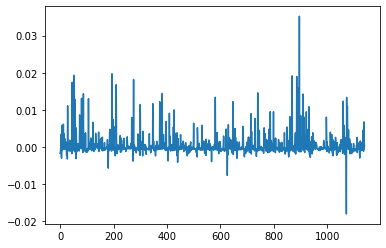

In [499]:
df_trades.roi.plot()

<AxesSubplot:>

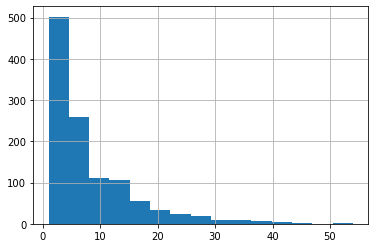

In [500]:
df_trades.tim.hist(bins=15)

In [501]:
df.ema_m04 > df.ema_m10 * 1.10

timestamp
2021-02-23 14:53:00-05:00    False
2021-02-23 14:54:00-05:00    False
2021-02-23 14:55:00-05:00    False
2021-02-23 14:56:00-05:00    False
2021-02-23 14:57:00-05:00    False
                             ...  
2022-02-23 14:49:00-05:00    False
2022-02-23 14:50:00-05:00    False
2022-02-23 14:51:00-05:00    False
2022-02-23 14:52:00-05:00    False
2022-02-23 14:53:00-05:00    False
Length: 98744, dtype: bool

In [502]:
df_copy = df.copy()
df_copy.index = df_copy.index.strftime("%Y-%m-%d %H:%M:%S")
# df_copy.index = df_copy.index.tz_convert('utc')
df_copy.to_excel(results_path/'aapl_data.xlsx')

In [503]:
df_copy

,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,pct_chg_log_vwap,vol_m02,vol_m03,vol_m04,vol_m05,vol_m06,vol_m07,vol_m08,vol_m09,vol_m10,vol_m12,vol_m15,vol_m20,vol_m30,vol_m45,vol_m60,vol_m90,vol_m120,pct_chg_log_m05,pct_chg_log_m10,pct_chg_log_m15,pct_chg_log_m20,pct_chg_log_m30,pct_chg_log_m60,pct_chg_log_m120,ema_m02,ema_m03,ema_m04,ema_m05,ema_m06,ema_m07,ema_m08,ema_m09,ema_m10,ema_m12,ema_m15,ema_m20,ema_m30,ema_m45,ema_m60,ema_m90,ema_m120,signal,group,cnt,rule
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-23 14:53:00,0,124.33662,124.51059,124.33662,124.49021,195783.0,1524.0,124.42225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2021-02-23 14:54:00,0,124.50065,124.71935,124.43106,124.51059,405771.0,3981.0,124.56620,0.00016,0.00116,300777.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.50549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2021-02-23 14:55:00,0,124.50562,124.64976,124.36147,124.61994,318135.0,2523.0,124.49287,0.00088,-0.00059,361953.0,318135.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.58472,124.57016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2021-02-23 14:56:00,0,124.62978,124.64976,124.53047,124.59508,198209.0,1607.0,124.59389,-0.00020,0.00081,258172.0,318135.0,258172.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.59172,124.58345,124.57755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2021-02-23 14:57:00,0,124.60006,124.67461,124.56526,124.62004,247390.0,2036.0,124.62035,0.00020,0.00021,222799.5,247390.0,282762.5,247390.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.61068,124.60234,124.59598,124.59134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-23 14:49:00,0,161.25000,161.32000,161.08000,161.08000,122210.0,1571.0,161.18814,-0.00105,-0.00016,140445.5,141440.0,137104.0,141440.0,137104.0,141440.0,150060.5,158681.0,169170.0,150060.5,141440.0,132118.0,146630.0,140379.0,136757.5,130660.0,127263.0,0.00130,-0.00093,-0.00105,-0.00217,-0.00637,-0.00908,-0.01558,161.12493,161.12761,161.11788,161.10699,161.09859,161.09348,161.09151,161.09227,161.09533,161.10689,161.13350,161.19039,161.31369,161.48354,161.63446,161.89649,162.11548,0,2283,0,0
2022-02-23 14:50:00,0,161.08100,161.11000,160.96490,161.03000,134942.0,1515.0,161.02582,-0.00031,-0.00101,128576.0,134942.0,138191.0,134942.0,138191.0,134942.0,138191.0,141440.0,150060.5,150060.5,141440.0,133855.0,146630.0,134942.0,135389.5,130660.0,127263.0,0.00022,-0.00036,-0.00155,-0.00269,-0.00639,-0.00890,-0.01442,161.06164,161.07880,161.08273,161.08133,161.07899,161.07761,161.07784,161.07981,161.08345,161.09506,161.12056,161.17512,161.29539,161.46382,161.61464,161.87745,162.09754,0,2283,0,0
2022-02-23 14:51:00,0,161.02500,161.16000,160.99000,161.04000,101811.0,1312.0,161.06647,0.00006,0.00025,118376.5,122210.0,128576.0,134942.0,133855.0,134942.0,133855.0,134942.0,138191.0,150060.5,141440.0,133855.0,140909.5,132768.0,133855.0,130660.0,126530.0,-0.00012,0.00075,-0.00150,-0.00180,-0.00570,-0.00826,-0.01467,161.04721,161.05940,161.06564,161.06755,161.06785,161.06821,161.06943,161.07185,161.07555,161.08659,161.11049,161.16225,161.27891,161.44539,161.59580,161.85905,162.08006,0,2283,0,0


In [416]:
buy_rules = ['df.ema_m05 > df.ema_m15']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(60)

NameError: name 'apply_buy_rules' is not defined

In [504]:
buy_rules = ['df.ema_m04 > df.ema_m10','df.ema_m09 > df.ema_m20','df.ema_m30 > df.ema_m90']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(60)

roi: 42.65%, tim_1: 10.06%, tim_2: 6.67%, tim_3: 7.47%, tim_4: 6.51%, tim_5: 6.23%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
2445,2022-02-09 11:51:00-05:00,2022-02-09 11:52:00-05:00,2,175.67891,175.52701,-0.00087,175.5300,175.7186,0.99916
2446,2022-02-09 12:27:00-05:00,2022-02-09 12:29:00-05:00,3,175.64380,175.51731,-0.00072,175.4500,175.6700,0.99938
2447,2022-02-09 12:37:00-05:00,2022-02-09 12:43:00-05:00,7,175.79394,175.60609,-0.00107,175.5801,175.8800,0.99869
2448,2022-02-09 12:49:00-05:00,2022-02-09 12:49:00-05:00,1,175.70392,175.61608,-0.00050,175.6150,175.6700,0.99994
2449,2022-02-09 12:52:00-05:00,2022-02-09 13:09:00-05:00,18,175.72392,175.73605,0.00007,175.6000,175.9200,0.99920
2450,2022-02-09 13:45:00-05:00,2022-02-09 13:50:00-05:00,6,175.74392,175.65108,-0.00053,175.6700,175.8300,0.99923
2451,2022-02-09 14:02:00-05:00,2022-02-09 14:16:00-05:00,15,175.76393,175.83013,0.00038,175.6900,176.0500,0.99900
2452,2022-02-09 14:28:00-05:00,2022-02-09 14:34:00-05:00,7,175.96898,175.82603,-0.00081,175.8101,176.0000,0.99926
2453,2022-02-09 14:36:00-05:00,2022-02-09 14:45:00-05:00,10,176.01399,175.91601,-0.00056,175.8600,176.1200,0.99909
2454,2022-02-09 15:46:00-05:00,2022-02-09 15:57:00-05:00,12,175.85395,175.96600,0.00064,175.6300,176.3200,0.99824


In [364]:
buy_rules = ['df.ema_m05 > df.ema_m07', 'df.ema_m07 > df.ema_m15', 'df.ema_m60 > df.ema_m120','df.ema_m10 > df.ema_m30']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 37.97%, tim_1: 9.91%, tim_2: 6.92%, tim_3: 7.62%, tim_4: 6.27%, tim_5: 6.92%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
2291,2022-02-15 11:30:00-05:00,2022-02-15 11:31:00-05:00,2,171.57968,171.47212,-0.00063,171.4600,171.590,0.99956
2292,2022-02-15 11:33:00-05:00,2022-02-15 11:40:00-05:00,8,171.54288,171.46712,-0.00044,171.4300,171.680,0.99901
2293,2022-02-15 11:42:00-05:00,2022-02-15 11:42:00-05:00,1,171.59289,171.50711,-0.00050,171.4850,171.550,1.00000
2294,2022-02-15 11:56:00-05:00,2022-02-15 12:03:00-05:00,8,171.58289,171.44763,-0.00079,171.4700,171.720,0.99866
2295,2022-02-15 13:23:00-05:00,2022-02-15 13:35:00-05:00,13,171.55788,171.68207,0.00072,171.4200,172.040,0.99817
2296,2022-02-15 13:49:00-05:00,2022-02-15 13:52:00-05:00,4,171.77293,171.66207,-0.00065,171.6600,171.815,0.99936
2297,2022-02-15 13:54:00-05:00,2022-02-15 14:03:00-05:00,10,171.81924,171.71706,-0.00059,171.7000,171.880,0.99930
2298,2022-02-15 14:15:00-05:00,2022-02-15 14:15:00-05:00,1,171.74293,171.65707,-0.00050,171.7000,171.780,0.99953
2299,2022-02-15 14:17:00-05:00,2022-02-15 14:33:00-05:00,17,171.78294,171.74705,-0.00021,171.5700,171.890,0.99942
2300,2022-02-15 14:35:00-05:00,2022-02-15 14:50:00-05:00,16,171.92297,171.96700,0.00026,171.7688,172.270,0.99849


In [366]:
buy_rules = ['df.ema_m03 > df.ema_m09', 'df.ema_m05 > df.ema_m15', 'df.ema_m10 > df.ema_m30']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 65.39%, tim_1: 11.16%, tim_2: 8.43%, tim_3: 7.98%, tim_4: 7.18%, tim_5: 6.79%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
3753,2022-02-15 15:19:00-05:00,2022-02-15 15:21:00-05:00,3,172.28806,172.14195,-0.00085,172.1450,172.290,0.99939
3754,2022-02-15 15:47:00-05:00,2022-02-15 15:47:00-05:00,1,172.22575,172.13965,-0.00050,172.0500,172.205,0.99987
3755,2022-02-15 15:49:00-05:00,2022-02-15 16:00:00-05:00,12,172.18303,172.63683,0.00263,171.9600,172.960,0.99838
3756,2022-02-16 10:26:00-05:00,2022-02-16 10:37:00-05:00,12,170.80269,170.63713,-0.00097,170.5700,170.850,0.99900
3757,2022-02-16 10:42:00-05:00,2022-02-16 10:59:00-05:00,18,170.81279,170.99724,0.00108,170.5500,171.220,0.99895
3758,2022-02-16 11:02:00-05:00,2022-02-16 11:04:00-05:00,3,171.14948,171.09721,-0.00031,171.0300,171.170,0.99982
3759,2022-02-16 11:32:00-05:00,2022-02-16 11:35:00-05:00,4,170.89271,170.76550,-0.00074,170.7399,170.880,0.99958
3760,2022-02-16 11:37:00-05:00,2022-02-16 11:42:00-05:00,6,170.85770,170.78729,-0.00041,170.7700,170.940,0.99936
3761,2022-02-16 11:49:00-05:00,2022-02-16 12:08:00-05:00,20,170.90272,171.17400,0.00159,170.8050,171.410,0.99887
3762,2022-02-16 12:56:00-05:00,2022-02-16 12:59:00-05:00,4,170.76268,170.63233,-0.00076,170.6600,170.770,0.99944


In [368]:
buy_rules = ['df.ema_m03 > df.ema_m09', 'df.ema_m05 > df.ema_m15', 'df.ema_m10 > df.ema_m30']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 65.39%, tim_1: 11.16%, tim_2: 8.43%, tim_3: 7.98%, tim_4: 7.18%, tim_5: 6.79%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
3753,2022-02-15 15:19:00-05:00,2022-02-15 15:21:00-05:00,3,172.28806,172.14195,-0.00085,172.1450,172.290,0.99939
3754,2022-02-15 15:47:00-05:00,2022-02-15 15:47:00-05:00,1,172.22575,172.13965,-0.00050,172.0500,172.205,0.99987
3755,2022-02-15 15:49:00-05:00,2022-02-15 16:00:00-05:00,12,172.18303,172.63683,0.00263,171.9600,172.960,0.99838
3756,2022-02-16 10:26:00-05:00,2022-02-16 10:37:00-05:00,12,170.80269,170.63713,-0.00097,170.5700,170.850,0.99900
3757,2022-02-16 10:42:00-05:00,2022-02-16 10:59:00-05:00,18,170.81279,170.99724,0.00108,170.5500,171.220,0.99895
3758,2022-02-16 11:02:00-05:00,2022-02-16 11:04:00-05:00,3,171.14948,171.09721,-0.00031,171.0300,171.170,0.99982
3759,2022-02-16 11:32:00-05:00,2022-02-16 11:35:00-05:00,4,170.89271,170.76550,-0.00074,170.7399,170.880,0.99958
3760,2022-02-16 11:37:00-05:00,2022-02-16 11:42:00-05:00,6,170.85770,170.78729,-0.00041,170.7700,170.940,0.99936
3761,2022-02-16 11:49:00-05:00,2022-02-16 12:08:00-05:00,20,170.90272,171.17400,0.00159,170.8050,171.410,0.99887
3762,2022-02-16 12:56:00-05:00,2022-02-16 12:59:00-05:00,4,170.76268,170.63233,-0.00076,170.6600,170.770,0.99944


In [369]:
buy_rules = ['df.ema_m05 > df.ema_m30']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 39.89%, tim_1: 9.95%, tim_2: 6.92%, tim_3: 6.13%, tim_4: 4.74%, tim_5: 4.06%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
2493,2022-02-15 11:53:00-05:00,2022-02-15 12:04:00-05:00,12,171.58789,171.42713,-0.00094,171.3813,171.7200,0.99854
2494,2022-02-15 13:03:00-05:00,2022-02-15 14:05:00-05:00,63,170.79269,171.52211,0.00426,170.7018,172.0400,0.99724
2495,2022-02-15 14:14:00-05:00,2022-02-15 14:52:00-05:00,39,171.80294,171.75975,-0.00025,171.5700,172.2700,0.99729
2496,2022-02-15 14:57:00-05:00,2022-02-15 15:26:00-05:00,30,171.99799,172.06197,0.00037,171.8300,172.3600,0.99852
2497,2022-02-15 15:28:00-05:00,2022-02-15 15:29:00-05:00,2,172.20304,172.14695,-0.00033,172.1100,172.2121,0.99987
2498,2022-02-15 15:44:00-05:00,2022-02-16 09:30:00-05:00,18,172.26716,171.72706,-0.00314,171.7400,172.9600,0.99312
2499,2022-02-16 10:22:00-05:00,2022-02-16 10:22:00-05:00,1,170.72767,170.64233,-0.00050,170.6518,170.7500,0.99962
2500,2022-02-16 10:24:00-05:00,2022-02-16 10:38:00-05:00,15,170.72767,170.53286,-0.00114,170.5500,170.8500,0.99839
2501,2022-02-16 10:40:00-05:00,2022-02-16 10:40:00-05:00,1,170.73647,170.65113,-0.00050,170.5900,170.7100,0.99991
2502,2022-02-16 10:42:00-05:00,2022-02-16 11:11:00-05:00,30,170.81279,170.97605,0.00096,170.5500,171.2200,0.99882


In [371]:
buy_rules = ['df.ema_m05 > df.ema_m07', 'df.ema_m07 > df.ema_m15', 'df.ema_m15 > df.ema_m90','df.ema_m20 > df.ema_m60']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 46.64%, tim_1: 9.95%, tim_2: 6.87%, tim_3: 7.84%, tim_4: 6.02%, tim_5: 6.59%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
2773,2022-02-15 11:56:00-05:00,2022-02-15 12:03:00-05:00,8,171.58289,171.44763,-0.00079,171.4700,171.720,0.99866
2774,2022-02-15 13:16:00-05:00,2022-02-15 13:35:00-05:00,20,171.11277,171.68207,0.00332,171.0018,172.040,0.99817
2775,2022-02-15 13:49:00-05:00,2022-02-15 13:52:00-05:00,4,171.77293,171.66207,-0.00065,171.6600,171.815,0.99936
2776,2022-02-15 13:54:00-05:00,2022-02-15 14:03:00-05:00,10,171.81924,171.71706,-0.00059,171.7000,171.880,0.99930
2777,2022-02-15 14:14:00-05:00,2022-02-15 14:15:00-05:00,2,171.80294,171.65707,-0.00085,171.6900,171.780,0.99953
2778,2022-02-15 14:17:00-05:00,2022-02-15 14:33:00-05:00,17,171.78294,171.74705,-0.00021,171.5700,171.890,0.99942
2779,2022-02-15 14:35:00-05:00,2022-02-15 14:50:00-05:00,16,171.92297,171.96700,0.00026,171.7688,172.270,0.99849
2780,2022-02-15 14:59:00-05:00,2022-02-15 15:14:00-05:00,16,172.02800,172.20924,0.00105,171.9228,172.360,0.99938
2781,2022-02-15 15:20:00-05:00,2022-02-15 15:20:00-05:00,1,172.26306,172.17695,-0.00050,172.2100,172.290,0.99959
2782,2022-02-15 15:44:00-05:00,2022-02-15 16:00:00-05:00,17,172.26716,172.63683,0.00214,171.9450,172.960,0.99838


<AxesSubplot:>

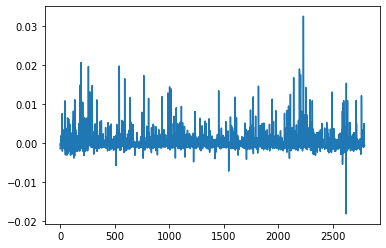

In [372]:
df_trades.roi.plot()

<AxesSubplot:>

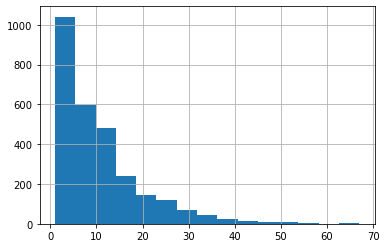

In [373]:
df_trades.tim.hist(bins=15)

In [374]:
buy_rules = ['df.ema_m02 > df.ema_m07', 'df.ema_m07 > df.ema_m15', 'df.ema_m15 > df.ema_m90', 'df.vol_m30 > df.vol_m120']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 62.09%, tim_1: 18.12%, tim_2: 13.59%, tim_3: 11.58%, tim_4: 8.12%, tim_5: 7.55%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
1569,2022-02-14 15:44:00-05:00,2022-02-14 15:44:00-05:00,1,169.02224,168.93775,-0.00050,168.7800,169.0200,0.99976
1570,2022-02-14 15:48:00-05:00,2022-02-14 15:49:00-05:00,2,169.15228,169.05773,-0.00056,168.8200,169.3100,0.99876
1571,2022-02-14 16:00:00-05:00,2022-02-15 09:48:00-05:00,20,168.92222,171.10721,0.01285,168.7000,171.4506,0.99825
1572,2022-02-15 09:54:00-05:00,2022-02-15 09:54:00-05:00,1,171.13277,171.04723,-0.00050,170.9700,171.1500,0.99965
1573,2022-02-15 09:57:00-05:00,2022-02-15 09:57:00-05:00,1,171.11907,171.03353,-0.00050,170.8800,171.1600,0.99951
1574,2022-02-15 13:26:00-05:00,2022-02-15 13:32:00-05:00,7,171.77903,171.87202,0.00054,171.6800,172.0400,0.99927
1575,2022-02-15 13:40:00-05:00,2022-02-15 13:40:00-05:00,1,171.80094,171.71506,-0.00050,171.6946,171.7700,0.99993
1576,2022-02-15 13:48:00-05:00,2022-02-15 13:51:00-05:00,4,171.76293,171.66707,-0.00056,171.6700,171.8150,0.99939
1577,2022-02-15 13:54:00-05:00,2022-02-15 13:55:00-05:00,2,171.81924,171.71206,-0.00062,171.7000,171.7900,0.99980
1578,2022-02-15 14:59:00-05:00,2022-02-15 15:14:00-05:00,16,172.02800,172.20924,0.00105,171.9228,172.3600,0.99938


<AxesSubplot:>

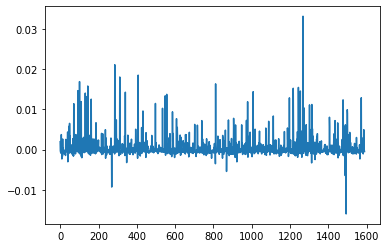

In [375]:
df_trades.roi.plot()

<AxesSubplot:>

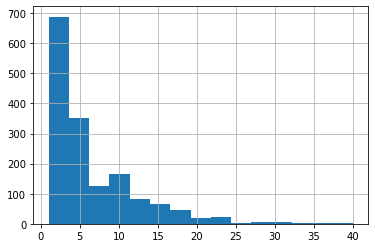

In [376]:
df_trades.tim.hist(bins=15)

In [377]:
buy_rules = ['df.ema_m02 > df.ema_m07', 'df.ema_m07 > df.ema_m20', 'df.ema_m20 > df.ema_m60', 'df.vol_m60 > df.vol_m120']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 66.21%, tim_1: 18.07%, tim_2: 13.88%, tim_3: 9.79%, tim_4: 8.67%, tim_5: 7.33%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
1767,2022-02-14 15:22:00-05:00,2022-02-14 15:28:00-05:00,7,168.61224,168.63783,0.00015,168.4000,169.1289,0.99735
1768,2022-02-14 16:00:00-05:00,2022-02-15 09:48:00-05:00,20,168.92222,171.10721,0.01285,168.7000,171.4506,0.99825
1769,2022-02-15 09:54:00-05:00,2022-02-15 09:54:00-05:00,1,171.13277,171.04723,-0.00050,170.9700,171.1500,0.99965
1770,2022-02-15 09:57:00-05:00,2022-02-15 09:57:00-05:00,1,171.11907,171.03353,-0.00050,170.8800,171.1600,0.99951
1771,2022-02-15 10:15:00-05:00,2022-02-15 10:20:00-05:00,6,170.99774,170.95955,-0.00022,170.8300,171.1784,0.99897
1772,2022-02-15 10:23:00-05:00,2022-02-15 10:24:00-05:00,2,171.05775,170.94995,-0.00063,170.9350,171.0800,0.99949
1773,2022-02-15 10:27:00-05:00,2022-02-15 10:28:00-05:00,2,171.07276,170.95225,-0.00070,170.8650,171.1700,0.99898
1774,2022-02-15 13:21:00-05:00,2022-02-15 13:32:00-05:00,12,171.48366,171.87202,0.00226,171.2000,172.0400,0.99927
1775,2022-02-15 13:40:00-05:00,2022-02-15 13:40:00-05:00,1,171.80094,171.71506,-0.00050,171.6946,171.7700,0.99993
1776,2022-02-15 13:48:00-05:00,2022-02-15 13:50:00-05:00,3,171.76293,171.69707,-0.00038,171.6700,171.8150,0.99956


<AxesSubplot:>

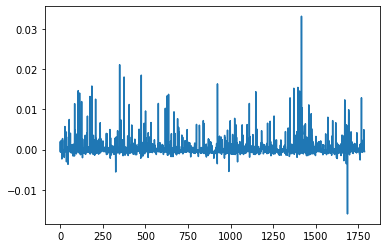

In [378]:
df_trades.roi.plot()

<AxesSubplot:>

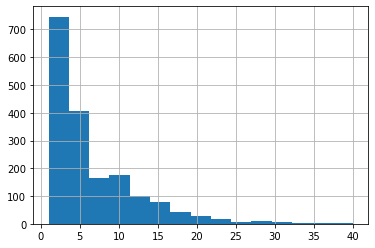

In [379]:
df_trades.tim.hist(bins=15)

In [380]:
buy_rules = ['df.ema_m03 > df.ema_m05', 'df.ema_m05 > df.ema_m15']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 99.31%, tim_1: 14.2%, tim_2: 11.14%, tim_3: 9.94%, tim_4: 9.76%, tim_5: 8.1%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
5706,2022-02-16 11:02:00-05:00,2022-02-16 11:04:00-05:00,3,171.14948,171.09721,-3.05404e-04,171.0300,171.1700,0.99982
5707,2022-02-16 11:28:00-05:00,2022-02-16 11:33:00-05:00,6,170.85630,170.76730,-5.21076e-04,170.7200,170.9400,0.99924
5708,2022-02-16 11:38:00-05:00,2022-02-16 11:42:00-05:00,5,170.92272,170.78729,-7.92646e-04,170.8070,170.9400,0.99936
5709,2022-02-16 11:49:00-05:00,2022-02-16 12:06:00-05:00,18,170.90272,171.19719,1.72157e-03,170.8050,171.4100,0.99901
5710,2022-02-16 12:43:00-05:00,2022-02-16 12:58:00-05:00,16,170.72267,170.69232,-1.77811e-04,170.5400,170.7773,0.99975
5711,2022-02-16 13:07:00-05:00,2022-02-16 13:10:00-05:00,4,170.76768,170.62733,-8.22207e-04,170.6437,170.7600,0.99947
5712,2022-02-16 13:14:00-05:00,2022-02-16 13:25:00-05:00,12,170.75268,170.75230,-2.20348e-06,170.6550,170.8950,0.99941
5713,2022-02-16 13:27:00-05:00,2022-02-16 13:30:00-05:00,4,170.85270,170.78229,-4.12187e-04,170.7500,170.8700,0.99974
5714,2022-02-16 13:46:00-05:00,2022-02-16 13:47:00-05:00,2,170.81269,170.67232,-8.22123e-04,170.6800,170.8200,0.99939
5715,2022-02-16 13:49:00-05:00,2022-02-16 13:52:00-05:00,4,170.76848,170.73730,-1.82582e-04,170.6700,170.8700,0.99947


<AxesSubplot:>

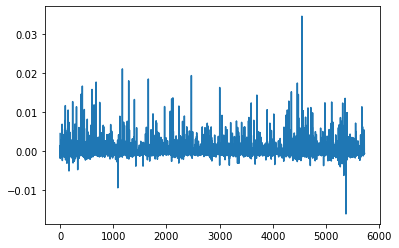

In [381]:
df_trades.roi.plot()

<AxesSubplot:>

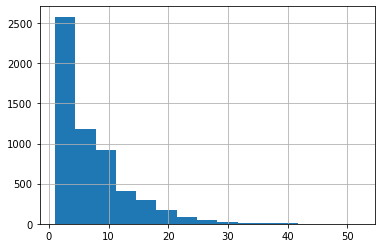

In [382]:
df_trades.tim.hist(bins=15)

In [383]:
buy_rules = ['df.pct_chg_log_m15 > 0.002', 'df.ema_m03 > df.ema_m05', 'df.ema_m05 > df.ema_m10', 'df.vol_m60 > df.vol_m120']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 39.11%, tim_1: 33.04%, tim_2: 15.84%, tim_3: 10.43%, tim_4: 8.7%, tim_5: 5.53%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
1590,2022-02-14 10:23:00-05:00,2022-02-14 10:24:00-05:00,2,168.57923,168.48787,-0.00054,168.1200,168.7500,0.99870
1591,2022-02-14 14:21:00-05:00,2022-02-14 14:21:00-05:00,1,167.19169,167.10811,-0.00050,167.0500,167.2900,0.99916
1592,2022-02-14 14:28:00-05:00,2022-02-14 14:32:00-05:00,5,167.43185,167.41814,-0.00008,166.6600,167.8100,0.99791
1593,2022-02-14 14:34:00-05:00,2022-02-14 14:41:00-05:00,8,167.92197,167.84803,-0.00044,167.3700,168.1200,0.99863
1594,2022-02-14 14:45:00-05:00,2022-02-14 14:47:00-05:00,3,167.91187,167.77305,-0.00083,167.6700,168.0450,0.99863
1595,2022-02-14 14:51:00-05:00,2022-02-14 14:53:00-05:00,3,168.51212,168.12796,-0.00228,168.1200,168.5600,0.99769
1596,2022-02-14 15:00:00-05:00,2022-02-14 15:00:00-05:00,1,168.31207,168.22793,-0.00050,168.1100,168.3000,0.99982
1597,2022-02-14 15:13:00-05:00,2022-02-14 15:16:00-05:00,4,168.54213,168.39289,-0.00089,168.2400,168.7481,0.99814
1598,2022-02-14 15:18:00-05:00,2022-02-14 15:18:00-05:00,1,168.49211,168.40789,-0.00050,168.2900,168.5700,0.99929
1599,2022-02-14 15:22:00-05:00,2022-02-14 15:27:00-05:00,6,168.61224,168.66782,0.00033,168.4000,169.1289,0.99752


<AxesSubplot:>

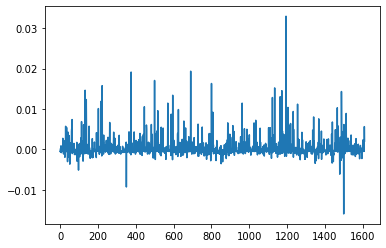

In [384]:
df_trades.roi.plot()

<AxesSubplot:>

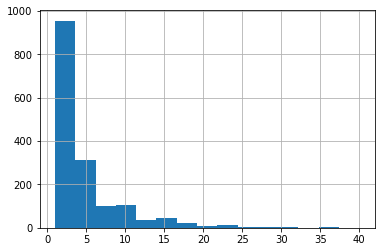

In [385]:
df_trades.tim.hist(bins=15)

In [386]:
buy_rules = ['df.ema_m03 > df.ema_m05','df.ema_m05 > df.ema_m15', 'df.ema_m15 > df.ema_m30', 'df.vol_m30 > df.vol_m120']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 52.02%, tim_1: 16.99%, tim_2: 12.75%, tim_3: 11.29%, tim_4: 9.42%, tim_5: 7.62%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
1752,2022-02-14 15:27:00-05:00,2022-02-14 15:28:00-05:00,2,168.75218,168.63783,-0.00068,168.5600,168.8000,0.99929
1753,2022-02-14 15:32:00-05:00,2022-02-14 15:41:00-05:00,10,168.86721,168.81769,-0.00029,168.5499,169.0300,0.99899
1754,2022-02-14 15:44:00-05:00,2022-02-14 15:44:00-05:00,1,169.02224,168.93775,-0.00050,168.7800,169.0200,0.99976
1755,2022-02-14 15:48:00-05:00,2022-02-14 15:49:00-05:00,2,169.15228,169.05773,-0.00056,168.8200,169.3100,0.99876
1756,2022-02-15 09:30:00-05:00,2022-02-15 09:48:00-05:00,19,170.71267,171.10721,0.00231,170.2500,171.4506,0.99825
1757,2022-02-15 09:54:00-05:00,2022-02-15 09:54:00-05:00,1,171.13277,171.04723,-0.00050,170.9700,171.1500,0.99965
1758,2022-02-15 13:26:00-05:00,2022-02-15 13:32:00-05:00,7,171.77903,171.87202,0.00054,171.6800,172.0400,0.99927
1759,2022-02-15 13:40:00-05:00,2022-02-15 13:40:00-05:00,1,171.80094,171.71506,-0.00050,171.6946,171.7700,0.99993
1760,2022-02-15 13:48:00-05:00,2022-02-15 13:51:00-05:00,4,171.76293,171.66707,-0.00056,171.6700,171.8150,0.99939
1761,2022-02-15 13:54:00-05:00,2022-02-15 13:55:00-05:00,2,171.81924,171.71206,-0.00062,171.7000,171.7900,0.99980


<AxesSubplot:>

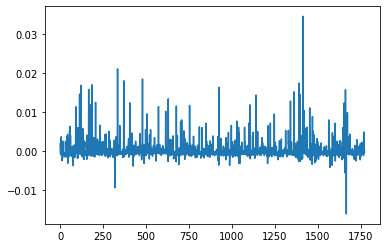

In [387]:
df_trades.roi.plot()

<AxesSubplot:>

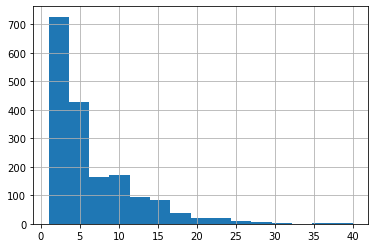

In [388]:
df_trades.tim.hist(bins=15)

In [389]:
buy_rules = ['df.pct_chg_log_m15 > 0.0005','df.ema_m03 > df.ema_m05','df.ema_m05 > df.ema_m15', 'df.ema_m15 > df.ema_m30', 'df.vol_m30 > df.vol_m120']
df,df_trades = backtest_strategy(df,buy_rules)
print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')
df_trades.tail(20)

roi: 44.27%, tim_1: 25.83%, tim_2: 12.43%, tim_3: 11.45%, tim_4: 9.32%, tim_5: 6.62%


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,peak_sale
1718,2022-02-14 14:50:00-05:00,2022-02-14 14:55:00-05:00,6,168.31207,168.11796,-0.00115,167.7500,168.5600,0.99763
1719,2022-02-14 15:27:00-05:00,2022-02-14 15:28:00-05:00,2,168.75218,168.63783,-0.00068,168.5600,168.8000,0.99929
1720,2022-02-14 15:32:00-05:00,2022-02-14 15:37:00-05:00,6,168.86721,168.82178,-0.00027,168.5499,168.9900,0.99925
1721,2022-02-14 15:39:00-05:00,2022-02-14 15:41:00-05:00,3,168.91722,168.81769,-0.00059,168.8000,169.0300,0.99899
1722,2022-02-14 15:44:00-05:00,2022-02-14 15:44:00-05:00,1,169.02224,168.93775,-0.00050,168.7800,169.0200,0.99976
1723,2022-02-14 15:48:00-05:00,2022-02-14 15:49:00-05:00,2,169.15228,169.05773,-0.00056,168.8200,169.3100,0.99876
1724,2022-02-15 09:30:00-05:00,2022-02-15 09:48:00-05:00,19,170.71267,171.10721,0.00231,170.2500,171.4506,0.99825
1725,2022-02-15 09:54:00-05:00,2022-02-15 09:54:00-05:00,1,171.13277,171.04723,-0.00050,170.9700,171.1500,0.99965
1726,2022-02-15 13:26:00-05:00,2022-02-15 13:32:00-05:00,7,171.77903,171.87202,0.00054,171.6800,172.0400,0.99927
1727,2022-02-15 15:02:00-05:00,2022-02-15 15:02:00-05:00,1,172.19304,172.10696,-0.00050,172.0800,172.2000,0.99971


<AxesSubplot:>

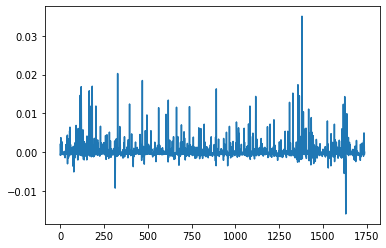

In [390]:
df_trades.roi.plot()

<AxesSubplot:>

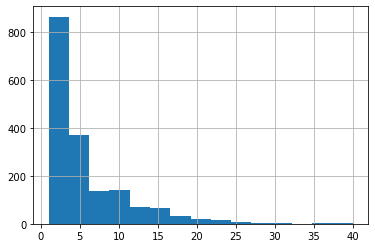

In [391]:
df_trades.tim.hist(bins=15)

In [392]:
df_trades.set_index('buy_ts').groupby(pd.Grouper(freq='D')).roi.sum()

buy_ts
2021-02-17 00:00:00-05:00    0.00194
2021-02-18 00:00:00-05:00    0.00093
2021-02-19 00:00:00-05:00   -0.00446
2021-02-20 00:00:00-05:00    0.00000
2021-02-21 00:00:00-05:00    0.00000
                              ...   
2022-02-12 00:00:00-05:00    0.00000
2022-02-13 00:00:00-05:00    0.00000
2022-02-14 00:00:00-05:00   -0.00629
2022-02-15 00:00:00-05:00    0.00219
2022-02-16 00:00:00-05:00    0.00921
Freq: D, Name: roi, Length: 365, dtype: float64

### buy rules generator + backtester v4

In [135]:
df_top_market = top_market_cap()
df_top_market = df_top_market[df_top_market.price < 500]

version = 1.77

period_list = [4,6,8,10,12,20,30,40,60,90]
volume_list = [None,10,20,30,40,60]
cmf_list = [None,10,20,30]
rsi_list = [None,6,9,14]
stock_inc_list = [None] + np.arange(1,4).tolist()
verbose = False # if we want print readouts for every buy_rule
print_interval = 1000 # tracks total buy_rule results acquired
total_rules = 14079
slippage = 0.0003 # 0.03% ask/bid spread

# create bin for cutting roi trade distribution; -1,-0.02,-0.018,-0.016,...,1
bin_list = [-1]
val = -0.02
for i in range(21):
    bin_list.append(round(val,5))
    val = val+0.002

bin_list.append(1)

for symbol in df_top_market.symbol[:20]:
    item_match_list = [item for item in results_path.listdir() if f'results_v{version}_{symbol}.csv' in item]
    
    if len(item_match_list) > 0:
        print(f'results file found -- symbol: {symbol}, version: {version}; moving to next symbol')
        continue
    
    df = stock_alpaca(symbol,months_of_data=12)

    # volume MAs
    periods_per_scale = 1 # 12
    for period in period_list[1:]:
        df[f'vol_m{str(period).zfill(2)}'] = df.volume.rolling(period*periods_per_scale).mean()

    # pct chg log across various timeframes
    for period in period_list[1:]:
        df[f'pct_chg_log_m{str(period).zfill(2)}'] = df.pct_chg_log.rolling(period*periods_per_scale).sum()

    # ema adjust
    df = ema_adjust(df,scale='1m',period_list=period_list)
    df = cmf_adjust(df)
    df = macd_adjust(df)
    df = rsi_adjust(df)
    
    buy_rules_list = []
    results_list = []
    t0 = time.time()
    t1 = time.time()
    i = 0
    
    # buy and hold strat
    bh_roi = df.pct_chg_log.sum()
    bh_sharpe = (df.pct_chg_log.mean()/df.pct_chg_log.std())*np.sqrt(6.5*60*252)
    bh_sortino = (df.pct_chg_log.mean()/np.abs(df[df.pct_chg_log < 0].pct_chg_log.std()))*np.sqrt(6.5*60*252)
    print(f'buy and hold stats -- bh_roi: {round(bh_roi,2)}, bh_sharpe: {round(bh_sharpe,2)}, bh_sortino: {round(bh_sortino,2)}')
    # for chg_log_index in np.arange(len(period_list)-3):
    #     for chg_log_value in np.arange(0,0.004,0.001):
    for stock_index in np.arange(6):
        for stock_index_inc1 in stock_inc_list:
            for stock_index_inc2 in stock_inc_list:
                for stock_index_inc3 in stock_inc_list:
                    for vol_index in np.arange(len(volume_list)):
                        for vol_index_inc1 in np.arange(1,4):
                            for cmf in cmf_list:
                                for macd in [None,True]:
                                    #for rsi in rsi_list:
                                    #for conf in np.arange(1,4):
                                    buy_rules = []

                                    #if period_list[chg_log_index] != None:
                                    #    buy_rules.append(f'df.pct_chg_log_m{str(period_list[chg_log_index]).zfill(2)} > {chg_log_value}')
                                    #else:
                                    #    pass

                                    if period_list[stock_index] != None:
                                        if stock_index_inc1 != None:
                                            if stock_index+stock_index_inc1 < len(period_list):
                                                buy_rules.append(f'df.ema_m{str(period_list[stock_index]).zfill(2)} > df.ema_m{str(period_list[stock_index+stock_index_inc1]).zfill(2)}')
                                            else:
                                                pass

                                        if stock_index_inc1 != None and stock_index_inc2 != None:
                                            if stock_index+stock_index_inc1+stock_index_inc2 < len(period_list):
                                                buy_rules.append(f'df.ema_m{str(period_list[stock_index+stock_index_inc1]).zfill(2)} > df.ema_m{str(period_list[stock_index+stock_index_inc1+stock_index_inc2]).zfill(2)}')
                                            else:
                                                pass

                                        if stock_index_inc1 != None and stock_index_inc2 != None and stock_index_inc3 != None:
                                            if stock_index+stock_index_inc1+stock_index_inc2+stock_index_inc3 < len(period_list):
                                                buy_rules.append(f'df.ema_m{str(period_list[stock_index+stock_index_inc1+stock_index_inc2]).zfill(2)} > df.ema_m{str(period_list[stock_index+stock_index_inc1+stock_index_inc2+stock_index_inc3]).zfill(2)}')
                                            else:
                                                pass

                                    if volume_list[vol_index] != None:
                                        if vol_index+vol_index_inc1 < len(volume_list):
                                            buy_rules.append(f'df.vol_m{str(volume_list[vol_index]).zfill(2)} > df.vol_m{str(volume_list[vol_index+vol_index_inc1]).zfill(2)}')

                                    if cmf != None:
                                        buy_rules.append(f'df.cmf_m{str(cmf).zfill(2)} > 0')

                                    if macd != None:
                                        buy_rules.append(f'df.macd_delta > 0')

    #                                 if rsi != None:
    #                                     buy_rules.append(f'df.rsi_d{str(rsi).zfill(2)} < 70')



                                    #if len(buy_rules) > 0:
                                    #    buy_rules.append(f'df.cnt >= {conf}')
                                    #else:
                                    #    continue
                                    if len(buy_rules) == 0:
                                        continue

                                    if buy_rules not in buy_rules_list:
                                        buy_rules_list.append(buy_rules)
                                        i += 1

                                        if i % print_interval == 0:
                                            print(i,str(buy_rules))

                                        # if i % print_interval == 0:
                                        #    print(i,str(buy_rules))

                                        # analyze buy_rules performance
                                        # df['signal'] = (df[f'pct_chg_log_m{chg_log_period}'] > chg_log_value)*1
                                        # print([rule for rule in buy_rules if 'cnt' not in rule])

        #                                         df['signal'] = (pd.eval('&'.join([rule for rule in buy_rules if 'cnt' not in rule])))*1
        #                                         df['group'] = (df['signal'] != df['signal'].shift()).cumsum()
        #                                         df['cnt'] = df.groupby('group')['signal'].cumsum()

        #                                         df['rule'] = df['signal'] & (df['cnt'] >= conf)*1
                                        # buy_rule = f'df.pct_chg_log_m{chg_log_period} > {chg_log_value} & df.cnt >= {conf_count}'            
                                        # df['rule2'] = pd.eval(buy_rule)*1

                                        df,df_trades = backtest_strategy(df,buy_rules,slippage)
                                        close_col = df.columns.get_loc('close')

                                        if df_trades.shape[0] > 0:
                                            #df_trades = pd.DataFrame(df[df['rule'] == 1].groupby('group').apply(lambda x: [x.index[0],x.index[-1],x.shape[0],x.iat[0,close_col],x.iat[-1,close_col],np.log(x.iat[-1,close_col]/x.iat[0,close_col]),x.iat[-1,close_col]/x['high'].max(),x['low'].min(),x['high'].max(),(x['low'].min()/x['high'].max()-1)]).to_list(),columns=['buy_ts','sell_ts','tim','buy_price','sell_price','roi','peak_timing','min','max','dd'])

                                            # 0.03% slippage of close is accounted for during buy/sell
                                            #df_trades = pd.DataFrame(df[df['rule'] == 1].groupby('group').apply(lambda x: [x.index[0],x.index[-1],x.shape[0],x.iat[0,close_col]*(1+slippage),x.iat[-1,close_col]*(1-slippage),np.log(x.iat[-1,close_col]/x.iat[0,close_col]),x['low'].min(),x['high'].max(),x['low'].min()/x['high'].max()-1]).to_list(),columns=['buy_ts','sell_ts','tim','buy_price','sell_price','roi','min','max','dd'])
                                            #onemin_tim_count = (df_trades.tim == 1).sum()
                                            #df_trades = df_trades[df_trades.tim > 1]

                                            if df_trades.shape[0] > 0:
                                                results_dict = {}

                                                # buy and hold stats
                                                results_dict.update({'symbol':symbol,'bh_roi':bh_roi,'bh_sharpe':bh_sharpe,'bh_sortino':bh_sortino})

                                                # rule info
                                                # results_dict.update({'chg_log_period':chg_log_period,'conf':conf,'chg_log_value':chg_log_value})
                                                results_dict.update({'rule_id':i,'buy_rules':buy_rules})

                                                # trade stats
                                                # results_dict.update({'trades':df_trades.shape[0],'win_pct':(df_trades.roi > 1).sum()/df_trades.shape[0],'tie_pct':(df_trades.roi == 1).sum()/df_trades.shape[0],'loss_pct':(df_trades.roi < 1).sum()/df_trades.shape[0]})
                                                results_dict.update({'trades':df_trades.shape[0],'win_pct':(df_trades.roi > 0).sum()/df_trades.shape[0],'tie_pct':(df_trades.roi == 0).sum()/df_trades.shape[0],'loss_pct':(df_trades.roi < 0).sum()/df_trades.shape[0]})

                                                #print(f'roi: {round(100*df_trades.roi.sum(),2)}%, tim_1: {round(100*df_trades[df_trades.tim == 1].shape[0]/df_trades.shape[0],2)}%, tim_2: {round(100*df_trades[df_trades.tim == 2].shape[0]/df_trades.shape[0],2)}%, tim_3: {round(100*df_trades[df_trades.tim == 3].shape[0]/df_trades.shape[0],2)}%, tim_4: {round(100*df_trades[df_trades.tim == 4].shape[0]/df_trades.shape[0],2)}%, tim_5: {round(100*df_trades[df_trades.tim == 5].shape[0]/df_trades.shape[0],2)}%')

                                                results_dict.update({'tim_1': (df_trades.tim == 1).sum()/df_trades.shape[0], 'tim_2': (df_trades.tim == 2).sum()/df_trades.shape[0], 'tim_3': (df_trades.tim == 3).sum()/df_trades.shape[0], 'tim_4': (df_trades.tim == 4).sum()/df_trades.shape[0], 'tim_5': (df_trades.tim == 5).sum()/df_trades.shape[0]})

                                                # time in market
                                                results_dict.update({'tim_min':df_trades.tim.min(),'tim_med':df_trades.tim.median(),'tim_max':df_trades.tim.max(),'tim_total':df_trades.tim.sum(),'roi_per_min':df_trades.roi.sum()/df_trades.tim.sum()})

                                                # roi stats
                                                #results_dict.update({'roi_total':df_trades.roi.sum(),'gross_win':df_trades[df_trades.roi > 0].roi.sum(),'gross_loss':df_trades[df_trades.roi < 0].roi.sum(),'roi_mean':df_trades.roi.mean(),'roi_std':df_trades.roi.std(),'sharpe':df_trades.roi.mean()/df_trades.roi.std(),'sortino1':df_trades.roi.mean()/np.abs(df_trades[df_trades.roi < 0].roi.std()),'sortino2':df_trades.roi.mean()/np.sqrt(np.square(df_trades[df_trades.roi < 0].roi).sum()/df_trades.shape[0]),'roi_per_trade':df_trades.roi.sum()/df_trades.shape[0]})
                                                results_dict.update({'roi_total':df_trades.roi.sum(),'gross_win':df_trades[df_trades.roi > 0].roi.sum(),'gross_loss':df_trades[df_trades.roi < 0].roi.sum(),'roi_trade_mean':df_trades.roi.mean(),'roi_trade_std':df_trades.roi.std(),'sharpe':df_trades.roi.mean()/df_trades.roi.std()})

                                                if df_trades[df_trades.roi < 0].shape[0] > 0:
                                                    #results_dict.update({'sortino':df_trades.roi.mean()/np.sqrt(np.square(df_trades[df_trades.roi < 0].roi).sum()/df_trades.shape[0])})
                                                    results_dict.update({'sortino':df_trades.roi.mean()/np.abs(df_trades[df_trades.roi < 0].roi.std())})
                                                else:
                                                    results_dict.update({'sortino':df_trades.roi.mean()/1})


                                                # for k,v in df_trades.roi.quantile(np.arange(0.00,1.1,0.1)).items():
                                                #    results_dict.update({f'roi_{round(k,2)}':v})

                                                # peak timing
                                                # for k,v in df_trades.peak_timing.quantile(np.arange(0.00,1.1,0.1)).items():
                                                #    results_dict.update({f'peak_{round(k,2)}':v})

                                                df_trades_monthly = df_trades.groupby(pd.Grouper(key='sell_ts',freq='M'))
                                                df_trades_monthly_roi = df_trades_monthly.roi.sum()
                                                df_trades_daily = df_trades.groupby(pd.Grouper(key='sell_ts',freq='B'))
                                                df_trades_daily_roi = df_trades_daily.roi.sum()

                                                # monthly stats
                                                results_dict.update({f'roi_mon_avg':df_trades_monthly_roi.mean(),f'roi_mon_std':df_trades_monthly_roi.std(),f'roi_mon_min':df_trades_monthly_roi.min(),f'roi_mon_med':df_trades_monthly_roi.median(),f'roi_mon_max':df_trades_monthly_roi.max()})

                                                # daily stats
                                                results_dict.update({f'roi_day_avg':df_trades_daily_roi.mean(),f'roi_day_std':df_trades_daily_roi.std(),f'roi_day_min':df_trades_daily_roi.min(),f'roi_day_med':df_trades_daily_roi.median(),f'roi_day_max':df_trades_daily_roi.max()})

                                                # monthly trade aggregate
                                                for k,v in df_trades_monthly.roi.count().items():
                                                    results_dict.update({f'trades_{k.year}{str(k.month).zfill(2)}':v})

                                                # monthly roi aggregate
                                                for k,v in df_trades_monthly_roi.items():
                                                    results_dict.update({f'roi_{k.year}{str(k.month).zfill(2)}':v})

                                                # drawdown
                                                #results_dict.update({'dd_min':df_trades.dd.min(),'dd_med':df_trades.dd.median()})

                                                # roi counts
                                                for k,v in df_trades.groupby(pd.cut(df_trades.roi,bin_list)).roi.count().items():
                                                    results_dict.update({k:v})

                                                results_list.append(results_dict)

                                                if verbose:
                                                    print(buy_rules)
                                                    print(f"trades: {results_dict['trades']}, win_pct: {round(100*results_dict['win_pct'],2)}%, tie_pct: {round(100*results_dict['tie_pct'],2)}%, loss_pct: {round(100*results_dict['loss_pct'],2)}%, roi_total: {round(results_dict['roi_total'],2)}, roi_per_trade: {round(results_dict['roi_per_trade']*100,4)}%, dd_min: {round(100*results_dict['dd_min'],2)}%")

                                                if i % print_interval == 0:
                                                    process_rate = len(results_list)/(time.time()-t0)
                                                    print(f'symbol: {symbol}, total backtests: {len(results_list)}, interval_time: {seconds_format(time.time()-t1)}, process_rate: {round(process_rate,2)}/s, total_time: {seconds_format(time.time()-t0)}, time_remaining: {seconds_format((total_rules-len(results_list))/process_rate)}, ({round(100*len(results_list)/total_rules,2)}%)')
                                                    t1 = time.time()

    df_results = pd.DataFrame(results_list)
    df_results.to_csv(results_path/f'results_v{version}_{symbol}.csv')
    print(f'exported results -- symbol: {symbol}, version: {version} [{str(pd.Timestamp("now")).split(".")[0]}]')

-- DATA PULL - SYMBOL: AAPL, INTERVAL: 1MIN, START: 2021-02-23T21:52:00-05:00, END: 2022-02-23T21:52:00-05:00; SPLIT_ADJUST: True, DIV_ADJUST: True [33.8s]
n: 98743, price_na: 15 (0.0%), price_duplicates: 32268 (32.7%), min_date: 2021-02-24 09:30:00-05:00, max_date: 2022-02-23 16:00:00-05:00
-- CALCULATING EMA
1m data->m periods; periods_per_scale: 1
raw_period: 4, adj_period: 4
raw_period: 6, adj_period: 6
raw_period: 8, adj_period: 8
raw_period: 10, adj_period: 10
raw_period: 12, adj_period: 12
raw_period: 20, adj_period: 20
raw_period: 30, adj_period: 30
raw_period: 40, adj_period: 40
raw_period: 60, adj_period: 60
raw_period: 90, adj_period: 90
-- CALCULATING CMF
1m data->m periods; periods_per_scale: 1
raw_period: 3, adj_period: 3
raw_period: 10, adj_period: 10
raw_period: 20, adj_period: 20
raw_period: 30, adj_period: 30
raw_period: 60, adj_period: 60
raw_period: 90, adj_period: 90
-- CALCULATING MACD
1m data->d periods; periods_per_scale: 391
-- CALCULATING RSI
1m data->d period

In [136]:
df_trades.groupby(pd.Grouper(key='sell_ts',freq='M')).roi.count()

sell_ts
2021-03-31 00:00:00-04:00    130
2021-04-30 00:00:00-04:00     22
2021-05-31 00:00:00-04:00     73
2021-06-30 00:00:00-04:00     37
2021-07-31 00:00:00-04:00     56
2021-08-31 00:00:00-04:00     32
2021-09-30 00:00:00-04:00     41
2021-10-31 00:00:00-04:00     75
2021-11-30 00:00:00-05:00     44
2021-12-31 00:00:00-05:00     86
2022-01-31 00:00:00-05:00     11
2022-02-28 00:00:00-05:00     28
Freq: M, Name: roi, dtype: int64

In [137]:
df_trades.groupby(pd.Grouper(key='sell_ts',freq='M')).roi.sum()

sell_ts
2021-03-31 00:00:00-04:00   -0.05341
2021-04-30 00:00:00-04:00   -0.01068
2021-05-31 00:00:00-04:00   -0.02872
2021-06-30 00:00:00-04:00   -0.01785
2021-07-31 00:00:00-04:00   -0.04248
2021-08-31 00:00:00-04:00   -0.01474
2021-09-30 00:00:00-04:00   -0.01967
2021-10-31 00:00:00-04:00   -0.02061
2021-11-30 00:00:00-05:00   -0.02210
2021-12-31 00:00:00-05:00   -0.02517
2022-01-31 00:00:00-05:00   -0.00759
2022-02-28 00:00:00-05:00   -0.01307
Freq: M, Name: roi, dtype: float64

In [96]:
df_trades.groupby(pd.Grouper(key='sell_ts',freq='D')).roi.count()

sell_ts
2021-01-20 00:00:00-05:00    14
2021-01-21 00:00:00-05:00    16
2021-01-22 00:00:00-05:00    20
2021-01-23 00:00:00-05:00     0
2021-01-24 00:00:00-05:00     0
                             ..
2022-01-15 00:00:00-05:00     0
2022-01-16 00:00:00-05:00     0
2022-01-17 00:00:00-05:00     0
2022-01-18 00:00:00-05:00    14
2022-01-19 00:00:00-05:00    10
Freq: D, Name: roi, Length: 365, dtype: int64

In [100]:
df_trades.groupby(pd.Grouper(key='sell_ts',freq='B')).roi.sum().median()

-0.0009449345275371675

In [103]:
df_trades.groupby(pd.Grouper(key='sell_ts',freq='B')).roi.sum().min()

-0.0122548708120298

In [102]:
df_trades.groupby(pd.Grouper(key='sell_ts',freq='B')).roi.sum().max()

0.02765018764736315

In [104]:
df_trades.groupby(pd.Grouper(key='sell_ts',freq='B')).roi.sum().mean()

-0.00011385277313123601

In [105]:
df_trades.groupby(pd.Grouper(key='sell_ts',freq='B')).roi.sum().std()

0.0062565326873502995

In [111]:
df_trades.groupby(pd.Grouper(key='sell_ts',freq='B')).roi.count().median()

13.0

In [101]:
df_trades.groupby(pd.Grouper(key='sell_ts',freq='B')).roi.sum()

sell_ts
2021-01-20 00:00:00-05:00   -0.00437
2021-01-21 00:00:00-05:00    0.00811
2021-01-22 00:00:00-05:00    0.00290
2021-01-25 00:00:00-05:00    0.01640
2021-01-26 00:00:00-05:00   -0.00573
                              ...   
2022-01-13 00:00:00-05:00   -0.00147
2022-01-14 00:00:00-05:00   -0.00017
2022-01-17 00:00:00-05:00    0.00000
2022-01-18 00:00:00-05:00   -0.00613
2022-01-19 00:00:00-05:00   -0.00788
Freq: B, Name: roi, Length: 261, dtype: float64

### load results and create scoring matrix

In [148]:
df_top_market = top_market_cap()
# df_top_market.symbol = df_top_market.symbol.str.lower()
df_top_market = df_top_market[df_top_market.price < 500]

version = 1.77

# load results
df_dict = {}
df_matrix = None
for symbol in df_top_market.symbol:
    item_match_list = [item for item in results_path.listdir() if f'results_v{version}_{symbol}.csv' in item]
    
    if len(item_match_list) > 0:
        print(f'results loaded -- symbol: {symbol}, version: {version}')
        df = pd.read_csv(item_match_list[0])
        df = df.iloc[:,1:]
        df = df.sort_values('rule_id')
        df = df.set_index('rule_id',drop=True)
#         df.index = df.index-1
        df.columns = df.columns.str.strip()
        
        #df = df.reset_index(drop=True)
        
        df_dict[symbol] = df
    else:
        print(f'no results found -- symbol: {symbol}, version: {version}')

    if df_matrix is None:
        df_matrix = pd.DataFrame(index=np.arange(1,df.shape[0]+1),columns=['buy_rules'])
        #df_matrix.index = df.index
        #df_matrix.set_index({'rule_id':df.index})
        #df_matrix['rule_id'] = 
        #df_matrix = df_matrix.set_index('rule_id',drop=True)
        df_matrix['buy_rules'] = df['buy_rules']
    
    if df.shape[0] > df_matrix.shape[0]:
        df_matrix['buy_rules'] = df['buy_rules']
        
    if df_matrix.buy_rules.isna().sum() > 0:
        df_matrix.loc[df_matrix.buy_rules.isna() & df.buy_rules.notna(),'buy_rules'] = df.loc[df_matrix.buy_rules.isna() & df.buy_rules.notna(),'buy_rules']

for col in ['trades', 'win_pct', 'tim_1','tim_2','tim_3','tim_4','tim_5', 'tim_med', 'tim_max', 'roi_total', 'gross_win', 'gross_loss', 'sharpe','sortino']:
    # aggregate results into matrix
    col_list = []
    for k,v in df_dict.items():
        #df.loc[df_matrix.index,'trades']
        df_matrix.loc[v.index,f'{k.lower()}_{col}'] = v[col]
        
        col_list.append(f'{k.lower()}_{col}')

    df_matrix[f'avg_{col}'] = df_matrix[col_list].mean(axis=1)
    
    if col == 'trades':
        df_matrix[f'sum_{col}'] = df_matrix[col_list].sum(axis=1)
    
    if col == 'roi_total':
        df_matrix[f'sum_{col}'] = df_matrix[col_list].sum(axis=1)

results loaded -- symbol: AAPL, version: 1.77
results loaded -- symbol: MSFT, version: 1.77
results loaded -- symbol: NVDA, version: 1.77
results loaded -- symbol: FB, version: 1.77
results loaded -- symbol: V, version: 1.77
results loaded -- symbol: UNH, version: 1.77
results loaded -- symbol: JPM, version: 1.77
results loaded -- symbol: JNJ, version: 1.77
results loaded -- symbol: PG, version: 1.77
results loaded -- symbol: WMT, version: 1.77
results loaded -- symbol: MA, version: 1.77
results loaded -- symbol: BAC, version: 1.77
results loaded -- symbol: HD, version: 1.77
results loaded -- symbol: XOM, version: 1.77
results loaded -- symbol: KO, version: 1.77
results loaded -- symbol: DIS, version: 1.77
results loaded -- symbol: CVX, version: 1.77
results loaded -- symbol: PFE, version: 1.77
results loaded -- symbol: ABBV, version: 1.77
no results found -- symbol: LLY, version: 1.77
results loaded -- symbol: PEP, version: 1.77
no results found -- symbol: CSCO, version: 1.77
no resul

In [150]:
df_matrix

,buy_rules,aapl_trades,msft_trades,nvda_trades,fb_trades,v_trades,unh_trades,jpm_trades,jnj_trades,pg_trades,wmt_trades,ma_trades,bac_trades,hd_trades,xom_trades,ko_trades,dis_trades,cvx_trades,pfe_trades,abbv_trades,pep_trades,avg_trades,sum_trades,aapl_win_pct,msft_win_pct,nvda_win_pct,fb_win_pct,v_win_pct,unh_win_pct,jpm_win_pct,jnj_win_pct,pg_win_pct,wmt_win_pct,ma_win_pct,bac_win_pct,hd_win_pct,xom_win_pct,ko_win_pct,dis_win_pct,cvx_win_pct,pfe_win_pct,abbv_win_pct,pep_win_pct,avg_win_pct,aapl_tim_1,msft_tim_1,nvda_tim_1,fb_tim_1,v_tim_1,unh_tim_1,jpm_tim_1,jnj_tim_1,pg_tim_1,wmt_tim_1,ma_tim_1,bac_tim_1,hd_tim_1,xom_tim_1,ko_tim_1,dis_tim_1,cvx_tim_1,pfe_tim_1,abbv_tim_1,pep_tim_1,avg_tim_1,aapl_tim_2,msft_tim_2,nvda_tim_2,fb_tim_2,v_tim_2,unh_tim_2,jpm_tim_2,jnj_tim_2,pg_tim_2,wmt_tim_2,ma_tim_2,bac_tim_2,hd_tim_2,xom_tim_2,ko_tim_2,dis_tim_2,cvx_tim_2,pfe_tim_2,abbv_tim_2,pep_tim_2,avg_tim_2,aapl_tim_3,msft_tim_3,nvda_tim_3,fb_tim_3,v_tim_3,unh_tim_3,jpm_tim_3,jnj_tim_3,pg_tim_3,wmt_tim_3,ma_tim_3,bac_tim_3,hd_tim_3,xom_tim_3,ko_tim_3,dis_tim_3,cvx_tim_3,pfe_tim_3,abbv_tim_3,pep_tim_3,avg_tim_3,aapl_tim_4,msft_tim_4,nvda_tim_4,fb_tim_4,v_tim_4,unh_tim_4,jpm_tim_4,jnj_tim_4,pg_tim_4,wmt_tim_4,ma_tim_4,bac_tim_4,hd_tim_4,xom_tim_4,ko_tim_4,dis_tim_4,cvx_tim_4,pfe_tim_4,abbv_tim_4,pep_tim_4,avg_tim_4,aapl_tim_5,msft_tim_5,nvda_tim_5,fb_tim_5,v_tim_5,unh_tim_5,jpm_tim_5,jnj_tim_5,pg_tim_5,wmt_tim_5,ma_tim_5,bac_tim_5,hd_tim_5,xom_tim_5,ko_tim_5,dis_tim_5,cvx_tim_5,pfe_tim_5,abbv_tim_5,pep_tim_5,avg_tim_5,aapl_tim_med,msft_tim_med,nvda_tim_med,fb_tim_med,v_tim_med,unh_tim_med,jpm_tim_med,jnj_tim_med,pg_tim_med,wmt_tim_med,ma_tim_med,bac_tim_med,hd_tim_med,xom_tim_med,ko_tim_med,dis_tim_med,cvx_tim_med,pfe_tim_med,abbv_tim_med,pep_tim_med,avg_tim_med,aapl_tim_max,msft_tim_max,nvda_tim_max,fb_tim_max,v_tim_max,unh_tim_max,jpm_tim_max,jnj_tim_max,pg_tim_max,wmt_tim_max,ma_tim_max,bac_tim_max,hd_tim_max,xom_tim_max,ko_tim_max,dis_tim_max,cvx_tim_max,pfe_tim_max,abbv_tim_max,pep_tim_max,avg_tim_max,aapl_roi_total,msft_roi_total,nvda_roi_total,fb_roi_total,v_roi_total,unh_roi_total,jpm_roi_total,jnj_roi_total,pg_roi_total,wmt_roi_total,ma_roi_total,bac_roi_total,hd_roi_total,xom_roi_total,ko_roi_total,dis_roi_total,cvx_roi_total,pfe_roi_total,abbv_roi_total,pep_roi_total,avg_roi_total,sum_roi_total,aapl_gross_win,msft_gross_win,nvda_gross_win,fb_gross_win,v_gross_win,unh_gross_win,jpm_gross_win,jnj_gross_win,pg_gross_win,wmt_gross_win,ma_gross_win,bac_gross_win,hd_gross_win,xom_gross_win,ko_gross_win,dis_gross_win,cvx_gross_win,pfe_gross_win,abbv_gross_win,pep_gross_win,avg_gross_win,aapl_gross_loss,msft_gross_loss,nvda_gross_loss,fb_gross_loss,v_gross_loss,unh_gross_loss,jpm_gross_loss,jnj_gross_loss,pg_gross_loss,wmt_gross_loss,ma_gross_loss,bac_gross_loss,hd_gross_loss,xom_gross_loss,ko_gross_loss,dis_gross_loss,cvx_gross_loss,pfe_gross_loss,abbv_gross_loss,pep_gross_loss,avg_gross_loss,aapl_sharpe,msft_sharpe,nvda_sharpe,fb_sharpe,v_sharpe,unh_sharpe,jpm_sharpe,jnj_sharpe,pg_sharpe,wmt_sharpe,ma_sharpe,bac_sharpe,hd_sharpe,xom_sharpe,ko_sharpe,dis_sharpe,cvx_sharpe,pfe_sharpe,abbv_sharpe,pep_sharpe,avg_sharpe,aapl_sortino,msft_sortino,nvda_sortino,fb_sortino,v_sortino,unh_sortino,jpm_sortino,jnj_sortino,pg_sortino,wmt_sortino,ma_sortino,bac_sortino,hd_sortino,xom_sortino,ko_sortino,dis_sortino,cvx_sortino,pfe_sortino,abbv_sortino,pep_sortino,avg_sortino
1,['df.macd_delta > 0'],17,19,16,23,25,21,21,22,19,18,22,18,16,20,22,21,25,18,22,24,20.45,409,0.41176,0.36842,0.43750,0.34783,0.32000,0.47619,0.28571,0.40909,0.31579,0.33333,0.22727,0.50000,0.37500,0.30000,0.36364,0.19048,0.32000,0.33333,0.27273,0.25000,0.34190,0.00000,0.00000,0.06250,0.00000,0.00000,0.04762,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00551,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.04762,0.00000,0.00000,0.00000,0

In [149]:
df_matrix.to_excel(results_path/f'results_v{version}.xlsx',index_label='rule_id')

### load scoring matrix

In [ ]:
df_matrix = pd.read_excel(results_path/f'results_v1.67.xlsx')
df_matrix

In [ ]:
buy_rules = ['df.pct_chg_log_m03 > 0.0015', 'df.ema_m05 > df.ema_m15', 'df.ema_m15 > df.ema_m30', 'df.cnt >= 3']
buy_rules

In [ ]:
buy_rules = ['df.pct_chg_log_m03 > 0.0015', 'df.ema_m05 > df.ema_m15', 'df.ema_m15 > df.ema_m30', 'df.cnt >= 3']
buy_rules = rule_cleanup(buy_rules)
backtest_strategy(df,buy_rules)

In [ ]:
df_matrix[(df_matrix.avg_trades > 100) & (df_matrix.avg_trades < 3000) & (df_matrix.sum_roi_total > 5) & (df_matrix.avg_tim_max > 30)].sort_values('avg_sortino',ascending=False)

In [ ]:
df_matrix.buy_rules[153]

In [ ]:
df_matrix.buy_rules[333]

In [ ]:
df_matrix.buy_rules[480]

In [ ]:
df_matrix.buy_rules[783]

In [ ]:
df_matrix.buy_rules[843]

In [153]:
df_matrix.buy_rules[870]

"['df.pct_chg_log_m03 > 0.001', 'df.ema_m03 > df.ema_m05', 'df.ema_m05 > df.ema_m10', 'df.vol_m60 > df.vol_m120', 'df.cnt >= 3']"

In [137]:
df_matrix.buy_rules[1371]

"['df.pct_chg_log_m03 > 0.001', 'df.ema_m10 > df.ema_m15', 'df.ema_m15 > df.ema_m30', 'df.vol_m15 > df.vol_m120', 'df.cnt >= 3']"

In [159]:
df_matrix.buy_rules[1377]

"['df.pct_chg_log_m03 > 0.001', 'df.ema_m10 > df.ema_m15', 'df.ema_m15 > df.ema_m30', 'df.vol_m30 > df.vol_m120', 'df.cnt >= 3']"

In [150]:
df_matrix.buy_rules[1623]

"['df.pct_chg_log_m03 > 0.002', 'df.cnt >= 3']"

In [149]:
df_matrix.buy_rules[9751]

"['df.pct_chg_log_m15 > 0.0', 'df.ema_m03 > df.ema_m05', 'df.ema_m05 > df.ema_m10', 'df.cnt >= 1']"

In [188]:
df_matrix.buy_rules[9778]

"['df.pct_chg_log_m15 > 0.0', 'df.ema_m03 > df.ema_m05', 'df.ema_m05 > df.ema_m10', 'df.vol_m60 > df.vol_m120', 'df.cnt >= 1']"

In [187]:
df_matrix.buy_rules[10621]

"['df.pct_chg_log_m15 > 0.001', 'df.ema_m03 > df.ema_m05', 'df.ema_m05 > df.ema_m30', 'df.cnt >= 1']"

In [189]:
df_matrix.buy_rules[11371]

"['df.pct_chg_log_m15 > 0.002', 'df.ema_m03 > df.ema_m05', 'df.ema_m05 > df.ema_m10', 'df.cnt >= 1']"

In [190]:
df_matrix.buy_rules[11401]

"['df.pct_chg_log_m15 > 0.002', 'df.ema_m03 > df.ema_m05', 'df.ema_m05 > df.ema_m15', 'df.cnt >= 1']"

In [125]:
df_top_market = top_market_cap()
# df_top_market.symbol = df_top_market.symbol.str.lower()
df_top_market = df_top_market[df_top_market.price < 500]
period_list = [3,5,10,15,30,60,120]

# load results
df_dict = {}
for symbol in df_top_market.symbol[:5]:
    symbol = symbol.lower()
    print(symbol)
    
    # pull stock data
    df = stock_alpaca(symbol,months_of_data=12)
    
    # volume MAs
    periods_per_scale = 1
    for period in period_list:
        df[f'vol_m{str(period).zfill(2)}'] = df.volume.rolling(period*periods_per_scale).mean()

    # pct chg log across various timeframes
    for period in period_list:
        df[f'pct_chg_log_m{str(period).zfill(2)}'] = df.pct_chg_log.rolling(period*periods_per_scale).sum()
    
    # ema adjust
    df = ema_adjust(df,scale='1m',period_list=period_list)
    
    df_dict[symbol] = df

aapl
-- DATA PULL - SYMBOL: AAPL, INTERVAL: 1MIN, START: 2021-01-04T15:53:00-05:00, END: 2022-01-04T15:53:00-05:00; SPLIT_ADJUST: True, DIV_ADJUST: True [1.0m]
n: 98744, price_na: 8 (0.0%), price_duplicates: 31980 (32.4%), min_date: 2021-01-04 15:53:00-05:00, max_date: 2022-01-04 15:53:00-05:00
-- CALCULATING EMA
1m data->m periods; periods_per_scale: 1
raw_period: 3, adj_period: 3
raw_period: 5, adj_period: 5
raw_period: 10, adj_period: 10
raw_period: 15, adj_period: 15
raw_period: 30, adj_period: 30
raw_period: 60, adj_period: 60
raw_period: 120, adj_period: 120
msft
-- DATA PULL - SYMBOL: MSFT, INTERVAL: 1MIN, START: 2021-01-04T15:54:00-05:00, END: 2022-01-04T15:54:00-05:00; SPLIT_ADJUST: True, DIV_ADJUST: True [38.6s]
n: 98744, price_na: 9 (0.0%), price_duplicates: 17512 (17.7%), min_date: 2021-01-04 15:54:00-05:00, max_date: 2022-01-04 15:54:00-05:00
-- CALCULATING EMA
1m data->m periods; periods_per_scale: 1
raw_period: 3, adj_period: 3
raw_period: 5, adj_period: 5
raw_period: 10

In [191]:
df_dict.keys()

dict_keys(['aapl', 'msft', 'fb', 'nvda', 'jpm'])

In [196]:
buy_rules = df_matrix.buy_rules[153]
print(buy_rules)
df,df_trades = backtest_strategy(df_dict['aapl'],rule_cleanup(buy_rules))
df_trades

['df.pct_chg_log_m03 > 0.0', 'df.ema_m03 > df.ema_m10', 'df.ema_m10 > df.ema_m30', 'df.cnt >= 3']


,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,dd
0,2021-01-05 09:53:00-05:00,2021-01-05 09:56:00-05:00,4,130.71297,130.07957,0.00114,130.19767,130.67473,-0.00365
1,2021-01-05 10:00:00-05:00,2021-01-05 10:00:00-05:00,1,130.77767,129.99535,0.00000,130.27718,130.60516,-0.00251
2,2021-01-05 10:06:00-05:00,2021-01-05 10:10:00-05:00,5,130.86738,130.31739,0.00179,130.24737,130.76418,-0.00395
3,2021-01-05 11:38:00-05:00,2021-01-05 11:38:00-05:00,1,130.12183,129.34344,0.00000,129.73055,129.87963,-0.00115
4,2021-01-05 12:34:00-05:00,2021-01-05 12:34:00-05:00,1,129.80075,129.02427,0.00000,129.36282,129.48208,-0.00092
...,...,...,...,...,...,...,...,...,...
4327,2022-01-04 14:43:00-05:00,2022-01-04 14:48:00-05:00,6,180.31432,179.34036,0.00058,179.72000,180.18000,-0.00255
4328,2022-01-04 14:52:00-05:00,2022-01-04 14:57:00-05:00,6,180.48483,179.51982,0.00064,179.87000,180.07000,-0.00111
4329,2022-01-04 15:03:00-05:00,2022-01-04 15:05:00-05:00,3,180.66537,179.56468,-0.00011,180.05500,180.15000,-0.00053
4330,2022-01-04 15:09:00-05:00,2022-01-04 15:13:00-05:00,5,180.74060,179.74803,0.00049,180.16000,180.50000,-0.00188


In [197]:
df_trades.tail(60)

,buy_ts,sell_ts,tim,buy_price,sell_price,roi,min,max,dd
4272,2021-12-30 11:24:00-05:00,2021-12-30 11:25:00-05:00,2,180.67540,179.59459,0.00000,180.0601,180.1599,-0.00055
4273,2021-12-30 12:07:00-05:00,2021-12-30 12:07:00-05:00,1,180.44973,179.37027,0.00000,179.8900,179.9400,-0.00028
4274,2021-12-30 12:40:00-05:00,2021-12-30 12:40:00-05:00,1,180.31914,179.24046,0.00000,179.7200,179.8100,-0.00050
4275,2021-12-30 12:48:00-05:00,2021-12-30 12:48:00-05:00,1,180.30379,179.22521,0.00000,179.7300,179.7900,-0.00033
4276,2021-12-30 12:52:00-05:00,2021-12-30 12:52:00-05:00,1,180.33940,179.26060,0.00000,179.7700,179.8100,-0.00022
4277,2021-12-30 12:58:00-05:00,2021-12-30 13:00:00-05:00,3,180.41372,179.29550,-0.00022,179.8077,179.8900,-0.00046
4278,2021-12-30 14:38:00-05:00,2021-12-30 14:38:00-05:00,1,179.57722,178.50298,0.00000,179.0400,179.0700,-0.00017
4279,2021-12-30 14:42:00-05:00,2021-12-30 14:46:00-05:00,5,179.70249,178.74226,0.00064,179.1150,179.3200,-0.00114
4280,2021-12-31 10:18:00-05:00,2021-12-31 10:20:00-05:00,3,179.02045,177.90887,-0.00023,178.3100,178.5899,-0.00157
4281,2021-12-31 10:46:00-05:00,2021-12-31 10:46:00-05:00,1,178.78325,177.71375,0.00000,178.2400,178.3100,-0.00039


In [ ]:
buy_rules = "['df.pct_chg_log_m03 > 0.0015', 'df.ema_m03 > df.ema_m05', 'df.ema_m05 > df.ema_m15', 'df.cnt >= 3']"
buy_rules = rule_cleanup(buy_rules)
backtest_strategy(df,buy_rules)

### cum roi plotted for all trades

In [ ]:
df_trades.roi.cumprod().plot()

In [ ]:
df = stock_alpaca('aapl',months_of_data=1)
df

### convert buy_rules to one-hot encoding array

In [ ]:
def onehot_buy_rules(buy_rules):
    buy_rules = rule_cleanup(buy_rules)
    one_hot_list = []
    for rule in unique_rule_list:
        if rule in buy_rules:
            one_hot_list.append(1)
        else:
            one_hot_list.append(0)
    
    return pd.Series(one_hot_list)

### convert buy_rules to one-hot encoding df

In [ ]:
def onehot_buy_rules_df(df,version):
    df_buy_rules = pd.read_pickle(data_path + f'buy_rules-v{version}.pickle')
    
    unique_rule_set = set()
    for buy_rules in df_buy_rules.index:
        for rule in buy_rules.strip('[]').replace("'",'').replace(', ',',').split(','):
    #         print(rule)
            unique_rule_set.add(rule)

    global unique_rule_list
    unique_rule_list = sorted(list(unique_rule_set))
    
    df = df.copy()
    df.loc[:,unique_rule_list] = 0
    df.iloc[:,-len(unique_rule_list):] = df.buy_rules.apply(onehot_buy_rules)
    return df

In [ ]:
#onehot_buy_rules_df(df_table[:10])

### buy_rules generator v3

In [ ]:
def buy_rules_generator(scale='1d'):
    print_interval = 10000 # print rule generation speed every interval
    #periods = [None,3,5] # period list
    ma_type = 'ema'
    
    loop_count = 0 # track loop_count
    t0 = time.time() # track elapsed time
    t1 = time.time() # track print_interval time
    
    scale = scale.lower() # all lowercase
    scale_value = int(''.join([char for char in scale if char.isdigit()])) # pull scale value

    # convert any scales between 6h to 24h to 1d
    if (scale_value >= 6) and ('h' in scale):
        scale = '1d'
        scale_value = 1

    # scaling parameters
    if 'd' in scale:
        rule_unit,scale_unit = 'd','d'
        scale_minutes = int(scale_value * 60 * 6.5)
    elif 'h' in scale:
        rule_unit,scale_unit = 'h','h'
        scale_minutes = int(scale_value * 60)
    elif 'm' in scale:
        rule_unit,scale_unit = 't','m'
        scale_minutes = int(scale_value)

#     # check if we have enough data resolution to aggregate results
#     if data_minutes > scale_minutes:
#         print('data resolution error -- data granularity not high enough to aggregate intended scale')
#         #return
        
    if (scale_value == 1):
        scale_print = scale_unit
    else:
        scale_print = str(scale_value) + scale_unit

    rule_list = []
    #for market_period in [1,2,3,4,5,6,7]:
    for market_interval in [2,4,6]:
        for market_period in [1,2,4,6,8,10,12,14]:
            #for stock_period_2 in [1,2,3,4,5,6,7]: # 6 items in list
            for stock_interval_1 in [2,4,6]:
                for stock_interval_2 in [4,6,8]:
                    for stock_period_1 in [1,2,4,6,8]: # 6 items in list
                        for stock_period_2 in [10,12,14,16]: # 6 items in list
                            for stock_asr_period in [None,2,4,6]: # [None,2]
                                buy_rules = set() # define buy_rules as set (we use set because this makes it easier to compare differently sequenced but similar rules)

                                #buy_rules.add(f'mkt.ema_d06 > mkt.sma_d18') # we only trade when the market is on a bull run


                #                 if market_period_1 is not None:
                #                     buy_rules.add(f'mkt.close > mkt.{ma_type}_{scale_print}{str(market_period_1).zfill(2)}')

                #                     if (market_period_1 is not None) and (market_period_2 is not None) and (market_period_1 < market_period_2):
                #                         buy_rules.add(f'mkt.{ma_type}_{scale_print}{str(market_period_1).zfill(2)} > mkt.{ma_type}_{scale_print}{str(market_period_2).zfill(2)}')

                #                         if stock_period_1 is not None:
                #                             buy_rules.add(f'stk.adj_close > stk.{ma_type}_{scale_print}{str(stock_period_1).zfill(2)}')

                #                 if market_period_2 != 0:
                #                     buy_rules.add(f'mkt.ema_{scale_print}{str(market_period_1).zfill(2)} > mkt.ema_{scale_print}{str(market_period_2).zfill(2)}') # we only trade when the market is on a bull run

                #                     if market_period_3 != 0:
                #                         buy_rules.add(f'mkt.{ma_type}_{scale_print}{str(market_period_2).zfill(2)} > mkt.{ma_type}_{scale_print}{str(market_period_3).zfill(2)}') # we only trade when the market is on a bull run
                                for i in range(3):
                                    buy_rules.add(f'mkt.{ma_type}_{scale_print}{str(market_period+(market_interval*i)).zfill(2)} > mkt.{ma_type}_{scale_print}{str(market_period+(market_interval*(i+1))).zfill(2)}') # we only trade when the market is on a bull run
                            
                                for i in range(3):
                                    buy_rules.add(f'stk.{ma_type}_{scale_print}{str(stock_period_1+(stock_interval_1*i)).zfill(2)} > stk.{ma_type}_{scale_print}{str(stock_period_1+(stock_interval_1*(i+1))).zfill(2)}') # we only trade when the market is on a bull run

                                for i in range(3):
                                    buy_rules.add(f'stk.{ma_type}_{scale_print}{str(stock_period_2+(stock_interval_2*i)).zfill(2)} > stk.{ma_type}_{scale_print}{str(stock_period_2+(stock_interval_2*(i+1))).zfill(2)}') # we only trade when the market is on a bull run

                #                 if market_asr_period is not None:
                #                     buy_rules.add(f'mkt.asr_{scale_print}{str(market_asr_period).zfill(2)} > 1.0')

                                if stock_asr_period is not None:
                                    buy_rules.add(f'stk.asr_{scale_print}{str(stock_asr_period).zfill(2)} > 1.0')

                #                                             if market_rsi_limit is not None:
                #                                                 buy_rules.add(f'mkt.rsi_{scale_print}14 < {market_rsi_limit}')

                #                                             if stock_rsi_limit is not None:
                #                                                 buy_rules.add(f'stk.rsi_{scale_print}14 < {stock_rsi_limit}')

                #                                     if market_macd_check == 1:
                #                                         buy_rules.add(f'mkt.macd_delta > 0')

                #                                     if stock_macd_check == 1:
                #                                         buy_rules.add(f'stk.macd_delta > 0')

                                # if buy_rules list isn't defined, skip to next loop
                                if len(buy_rules) == 0:
                                    #print('buy rules not defined -- skipping')
                                    continue
                                else:
                                    # standardized formatting across all rules
                                    buy_rules = rule_cleanup(buy_rules)

                                rule_list.append(str(buy_rules))

                                # iterate loop_count if we have a new rule on hand
                                loop_count += 1

                                if loop_count % print_interval == 0:
                                    t_elapsed_s = time.time()-t0
                                    t_elapsed_m = t_elapsed_s/60
                                    t_rate = print_interval/(time.time()-t1)
                                    print(f'generating buy rules -- rule_count: {loop_count}, t_rate: {round(t_rate,1)} rules/s, t_elapsed: {round(t_elapsed_s,1)} s')

                                    # reset t1
                                    t1 = time.time()

    df_rules = pd.DataFrame(rule_list,columns=['rules'])
    rules_generated = df_rules.shape[0]
    duplicate_count = df_rules.rules.duplicated().sum()
    #df_rules = df_rules[~df_rules.rules.duplicated()]
    df_rules = df_rules.drop_duplicates(subset=['rules'],keep='first')
    #df_rules = df_rules.reset_index(drop=True)
    #df_rules.columns[0] = 'rule_id'
    #df_rules['rule_id'] = df_rules.index
    unique_rules = df_rules.shape[0]
    
    print(f'---- generated buy rules & removed all duplicates -- rules_generated: {rules_generated}, duplicate_count: {duplicate_count}, unique_rules: {unique_rules}')
    
    #return df_rules.rules.to_list()
    
    # reset old index and set new index as rule_id column
    df_rules = df_rules.reset_index(drop=True).reset_index().rename(columns={'index':'rule_id'})
    df_rules = df_rules.set_index('rules')
    return df_rules

In [ ]:
df_buy_rules = buy_rules_generator()

In [ ]:
df_buy_rules.head(60)

### retrieve unique buy_rules

In [ ]:
def unique_buy_rules(df_buy_rules):
    unique_rule_set = set()
    for buy_rules in df_buy_rules.index:
        for rule in buy_rules.strip('[]').replace("'",'').replace(', ',',').split(','):
    #         print(rule)
            unique_rule_set.add(rule)

    unique_rule_list = sorted(list(unique_rule_set))
    
    return unique_rule_list

unique_rule_list = unique_buy_rules(df_buy_rules)
unique_rule_list

### apply one-hot buy_rules encoding to stock data

In [ ]:
def onehot_encode(stk,mkt,buy_rules,verbose=True):
    if verbose:
        print(f'-- ONE-HOT ENCODING; BUY_RULES: {buy_rules}')
        
    stk = stk.copy()
    mkt = mkt.copy()
    
    # ensures that indicators are judged on the latest available market and stock data
    max_min_index = min(stk.index.max(),mkt.index.max())
    stk = stk[stk.index <= max_min_index]
    mkt = mkt[mkt.index <= max_min_index]
    
    mkt = mkt.reindex(index=stk.index) # sync market to stock index
    
    for buy_rule in buy_rules:
        stk[buy_rule] = pd.eval(buy_rule).astype('int')

    stk['rule_signal'] = pd.eval(' & '.join(rule_cleanup(buy_rules))).astype('int')
    return stk

In [ ]:
# df_onehot = onehot_encode(stk,mkt,unique_rule_list)
# df_onehot

### function: buy_rules_iterator -- iterates over all buy_rules

In [ ]:
def buy_rules_iterator(df_buy_rules=None):
    #print_interval = 10000 # print rule yield speed every interval
    if df_buy_rules is None:
        df_buy_rules = buy_rules_generator()

    loop_count = 0
    t0 = time.time()
    t1 = time.time()
    for buy_rules in df_buy_rules.index:
        loop_count += 1

        yield buy_rules

In [ ]:
#buy_rules_iter = buy_rules_iterator(df_buy_rules.iloc[[10,20,30,40,50,1000,-1,0,-20]])
# for rule in buy_rules_iter:
#     print(rule)

### function: format_results

In [ ]:
def format_results(x):
    if isinstance(x,float):
        return round(x,4)
    else:
        return x

### function: trading backtester v3

In [ ]:
def trading_backtester_v3(stk=None,mkt=None,stock_symbol='aapl',market_symbol='sp500',buy_rules=None,buy_conf=1,buy_lookback=1,sell_conf=1,verbose=True):
    # important variables
    t1 = time.time()
    results_dict = {}
    df = stk.copy()
    start_date = df.index.min().strftime('%Y-%m-%d')
    end_date = df.index.max().strftime('%Y-%m-%d')
    
    #if verbose:
        #print(f'buy_conf: {buy_conf}, buy_lookback: {buy_lookback}, sell_conf: {sell_conf}, buy_rules: {buy_rules}')
    
    #print('setup time',time.time()-t1)
    
    ##t2 = time.time()
    #df['pct_chg_log'] = df.adj_close.apply(np.log).diff()
    ##print('pct_chg_log',time.time()-t2)
    
    #t3 = time.time()
    df['rule_signal'] = pd.eval(' & '.join(rule_cleanup(buy_rules))) * 1 # 1: buy, 0: sell
    #df['rule_signal'] = pd.eval(' & '.join(buy_rules)) * 1 # 1: buy, 0: sell
    #print('rule_signal',time.time()-t3)
    
    #t4 = time.time()
    # calculate trade_signal based on buy and sell confirmation parameters
    backtest_list,win_streak_list,loss_streak_list = [],[],[]

    # track stats
    long_check = 0
    win_streak = 0
    loss_streak = 0
    
    # necessary to determine buy and sell confirmations
    buy_streak = 0
    sell_streak = 0
    trade_count = 0
    prev_signal = None
    trade_signal_list = []
    trade_count_list = []
    for signal in df.rule_signal:
        if signal == 1:
            buy_streak += 1
            sell_streak = 0
        else:
            buy_streak = 0
            sell_streak += 1
            
        # track trade count
        if buy_streak == buy_conf:
            trade_count += 1

    #     if prev_signal == None:
    #         trade_signal_list.append(0)
        if sell_streak >= sell_conf:
            trade_signal_list.append(0)
            trade_count_list.append(np.nan)
        elif buy_streak >= buy_conf:
            trade_signal_list.append(1)
            trade_count_list.append(trade_count)
        elif prev_signal == 1:
            trade_signal_list.append(1)
            trade_count_list.append(trade_count)
        else:
            trade_signal_list.append(0)
            trade_count_list.append(np.nan)

        prev_signal = signal
    #print('apply rules',time.time()-t4)
    
    if trade_count == 0:
        return None

    #t5 = time.time()
    df['trade_signal'] = trade_signal_list
    df['trade_count'] = trade_count_list
    df['roi_log'] = df.trade_signal*df.pct_chg_log
    df['cum_roi_log'] = df.roi_log.cumsum()
    
    cum_returns = (1 + df.roi_log).cumprod()
    df['drawdown'] = cum_returns.div(cum_returns.cummax())-1
    
    info_dict = {'start_date':start_date,'end_date':end_date,'market':market_symbol,'stock':stock_symbol,'buy_conf':buy_conf,'buy_lookback':buy_lookback,'sell_conf':sell_conf,'buy_rules':buy_rules}
    
    ### trade stats
    df_trades = df.groupby('trade_count')
    all_trades = df_trades.roi_log.sum()
    win_trades = all_trades[all_trades > 0]
    loss_trades = all_trades[all_trades < 0]

    roi_t_avg = all_trades.mean() # roi per trade avg
    roi_t_std = all_trades.std() # roi per trade std

    trade_count = len(all_trades)
    wins = len(win_trades)
    losses = trade_count-wins
    win_rate = wins/trade_count

    if len(win_trades) > 0:
        roi_win_avg = win_trades.mean()
        roi_win_max = win_trades.max()
    else:
        roi_win_avg = 0
        roi_win_max = 0

    if len(loss_trades) > 0:
        roi_loss_avg = loss_trades.mean()
        roi_loss_max = loss_trades.min()
    else:
        roi_loss_avg = 0
        roi_loss_max = 0

    trade_stats_dict = {'trades':trade_count,'wins':wins,'losses':losses,'win_rate':win_rate,'roi_win_avg':roi_win_avg,'roi_win_max':roi_win_max,'roi_loss_avg':roi_loss_avg,'roi_loss_max':roi_loss_max}
    
    #print('trade stats',time.time()-t5)
    
    #t6 = time.time()
    ### hours in market
    val,unit = get_interval(df)
    if 'm' in unit:
        minutes_per_interval = val
    elif 'h' in unit:
        minutes_per_interval = val * 60
    elif 'd' in unit:
        minutes_per_interval = val * 60 * 6.5

    hrs_mkt = df_trades.roi_log.count()*minutes_per_interval/60
    hrs_mkt_avg = hrs_mkt.mean()
    hrs_mkt_max = hrs_mkt.max()

    hrs_mkt_dict = {'hrs_mkt_avg':hrs_mkt_avg,'hrs_mkt_max':hrs_mkt_max}
    hrs_mkt_dict.update({f'hrs_mkt_q{str(int(key*100)).zfill(2)}':val for key,val in (df_trades.roi_log.count()*minutes_per_interval/60).quantile([0.05,0.25,0.5,0.75,0.95]).items()})
    
    #df_daily = df.groupby(pd.Grouper(freq='D'))
    #df_monthly = df.groupby(pd.Grouper(freq='M'))
    df_yearly = df.groupby(pd.Grouper(freq='Y'))
    #print('grouping',time.time()-t6)
    
    #t7 = time.time()
    # EXPOSURE STATS
    expo_total = df.trade_signal.sum()/df.trade_signal.count()
    expo_dict = {'expo_total':expo_total}
    expo_dict.update({f'expo_{key.year}':val for key,val in (df_yearly.trade_signal.sum()/df_yearly.trade_signal.count()).items()})
    
    # ROI STATS
    roi_total = df.roi_log.sum()

    trade_roi = df_trades.roi_log.sum()
    #daily_roi = df_daily.roi_log.sum()
    #daily_roi = daily_roi[daily_roi != 0]
    #monthly_roi = df_monthly.roi_log.sum()

    roi_t_avg = trade_roi.mean()
    roi_t_max = trade_roi.max()
    roi_t_std = trade_roi.std()

    #roi_d_avg = daily_roi.mean()
    #roi_d_max = daily_roi.max()
    #roi_d_std = daily_roi.std()

    #roi_annual = (roi_d_avg/roi_d_std) * np.sqrt(252)

    #roi_dict = {'roi_annual':roi_annual}
    roi_dict = {'roi_total':roi_total}
    roi_dict.update({f'roi_{key.year}':val for key,val in df_yearly.roi_log.sum().items()})
    roi_dict.update({'roi_t_avg':roi_t_avg,'roi_t_max':roi_t_max,'roi_t_std':roi_t_std})
    roi_dict.update({f'roi_t_q{str(int(key*100)).zfill(2)}':val for key,val in trade_roi.quantile([.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95]).items()})
    #roi_dict.update({'roi_d_avg':roi_d_avg,'roi_d_max':roi_d_max,'roi_d_std':roi_d_std})
    #roi_dict.update({f'roi_d_q{str(int(key*100)).zfill(2)}':val for key,val in daily_roi.quantile([0.05,0.25,0.5,0.75,0.95]).items()})
    #roi_dict.update({f'roi_m_q{str(int(key*100)).zfill(2)}':val for key,val in monthly_roi.quantile([0.05,0.25,0.5,0.75,0.95]).items()})
    #print('roi calc',time.time()-t7)

    #t8 = time.time()
    # DRAWDOWN STATS
    dd_avg = df_trades.drawdown.min().mean()
    dd_med = df_trades.drawdown.min().median()
    dd_max = df.drawdown.min()
    dd_dict = {'dd_avg':dd_avg,'dd_med':dd_med,'dd_max':dd_max}
    dd_dict.update({f'dd_{key.year}':val for key,val in df_yearly.drawdown.min().items()})
    #dd_dict.update({f'dd_t_q{str(int(key*100)).zfill(2)}':val for key,val in df_trades.drawdown.min().quantile([.05,.25,.5,.75,.95]).items()})
    
    results_dict.update({'p_time':time.time()-t1})
    results_dict.update(info_dict)
    results_dict.update(trade_stats_dict)
    results_dict.update(hrs_mkt_dict)
    results_dict.update(expo_dict)
    results_dict.update(roi_dict)
    results_dict.update(dd_dict)
    
    #print('dd calc',time.time()-t8)
    
    #t9 = time.time()
    if verbose:
        #print(time.time()-t1)
        print({k:format_results(v) for k,v in results_dict.items()})
        
    #print('print results',time.time()-t9)
    return df,results_dict

In [ ]:
# df,results = trading_backtester_v3(stk=stk,mkt=mkt,buy_rules=next(buy_rules_iter),buy_conf=1,buy_lookback=1,sell_conf=1,verbose=True)
# df

### function: trading backtester v3 minimal (only needs the buy_rules argument)

In [ ]:
# df1 = pd.DataFrame({rule:pd.eval(rule) for rule in rule_cleanup(df_buy_rules.index[0])}) * 1
# df1 = df1.sum(axis=1)
# df1

In [ ]:
def trading_backtester_v3_minimal(buy_rules):
    # important variables
    t1 = time.time()
    results_dict = {}
    df = stk.copy()
    start_date = df.index.min().strftime('%Y-%m-%d')
    end_date = df.index.max().strftime('%Y-%m-%d')
    
    rule_id = df_buy_rules.loc[buy_rules,'rule_id']
    
    #if verbose:
        #print(f'buy_conf: {buy_conf}, buy_lookback: {buy_lookback}, sell_conf: {sell_conf}, buy_rules: {buy_rules}')
    
    #print('setup time',time.time()-t1)
    
    ##t2 = time.time()
    #df['pct_chg_log'] = df.adj_close.apply(np.log).diff()
    ##print('pct_chg_log',time.time()-t2)
    
    #t3 = time.time()

    df['rule_signal'] = pd.eval(' & '.join(rule_cleanup(buy_rules))) * 1 # 1: buy, 0: sell
    
#     onehot_code = onehot_buy_rules(buy_rules) # onehat encoding for specific buy_rules
    
#     #print('test3')
#     #len(onehot_code)
#     #print(df.loc[:,'stk.adj_close > stk.sma_d10':'mkt.rsi_d14 < 68'].shape,len(onehot_code))

#     #print(rule_id,buy_rules,len(onehot_code),df.shape)

#     #df.loc[:,'rule_count'] = np.prod([df.loc[:,'stk.adj_close > stk.sma_d10':'mkt.rsi_d14 < 68'].to_numpy(),np.array(onehot_code,dtype=object)]).sum(axis=1)
#     df.loc[:,'rule_count'] = np.prod([df.iloc[:,-len(onehot_code):].to_numpy(dtype=object),np.array(onehot_code,dtype=object)]).sum(axis=1)
#     df['rule_signal'] = 0
#     df.loc[df.rule_count == np.sum(onehot_code),'rule_signal'] = 1

    #print(f'rule_count_sum: {df.rule_count.sum()}, rule_signal_sum: {df.rule_signal.sum()}')

    #print('test4')

    #df['rule_signal'] = np.prod([df.loc[:,'stk.adj_close > stk.sma_d10':'mkt.rsi_d14 < 68'].to_numpy(),np.array(onehot_code)]).sum(axis=1)
    #df['rule_signal'] = np.prod(df.iloc[:,-len(onehot_code):].to_numpy(),np.array(onehot_code)).sum(axis=1)

    #df['rule_signal'] = pd.eval(' & '.join(buy_rules)) * 1 # 1: buy, 0: sell
    #print('rule_signal',time.time()-t3)

    #t4 = time.time()
    # calculate trade_signal based on buy and sell confirmation parameters
    backtest_list,win_streak_list,loss_streak_list = [],[],[]
    
    # track stats
    long_check = 0
    win_streak = 0
    loss_streak = 0
    
    # necessary to determine buy and sell confirmations
    buy_streak = 0
    sell_streak = 0
    trade_count = 0
    prev_signal = None
    trade_signal_list = []
    trade_count_list = []
    for signal in df.rule_signal:
        if signal == 1:
            buy_streak += 1
            sell_streak = 0
        else:
            buy_streak = 0
            sell_streak += 1
            
        # track trade count
        if buy_streak == buy_conf:
            trade_count += 1

    #     if prev_signal == None:
    #         trade_signal_list.append(0)
        if sell_streak >= sell_conf:
            trade_signal_list.append(0)
            trade_count_list.append(np.nan)
        elif buy_streak >= buy_conf:
            trade_signal_list.append(1)
            trade_count_list.append(trade_count)
        elif prev_signal == 1:
            trade_signal_list.append(1)
            trade_count_list.append(trade_count)
        else:
            trade_signal_list.append(0)
            trade_count_list.append(np.nan)

        prev_signal = signal
    #print('apply rules',time.time()-t4)
    
    if trade_count == 0:
        return None

    #t5 = time.time()
    df['trade_signal'] = trade_signal_list
    df['trade_count'] = trade_count_list
    df['roi_log'] = df.trade_signal*df.pct_chg_log
    df['cum_roi_log'] = df.roi_log.cumsum()
    
    cum_returns = (1 + df.roi_log).cumprod()
    df['drawdown'] = cum_returns.div(cum_returns.cummax())-1
    
    info_dict = {'start_date':start_date,'end_date':end_date,'market':market_symbol,'stock':stock_symbol,'buy_conf':buy_conf,'buy_lookback':buy_lookback,'sell_conf':sell_conf,'rule_id':rule_id,'buy_rules':buy_rules}
    
    ### trade stats
    df_trades = df.groupby('trade_count')
    all_trades = df_trades.roi_log.sum()
    win_trades = all_trades[all_trades > 0]
    loss_trades = all_trades[all_trades < 0]

    roi_t_avg = all_trades.mean() # roi per trade avg
    roi_t_std = all_trades.std() # roi per trade std

    trade_count = len(all_trades)
    wins = len(win_trades)
    losses = trade_count-wins
    win_rate = wins/trade_count

    if len(win_trades) > 0:
        roi_win_avg = win_trades.mean()
        roi_win_max = win_trades.max()
    else:
        roi_win_avg = 0
        roi_win_max = 0

    if len(loss_trades) > 0:
        roi_loss_avg = loss_trades.mean()
        roi_loss_max = loss_trades.min()
    else:
        roi_loss_avg = 0
        roi_loss_max = 0

    trade_stats_dict = {'trades':trade_count,'wins':wins,'losses':losses,'win_rate':win_rate,'roi_win_avg':roi_win_avg,'roi_win_max':roi_win_max,'roi_loss_avg':roi_loss_avg,'roi_loss_max':roi_loss_max}
    
    #print('trade stats',time.time()-t5)
    
    #t6 = time.time()
    ### hours in market
    val,unit = get_interval(df)
    if 'm' in unit:
        minutes_per_interval = val
    elif 'h' in unit:
        minutes_per_interval = val * 60
    elif 'd' in unit:
        minutes_per_interval = val * 60 * 6.5

    hrs_mkt = df_trades.roi_log.count()*minutes_per_interval/60
    hrs_mkt_avg = hrs_mkt.mean()
    hrs_mkt_max = hrs_mkt.max()

    hrs_mkt_dict = {'hrs_mkt_avg':hrs_mkt_avg,'hrs_mkt_max':hrs_mkt_max}
    hrs_mkt_dict.update({f'hrs_mkt_q{str(int(key*100)).zfill(2)}':val for key,val in (df_trades.roi_log.count()*minutes_per_interval/60).quantile([0.05,0.25,0.5,0.75,0.95]).items()})
    
    #df_daily = df.groupby(pd.Grouper(freq='D'))
    df_monthly = df.groupby(pd.Grouper(freq='M'))
    df_yearly = df.groupby(pd.Grouper(freq='Y'))
    #print('grouping',time.time()-t6)
    
    #t7 = time.time()
    # EXPOSURE STATS
    expo_total = df.trade_signal.sum()/df.trade_signal.count()
    expo_dict = {'expo_total':expo_total}
    expo_dict.update({f'expo_{key.year}':val for key,val in (df_yearly.trade_signal.sum()/df_yearly.trade_signal.count()).items()})
    
    last_months_list = [df.index.max()-pd.DateOffset(months=1),df.index.max()-pd.DateOffset(months=3)]
    
    # ROI STATS
    roi_total = df.roi_log.sum()
    roi_expo_adj = (roi_total/expo_total)/df.groupby(pd.Grouper(freq='1m')).count().shape[0] # monthly exposure adjusted roi

    trade_roi = df_trades.roi_log.sum()
    #daily_roi = df_daily.roi_log.sum()
    #daily_roi = daily_roi[daily_roi != 0]
    monthly_roi = df_monthly.roi_log.sum()

    roi_mo_avg = monthly_roi.mean()
    roi_mo_med = monthly_roi.median()
    roi_mo_max = monthly_roi.max()
    roi_mo_min = monthly_roi.min()
    
    roi_t_avg = trade_roi.mean()
    roi_t_max = trade_roi.max()
    roi_t_std = trade_roi.std()

    #roi_d_avg = daily_roi.mean()
    #roi_d_max = daily_roi.max()
    #roi_d_std = daily_roi.std()

    #roi_annual = (roi_d_avg/roi_d_std) * np.sqrt(252)

    #roi_dict = {'roi_annual':roi_annual}
    roi_dict = {'roi_expo_adj':roi_expo_adj,'roi_total':roi_total}
    roi_dict.update({f'roi_{key.year}':val for key,val in df_yearly.roi_log.sum().items()})
    roi_dict.update({'roi_mo_avg':roi_mo_avg,'roi_mo_med':roi_mo_med,'roi_mo_max':roi_mo_max,'roi_mo_min':roi_mo_min})
    roi_dict.update({f'roi_mo_{key.year}{str(key.month).zfill(2)}':val for key,val in df_monthly.roi_log.sum().items()})
    
    #roi_dict.update({f'roi_{key.year}_{key.month}':val for key,val in df_monthly.roi_log.sum()})
    roi_dict.update({'roi_t_avg':roi_t_avg,'roi_t_max':roi_t_max,'roi_t_std':roi_t_std})
    roi_dict.update({f'roi_t_q{str(int(key*100)).zfill(2)}':val for key,val in trade_roi.quantile([.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95]).items()})
    #roi_dict.update({'roi_d_avg':roi_d_avg,'roi_d_max':roi_d_max,'roi_d_std':roi_d_std})
    #roi_dict.update({f'roi_d_q{str(int(key*100)).zfill(2)}':val for key,val in daily_roi.quantile([0.05,0.25,0.5,0.75,0.95]).items()})
    #roi_dict.update({f'roi_m_q{str(int(key*100)).zfill(2)}':val for key,val in monthly_roi.quantile([0.05,0.25,0.5,0.75,0.95]).items()})
    #print('roi calc',time.time()-t7)

    #t8 = time.time()
    # DRAWDOWN STATS
    dd_avg = df_trades.drawdown.min().mean()
    dd_med = df_trades.drawdown.min().median()
    dd_max = df.drawdown.min()
    dd_dict = {'dd_avg':dd_avg,'dd_med':dd_med,'dd_max':dd_max}
    dd_dict.update({f'dd_{key.year}':val for key,val in df_yearly.drawdown.min().items()})
    #dd_dict.update({f'dd_t_q{str(int(key*100)).zfill(2)}':val for key,val in df_trades.drawdown.min().quantile([.05,.25,.5,.75,.95]).items()})
        
    # determine lookback exposure
    month_list = [36,24,12,6,3,1]
    # roi_expo_dict = {}
    # for period in month_list:
    #     date = df.index.max()-pd.DateOffset(months=period)
    #     df_temp = df[df.index >= date]
    #     if df_temp.shape[0] > 0:
    #         roi_expo_dict.update({f'expo_{period}m':df_temp.trade_signal.sum()/df_temp.trade_signal.count()})
    #         roi_expo_dict.update({f'roi_{period}m':df_temp.roi_log.sum()})
    #     else:
    #         roi_expo_dict.update({f'expo_{period}m':0})
    #         roi_expo_dict.update({f'roi_{period}m':0})

    # # calculate lookback exposure adjusted roi
    # for period in month_list:
    #     roi = roi_expo_dict[f'roi_{period}m']
    #     expo = roi_expo_dict[f'expo_{period}m']
    #     if roi != 0:
    #         roi_expo_dict.update({f'roi_expo_adj_{period}m': (roi/expo)/period})
    #     else:
    #         roi_expo_dict.update({f'roi_expo_adj_{period}m': 0})
            
    # calculate lookback monthly roi
    for period in month_list:
        date = df.index.max()-pd.DateOffset(months=period)
        df_temp = df[df.index >= date]
        roi_dict.update({f'roi_mo_{period}m': df_temp.roi_log.sum()/period})

        # if roi != 0:
        #     roi_dict.update({f'roi_mo_{period}m': roi/period})
        # else:
        #     roi_dict.update({f'roi_mo_{period}m': 0})
        
#     # calculate win rate
#     for period in month_list:
#         win_rate_dict.update({f'wr_{period}m': (roi_expo_dict[f'roi_{period}m']/roi_expo_dict[f'expo_{period}m'])/period})
    
    results_dict.update({'p_time':time.time()-t1})
    results_dict.update(info_dict)
    results_dict.update(trade_stats_dict)
    results_dict.update(hrs_mkt_dict)
    results_dict.update(expo_dict)
    results_dict.update(roi_dict)
    results_dict.update(dd_dict)
    # results_dict.update(roi_expo_dict)
    
    #print('dd calc',time.time()-t8)
    
    #t9 = time.time()
    if verbose:
        #print(time.time()-t1)
        print({k:format_results(v) for k,v in results_dict.items()})
        
    #print('print results',time.time()-t9)
    
    return results_dict

### discover optimal parameters for backtesting on current machine

In [ ]:
# from multiprocessing import cpu_count

# print(f'machine_cpu_count: {cpu_count()}')

# result_list = []
# agent_list = [4,6,8,12,16,24,32,64]
# chunk_list = [1,2,5,10]

# i = 1
# for agents in agent_list:
#     for chunksize in chunk_list:
#         result_dict = {'agents':agents,'chunksize':chunksize}
#         print(f'{i} -- agents: {agents}, chunksize: {chunksize}',end='')
#         t_list = []
#         for z in range(10):
#             t1 = time.time()
#             with Pool(processes=agents) as pool:
#                 backtest_results = pool.map(trading_backtester_optimized,buy_rules_generator_200(),chunksize)
#             t2 = time.time()

#             n_cnt = len(backtest_results)
#             t_process = t2-t1
#             t_rate = n_cnt/t_process
#             t_list.append(t_rate)
#             result_dict.update({f't_{z}':t_rate})

#         n_cnt = len(backtest_results)
#         result_dict.update({f'n_cnt':n_cnt})
#         result_dict.update({f't_avg':np.mean(t_list)})
#         result_dict.update({f't_min':np.min(t_list)})
#         result_dict.update({f't_med':np.median(t_list)})
#         result_dict.update({f't_max':np.max(t_list)})
        
#         result_list.append(result_dict)
        
#         print(f', n_cnt: {n_cnt}, t_avg: {round(np.mean(t_rate),2)} bt/s, t_min: {round(np.min(t_list),2)} bt/s, t_med: {round(np.median(t_list),2)} bt/s, t_max: {round(np.max(t_list),2)} bt/s')

#         i += 1
        
# df_results = pd.DataFrame(result_list)
# df_results = df_results.sort_values('t_avg',ascending=False)
# df_results.head(20)

### initialize backtest

In [ ]:
# model params
ssp_version = 3.51
file_name = f'ssp_v{ssp_version}'
backtest_start_date = '2019-01-01' # filter backtest to start at this date
start_date = '2019-01-01' # data start date
end_date = '2021-11-24' # data end date
interval = '1m' # data interval; 1m has the highest resolution
scale = '1d' # indicator scales; usually daily or by hour
ma_periods = np.arange(1,41)
asr_periods = np.arange(1,11)
df_market = top_market_cap() # get top sp500 companies by market cap
market_symbol='spy'
buy_conf=1
buy_lookback=1
sell_conf=1
verbose=False

# export & print intervals
export_interval = df_buy_rules.shape[0] # export to pickle every x number of backtests
print_interval = 100 # print interval to provide feedback on backtest rate

print('------------------------------')
print('-- RETRIEVING BUY RULES --')
buy_rules_filename = f'buy_rules-v{ssp_version}.pickle'
buy_rules_filelist = [item for item in data_path.listdir() if buy_rules_filename in item]
if len(buy_rules_filelist) > 0:
    print(f'buy rules data matched {len(buy_rules_filelist)} file(s)')
    df_buy_rules = pd.read_pickle(data_path/buy_rules_filename) # load unique list of buy_rules
    print(f'buy rules data loaded from: {data_path/buy_rules_filename}')
    print(f'record count: {df_buy_rules.shape[0]}')
else:
    df_buy_rules = buy_rules_generator() # generate unique list of buy_rules
    df_buy_rules.to_pickle(data_path/buy_rules_filename)
    print('buy rules data has been generated')
    print(f'saved buy rules data to: {data_path/buy_rules_filename}')

# retrieve current machine cpu core count
machine_cpu_count = cpu_count()

# parallelization parameters
agents = machine_cpu_count # number of cores to distribute workload; usually best to set to current machine_cpu_count
chunksize = 1 # number of backtest tasks per core

print('------------------------------')
print('-- MACHINE INFO --')
print(f'machine_cpu_count: {machine_cpu_count}, agents: {agents}, chunksize: {chunksize}')

# -----------------------------
# initialize buy_rules iterator
# -----------------------------
buy_rules_iter = buy_rules_iterator(df_buy_rules)

### load df from sqlite file

In [ ]:
def load_sql_df(symbol,connection):
    try:
        df = pd.read_sql(f'SELECT * FROM {symbol}',connection,parse_dates=['timestamp'])
        df = compress_df(df)
        df.timestamp = df.timestamp.dt.tz_convert('America/New_York') # converts from UTC to New York timezone
        df = df.set_index('timestamp')
    except:
        df = None

    return df

### experiment: pull data and store in sqlite database

In [ ]:
df_market_cap = top_market_cap()
df_market_cap

In [ ]:
conn.close()

## with compression

In [184]:
start_date = '2021-01-01'
conn = sql.connect(data_path/'data01.db')
market_status()

all_symbols = df_market_cap[df_market_cap.price < 1000].symbol.str.lower()[:10].to_list()
all_symbols = ['spy'] + all_symbols

market_symbol = 'spy'

buy_rules = ['mkt.ema_d14>mkt.ema_d16',
            'mkt.ema_d16>mkt.ema_d18',
            'mkt.ema_d18>mkt.ema_d20',
            'stk.ema_d14>stk.ema_d18', 
            'stk.ema_d18>stk.ema_d22', 
            'stk.ema_d22>stk.ema_d26',
            'stk.asr_d02>1.0']

print(all_symbols)

# mkt = pd.read_sql(f'SELECT * FROM {market_symbol}',conn,parse_dates=['timestamp'])
# mkt.timestamp = mkt.timestamp.dt.tz_convert('America/New_York') # converts from UTC to New York timezone

for symbol in all_symbols[:2]:
    print(symbol)
    try:
        #df1 = pd.read_sql(f'SELECT * FROM {symbol}',conn,parse_dates=['timestamp'])
        #df1 = compress_df(df1)
        #df1.timestamp = df1.timestamp.dt.tz_convert('America/New_York') # converts from UTC to New York timezone
        #df1 = df1.set_index('timestamp')
        df1 = load_sql_df(symbol,conn) # load sql file
        max_nonna_date = df1[df1.na != 1].index.max() # timestamp for latest non-na price data
        df2 = stock_alpaca(symbol,start_date=max_nonna_date.strftime('%x')) # pull fresh stock data
        df3 = pd.concat([df1[df1.index < df2.index.min()],df2]) # concat the two dfs
        df3.index = df3.index.tz_convert('UTC')
        df3 = ta_pipeline(df3,ma_periods=[14,16,18,20,22,24,26],asr_periods=[2])
        stk = df3

        if symbol != market_symbol:
            t1 = time.time()
            mkt = load_sql_df(market_symbol,conn)
            print('time to load market data:',time.time()-t1)
            df3 = onehot_encode(stk,mkt,buy_rules,verbose=False)

        df3.to_sql(symbol,conn,if_exists='replace')
    except:
        df = stock_alpaca(symbol=symbol,start_date=start_date,end_date='2021-08-01')
        df.index = df.index.tz_convert('UTC')
        df.to_sql(symbol,conn)
        print(f'{symbol} data added to sqlite db')
        
conn.close()

[2021-11-23 15:38:17.728338-05:00] MARKET IS [OPEN] FOR 21.7m
['spy', 'aapl', 'msft', 'fb', 'nvda', 'jpm', 'hd', 'v', 'jnj', 'unh', 'wmt']
spy
-- DATA PULL - SYMBOL: SPY, INTERVAL: 1MIN, START: 2021-11-23T00:00:00-05:00, END: 2021-11-23T15:38:00-05:00; SPLIT_ADJUST: True, DIV_ADJUST: True [0.6s]
n: 369, price_na: 1 (0.3%), price_duplicates: 12 (3.3%), min_date: 2021-11-23 09:30:00-05:00, max_date: 2021-11-23 15:38:00-05:00
-- CALCULATING SMA
1m data->d periods; periods_per_scale: 391
raw_period: 14, adj_period: 5474
raw_period: 16, adj_period: 6256
raw_period: 18, adj_period: 7038
raw_period: 20, adj_period: 7820
raw_period: 22, adj_period: 8602
raw_period: 24, adj_period: 9384
raw_period: 26, adj_period: 10166
-- CALCULATING EMA
1m data->d periods; periods_per_scale: 391
raw_period: 14, adj_period: 5474
raw_period: 16, adj_period: 6256
raw_period: 18, adj_period: 7038
raw_period: 20, adj_period: 7820
raw_period: 22, adj_period: 8602
raw_period: 24, adj_period: 9384
raw_period: 26, adj

### run backtester

In [126]:
# buy_rules_iter = buy_rules_iterator(df_buy_rules)
# backtest_results = [] # list to store all backtest results

# initialize time variables
start_time = time.time()
t0 = time.time()
t1 = time.time()

# declare ssp version
print('------------------------------')
print(f'++ SSP BACKTEST VERSION {ssp_version} ++')

# search for market file and load df if found
market_file_path = data_path/f"{market_symbol}_1m_{start_date.replace('-','')}_{end_date.replace('-','')}.pickle"
market_file_found = 0
for item in data_path.listdir():
    if item.name in market_file_path:
        print(f'MARKET FILE FOUND: {item.name}')
        market_file_found = 1
        mkt = pd.read_pickle(market_file_path)
        break

# pull asset data via alpaca api & export to pickle once complete
if market_file_found == 0:
    mkt = stock_alpaca(symbol=market_symbol,start_date=start_date,end_date=end_date)    
    mkt.to_pickle(market_file_path)
    print(f'-- MARKET FILE EXPORTED: {market_file_path}')

# run TA on market data
mkt = ta_pipeline(mkt,scale=scale,ma_periods=ma_periods,asr_periods=asr_periods,verbose=False)
mkt = mkt[mkt.index > backtest_start_date]

# running backtests on top 100 sp500 companies with largest market cap
for stock_symbol in df_market[df_market.price < 1000].symbol.str.lower()[:10]:
    stock_check = 0
    for item in results_path.listdir():
        if (f'ssp_v{ssp_version}-{stock_symbol}' in item) and ('.pickle' in item):
            stock_check = 1
            print(f'-- BACKTEST DATA FOUND FOR {stock_symbol}; SKIPPING TO NEXT SYMBOL')
            break # we don't want backtesting data duplicates
    
    # if no previous backtesting data, run backtests
    if stock_check == 0:
        # reset i -- tracks number of rules backtested
        i = 0
        
        # search for stock file and load df if found
        stock_file_path = data_path/f"{stock_symbol}_1m_{start_date.replace('-','')}_{end_date.replace('-','')}.pickle"
        stock_file_found = 0
        for item in data_path.listdir():
            if item.name in stock_file_path:
                print(f'STOCK FILE FOUND: {item.name}')
                stock_file_found = 1
                stk = pd.read_pickle(stock_file_path)
                break

        # pull asset data via alpaca api & export to pickle once complete
        if stock_file_found == 0:
            stk = stock_alpaca(symbol=stock_symbol,start_date=start_date,end_date=end_date)
            stk.to_pickle(stock_file_path)
            print(f'-- STOCK FILE EXPORTED: {stock_file_path}')

        # run TA on stock/market data
        stk = ta_pipeline(stk,scale=scale,ma_periods=ma_periods,asr_periods=asr_periods,verbose=False)        
        stk = stk[stk.index > backtest_start_date]
        
#         mkt = stock_alpaca(symbol='spy',start_date=start_date,end_date=end_date)

#         # retrieve stock & market data
#         stk = stock_pipeline(stock_symbol,interval,start_date=start_date,period_list=np.arange(6,24)) # pull stock data
#         mkt = stock_pipeline(market_symbol,interval,start_date=stk.index.min(),period_list=np.arange(1,7)) # pull market data
#         mkt = mkt.reindex(index=stk.index) # sync market to stock index

        # define buy rules iterator
        buy_rules_iter = buy_rules_iterator(df_buy_rules)

        # clear backtest results
        backtest_results = [] # list to store all backtest results
        print(f'-- RUNNING BACKTESTS FOR {stock_symbol.upper()}')
        with Pool(processes=4) as pool:
            for result in pool.imap(trading_backtester_v3_minimal,buy_rules_iter,chunksize): # use imap to iterate over each iteration; helps save memory
                #print(i,result)

                if result == None:
                    continue

                i += 1
                rule_id = result['rule_id']
                #print(i,rule_id)

                backtest_results.append(result)
                n_results = len(backtest_results)

                if (i % print_interval) == 0:
                    t_rate = print_interval/(time.time() - t1) # backtests per second
                    t_elapsed_m = (time.time()-t0)/60 # time elapsed in minutes
                    t1 = time.time() # reset t1

                    # calc export eta
                    t_export_eta_s = (export_interval-n_results)/t_rate
                    t_export_eta_m = t_export_eta_s/60

                    print(f'[{pd.Timestamp("now")}] stock: {stock_symbol}, n_results: {n_results}, t_rate: {round(t_rate,1)} bt/s, t_elapsed: {round(t_elapsed_m,1)} m, t_export_eta: {round(t_export_eta_m,1)} m')

        # --------------------------
        # export backtesting results
        # --------------------------
        if (i >= export_interval) or (rule_id == (df_buy_rules.shape[0]-1)):
            results_file_path = results_path/f'{file_name}-{stock_symbol.lower()}-{int(time.time())}.pickle'

            # prep backtest results for export
            df_results = pd.DataFrame(backtest_results)
            #df_results = df_results.reset_index(drop=True)
            #df_results = df_results[df_results.trades >= 10]

            df_results.reset_index(drop=True).to_pickle(results_file_path)
            print(f'Results exported -- asset: {stock_symbol}, file_path: {results_file_path}, record_count: {df_results.shape[0]}')

            # clear memory
            backtest_results = []
            del df_results

            # reset t1
            t1 = time.time()

        #results_list.append(pd.DataFrame(backtest_results))

------------------------------
++ SSP BACKTEST VERSION 3.51 ++
-- DATA PULL - SYMBOL: SPY, INTERVAL: 1MIN, START: 2019-01-01T00:00:00-05:00, END: 2021-11-24T00:00:00-05:00; SPLIT_ADJUST: True, DIV_ADJUST: True [1.9m]
n: 284921, price_na: 91 (0.0%), price_duplicates: 73036 (25.6%), min_date: 2019-01-02 09:30:00-05:00, max_date: 2021-11-23 16:00:00-05:00
-- MARKET FILE EXPORTED: data/spy_1m_20190101_20211124.pickle
-- DATA PULL - SYMBOL: AAPL, INTERVAL: 1MIN, START: 2019-01-01T00:00:00-05:00, END: 2021-11-24T00:00:00-05:00; SPLIT_ADJUST: True, DIV_ADJUST: True [1.7m]
n: 284921, price_na: 59 (0.0%), price_duplicates: 69029 (24.2%), min_date: 2019-01-02 09:30:00-05:00, max_date: 2021-11-23 16:00:00-05:00
-- STOCK FILE EXPORTED: data/aapl_1m_20190101_20211124.pickle
-- RUNNING BACKTESTS FOR AAPL
[2021-11-25 11:42:34.811999] stock: aapl, n_results: 100, t_rate: 0.3 bt/s, t_elapsed: 5.2 m, t_export_eta: 888.1 m
[2021-11-25 11:43:44.796159] stock: aapl, n_results: 200, t_rate: 1.4 bt/s, t_elap

### load pickle files

In [ ]:
def load_pickle(stock='aapl',version='3.47',folder='results/',file_type='.pickle'):
    file_name=f'ssp_v{version}-{stock}'
    for item in Path(folder).listdir():
        if (file_name in item) & (file_type in item):
            asset_name = item.split('-')[1]

            df = pd.read_pickle(item)
            print(f'loaded pickle file: {item}, asset: {asset_name}, record_count: {df.shape[0]}')

    return df

In [ ]:
df_aapl = load_pickle(stock='aapl',version=ssp_version).sort_values('win_rate',ascending=False)
df_aapl

In [110]:
df_aapl = load_pickle(stock='aapl',version=ssp_version).sort_values('win_rate',ascending=False)
df_aapl

loaded pickle file: results/ssp_v3.46-aapl-1631393569.pickle, asset: aapl, record_count: 3136


,p_time,start_date,end_date,market,stock,buy_conf,buy_lookback,sell_conf,rule_id,buy_rules,trades,wins,losses,win_rate,roi_win_avg,roi_win_max,roi_loss_avg,roi_loss_max,hrs_mkt_avg,hrs_mkt_max,hrs_mkt_q05,hrs_mkt_q25,hrs_mkt_q50,hrs_mkt_q75,hrs_mkt_q95,expo_total,expo_2020,expo_2021,roi_expo_adj,roi_total,roi_2020,roi_2021,roi_t_avg,roi_t_max,roi_t_std,roi_t_q05,roi_t_q10,roi_t_q20,roi_t_q30,roi_t_q40,roi_t_q50,roi_t_q60,roi_t_q70,roi_t_q80,roi_t_q90,roi_t_q95,dd_avg,dd_med,dd_max,dd_2020,dd_2021,expo_36m,roi_36m,expo_24m,roi_24m,expo_12m,roi_12m,expo_6m,roi_6m,expo_3m,roi_3m,expo_1m,roi_1m,roi_expo_adj_36m,roi_expo_adj_24m,roi_expo_adj_12m,roi_expo_adj_6m,roi_expo_adj_3m,roi_expo_adj_1m
1108,1.88915,2020-01-02,2021-09-03,spy,aapl,1,1,1,1108,"['mkt.ema_d03 > mkt.ema_d05', 'mkt.ema_d05 > m...",22,19,3,0.86364,0.03546,0.12033,-0.01613,-0.02747,68.73485,162.96667,21.41833,34.63750,62.31667,103.06250,132.24250,0.54977,0.58525,0.49716,0.05416,0.62531,0.42344,0.20186,0.02842,0.12033,0.03739,-0.01260,-0.00678,0.00637,0.00894,0.01376,0.01599,0.02049,0.02939,0.05072,0.08630,0.09657,-0.10375,-0.10020,-0.20214,-0.20214,-0.16601,0.54977,0.62531,0.54977,0.62531,0.48865,0.19422,0.54003,0.17913,0.75885,0.16047,0.89782,0.03596,0.03159,0.04739,0.03312,0.05528,0.07049,0.04005
880,2.54557,2020-01-02,2021-09-03,spy,aapl,1,1,1,880,"['mkt.ema_d02 > mkt.ema_d06', 'mkt.ema_d06 > m...",25,21,4,0.84000,0.03688,0.15580,-0.01202,-0.01501,60.71800,162.16667,14.30667,27.65000,51.30000,93.00000,131.51667,0.55187,0.58944,0.49616,0.06268,0.72645,0.50008,0.22637,0.02906,0.15580,0.04132,-0.01256,-0.01067,0.00271,0.00575,0.01129,0.01402,0.02511,0.03449,0.04660,0.08878,0.10222,-0.07809,-0.06868,-0.15765,-0.15765,-0.12215,0.55187,0.72645,0.55187,0.72645,0.48876,0.26669,0.55741,0.20555,0.78423,0.17794,0.85357,0.02705,0.03656,0.05485,0.04547,0.06146,0.07563,0.03169
2004,2.22292,2020-01-02,2021-09-03,spy,aapl,1,1,1,2004,"['mkt.ema_d05 > mkt.ema_d07', 'mkt.ema_d07 > m...",18,15,3,0.83333,0.05005,0.17842,-0.03175,-0.05788,89.33611,178.45000,23.50417,41.24583,86.53333,126.87917,169.02917,0.58463,0.62829,0.51989,0.05339,0.65551,0.52038,0.13513,0.03642,0.17842,0.05673,-0.02953,-0.01635,0.00416,0.00736,0.01822,0.02043,0.02780,0.05623,0.07463,0.09623,0.14310,-0.08809,-0.07033,-0.18655,-0.18655,-0.10558,0.58463,0.65551,0.58463,0.65551,0.52825,0.20288,0.55474,0.14166,0.78805,0.12300,0.92117,0.03408,0.03115,0.04672,0.03201,0.04256,0.05203,0.03700
884,2.16498,2020-01-02,2021-09-03,spy,aapl,1,1,1,884,"['mkt.ema_d02 > mkt.ema_d06', 'mkt.ema_d06 > m...",24,20,4,0.83333,0.03853,0.15623,-0.01664,-0.02611,62.90486,162.23333,13.67500,26.91250,49.58333,100.71250,132.03333,0.54888,0.58225,0.49940,0.06108,0.70398,0.48621,0.21778,0.02933,0.15623,0.04257,-0.01468,-0.01277,0.00506,0.00797,0.01244,0.01818,0.02074,0.03501,0.04691,0.08925,0.10294,-0.08281,-0.07317,-0.16773,-0.16773,-0.12730,0.54888,0.70398,0.54888,0.70398,0.48646,0.25180,0.54411,0.19783,0.76696,0.17916,0.89582,0.03968,0.03563,0.05344,0.04313,0.06060,0.07787,0.04429
2008,2.13894,2020-01-02,2021-09-03,spy,aapl,1,1,1,2008,"['mkt.ema_d05 > mkt.ema_d07', 'mkt.ema_d07 > m...",17,14,3,0.82353,0.04568,0.18072,-0.02734,-0.05648,92.61471,180.96667,29.42333,55.16667,100.15000,126.95000,170.20667,0.57241,0.61109,0.51506,0.04638,0.55752,0.44335,0.11417,0.03280,0.18072,0.05277,-0.02976,-0.01070,0.00450,0.00694,0.00740,0.02221,0.03033,0.06053,0.06881,0.07384,0.09920,-0.09899,-0.09071,-0.18655,-0.18655,-0.12081,0.57241,0.55752,0.57241,0.55752,0.51325,0.16430,0.54314,0.11885,0.77821,0.11175,0.92117,0.03408,0.02705,0.04058,0.02668,0.03647,0.04787,0.03700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,1.96719,2020-01-02,2021-09-03,spy,aapl,1,1,1,676,"['mkt.ema_d02 > mkt.ema_d05', 'mkt.ema_d05 > m...",45,19,26,0.4

In [111]:
df_aapl.to_excel(results_path/f'ssp_v{ssp_version}-aapl.xlsx')

### score backtests

In [112]:
def backtest_scoring(df):
    df = df.copy()
    
    win_rate_max = df['win_rate'].max()
    roi_total_max = df['roi_total'].max()
    roi_total_min = df['roi_total'].min()
    roi_expo_adj_max = df['roi_expo_adj'].max()
    roi_expo_adj_min = df['roi_expo_adj'].min()
    
    # backtesting strategy scoring
    sample_size_ratio = df['trades']/(10+df['trades']) # scores the trading strategy between 0 and 1 based on the number of trades; reasoning is that more trades == more historic backing
    
    df['sample_size_score'] = sample_size_ratio
    df['win_rate_score'] = df['win_rate']
    df['roi_total_score'] = (df['roi_total']-roi_total_min)/(roi_total_max-roi_total_min)
    df['roi_expo_adj_score'] = (df['roi_expo_adj']-roi_expo_adj_min)/(roi_expo_adj_max-roi_expo_adj_min)
    
    w1,w2,w3,w4 = 0.05,0.85,0,0.1
    df['ssp_score'] = df['sample_size_score']*w1 + df['win_rate_score']*w2 + df['roi_total_score']*w3 + df['roi_expo_adj_score']*w4
    df = df.sort_values('ssp_score',ascending=False)
    
    return df

In [113]:
df_aapl = backtest_scoring(df_aapl)
df_aapl

,p_time,start_date,end_date,market,stock,buy_conf,buy_lookback,sell_conf,rule_id,buy_rules,trades,wins,losses,win_rate,roi_win_avg,roi_win_max,roi_loss_avg,roi_loss_max,hrs_mkt_avg,hrs_mkt_max,hrs_mkt_q05,hrs_mkt_q25,hrs_mkt_q50,hrs_mkt_q75,hrs_mkt_q95,expo_total,expo_2020,expo_2021,roi_expo_adj,roi_total,roi_2020,roi_2021,roi_t_avg,roi_t_max,roi_t_std,roi_t_q05,roi_t_q10,roi_t_q20,roi_t_q30,roi_t_q40,roi_t_q50,roi_t_q60,roi_t_q70,roi_t_q80,roi_t_q90,roi_t_q95,dd_avg,dd_med,dd_max,dd_2020,dd_2021,expo_36m,roi_36m,expo_24m,roi_24m,expo_12m,roi_12m,expo_6m,roi_6m,expo_3m,roi_3m,expo_1m,roi_1m,roi_expo_adj_36m,roi_expo_adj_24m,roi_expo_adj_12m,roi_expo_adj_6m,roi_expo_adj_3m,roi_expo_adj_1m,sample_size_score,win_rate_score,roi_total_score,roi_expo_adj_score,ssp_score
1108,1.88915,2020-01-02,2021-09-03,spy,aapl,1,1,1,1108,"['mkt.ema_d03 > mkt.ema_d05', 'mkt.ema_d05 > m...",22,19,3,0.86364,0.03546,0.12033,-0.01613,-0.02747,68.73485,162.96667,21.41833,34.63750,62.31667,103.06250,132.24250,0.54977,0.58525,0.49716,0.05416,0.62531,0.42344,0.20186,0.02842,0.12033,0.03739,-0.01260,-0.00678,0.00637,0.00894,0.01376,0.01599,0.02049,0.02939,0.05072,0.08630,0.09657,-0.10375,-0.10020,-0.20214,-0.20214,-0.16601,0.54977,0.62531,0.54977,0.62531,0.48865,0.19422,0.54003,0.17913,0.75885,0.16047,0.89782,0.03596,0.03159,0.04739,0.03312,0.05528,0.07049,0.04005,0.68750,0.86364,0.19979,0.10844,0.77931
3014,2.44123,2020-01-02,2021-09-03,spy,aapl,1,1,1,3014,"['mkt.ema_d07 > mkt.ema_d10', 'mkt.ema_d10 > m...",406,317,89,0.78079,0.00446,0.09846,-0.00205,-0.04311,3.03050,93.78333,0.01667,0.01667,0.06667,0.43750,19.02917,0.44732,0.49555,0.37581,0.13138,1.23417,0.90955,0.32462,0.00304,0.09846,0.01160,-0.00188,-0.00065,-0.00004,0.00015,0.00036,0.00065,0.00094,0.00138,0.00239,0.00698,0.01585,-0.02196,-0.01663,-0.07856,-0.07856,-0.05006,0.44732,1.23417,0.44732,1.23417,0.36594,0.48155,0.41648,0.25767,0.63149,0.17461,0.63887,0.04732,0.07664,0.11496,0.10966,0.10312,0.09217,0.07407,0.97596,0.78079,0.67098,0.55232,0.76770
880,2.54557,2020-01-02,2021-09-03,spy,aapl,1,1,1,880,"['mkt.ema_d02 > mkt.ema_d06', 'mkt.ema_d06 > m...",25,21,4,0.84000,0.03688,0.15580,-0.01202,-0.01501,60.71800,162.16667,14.30667,27.65000,51.30000,93.00000,131.51667,0.55187,0.58944,0.49616,0.06268,0.72645,0.50008,0.22637,0.02906,0.15580,0.04132,-0.01256,-0.01067,0.00271,0.00575,0.01129,0.01402,0.02511,0.03449,0.04660,0.08878,0.10222,-0.07809,-0.06868,-0.15765,-0.15765,-0.12215,0.55187,0.72645,0.55187,0.72645,0.48876,0.26669,0.55741,0.20555,0.78423,0.17794,0.85357,0.02705,0.03656,0.05485,0.04547,0.06146,0.07563,0.03169,0.71429,0.84000,0.27807,0.15742,0.76546
2902,2.33416,2020-01-02,2021-09-03,spy,aapl,1,1,1,2902,"['mkt.ema_d07 > mkt.ema_d09', 'mkt.ema_d09 > m...",397,309,88,0.77834,0.00447,0.09846,-0.00207,-0.04311,3.08799,92.43333,0.01667,0.01667,0.06667,0.50000,19.13667,0.44570,0.49424,0.37373,0.12850,1.20270,0.88231,0.32040,0.00303,0.09846,0.01163,-0.00191,-0.00067,-0.00007,0.00015,0.00035,0.00063,0.00093,0.00137,0.00235,0.00693,0.01676,-0.02256,-0.01709,-0.07856,-0.07856,-0.05006,0.44570,1.20270,0.44570,1.20270,0.36453,0.47733,0.41374,0.25346,0.62606,0.17039,0.63887,0.04732,0.07496,0.11243,0.10912,0.10210,0.09072,0.07407,0.97543,0.77834,0.64663,0.53574,0.76393
2981,2.04496,2020-01-02,2021-09-03,spy,aapl,1,1,1,2981,"['mkt.ema_d07 > mkt.ema_d10', 'mkt.ema_d10 > m...",673,487,186,0.72363,0.00385,0.07248,-0.00135,-0.01334,1.52385,48.41667,0.01667,0.03333,0.06667,0.31667,13.01333,0.37285,0.41398,0.31187,0.20820,1.63021,1.17729,0.45292,0.00242,0.07248,0.00844,-0.00177,-0.00074,-0.00021,0.00007,0.00027,0.00051,0.00077,0.00129,0.00199,0.00572,0.01493,-0.01288,-0.00990,-0.05443,-0.05443,-0.05006,0.37285,1.63021,0.37285,1.63021,0.29503,0.73546,0.37218,0.39406,0.54336,0.27137,0.52201,0.08266,0.12145,0.18218,0.20774,0.17646,0.16648,0.15835,0.98536,0.72363,0.97747,0.99391,0.76374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [114]:
df_aapl.sort_values('roi_expo_adj',ascending=False).head(20)

,p_time,start_date,end_date,market,stock,buy_conf,buy_lookback,sell_conf,rule_id,buy_rules,trades,wins,losses,win_rate,roi_win_avg,roi_win_max,roi_loss_avg,roi_loss_max,hrs_mkt_avg,hrs_mkt_max,hrs_mkt_q05,hrs_mkt_q25,hrs_mkt_q50,hrs_mkt_q75,hrs_mkt_q95,expo_total,expo_2020,expo_2021,roi_expo_adj,roi_total,roi_2020,roi_2021,roi_t_avg,roi_t_max,roi_t_std,roi_t_q05,roi_t_q10,roi_t_q20,roi_t_q30,roi_t_q40,roi_t_q50,roi_t_q60,roi_t_q70,roi_t_q80,roi_t_q90,roi_t_q95,dd_avg,dd_med,dd_max,dd_2020,dd_2021,expo_36m,roi_36m,expo_24m,roi_24m,expo_12m,roi_12m,expo_6m,roi_6m,expo_3m,roi_3m,expo_1m,roi_1m,roi_expo_adj_36m,roi_expo_adj_24m,roi_expo_adj_12m,roi_expo_adj_6m,roi_expo_adj_3m,roi_expo_adj_1m,sample_size_score,win_rate_score,roi_total_score,roi_expo_adj_score,ssp_score
2869,1.99773,2020-01-02,2021-09-03,spy,aapl,1,1,1,2869,"['mkt.ema_d07 > mkt.ema_d09', 'mkt.ema_d09 > m...",690,497,193,0.72029,0.00380,0.07248,-0.00138,-0.01334,1.47911,48.41667,0.01667,0.03333,0.06667,0.31250,11.87333,0.37105,0.41370,0.30779,0.20926,1.63056,1.18420,0.44636,0.00236,0.07248,0.00834,-0.00192,-0.00081,-0.00022,0.00007,0.00027,0.00051,0.00077,0.00128,0.00204,0.00567,0.01421,-0.01302,-0.01032,-0.05443,-0.05443,-0.05006,0.37105,1.63056,0.37105,1.63056,0.29402,0.73269,0.36681,0.38750,0.53270,0.26481,0.52201,0.08266,0.12207,0.18310,0.20766,0.17607,0.16570,0.15835,0.98571,0.72029,0.97775,1.00000,0.76153
2981,2.04496,2020-01-02,2021-09-03,spy,aapl,1,1,1,2981,"['mkt.ema_d07 > mkt.ema_d10', 'mkt.ema_d10 > m...",673,487,186,0.72363,0.00385,0.07248,-0.00135,-0.01334,1.52385,48.41667,0.01667,0.03333,0.06667,0.31667,13.01333,0.37285,0.41398,0.31187,0.20820,1.63021,1.17729,0.45292,0.00242,0.07248,0.00844,-0.00177,-0.00074,-0.00021,0.00007,0.00027,0.00051,0.00077,0.00129,0.00199,0.00572,0.01493,-0.01288,-0.00990,-0.05443,-0.05443,-0.05006,0.37285,1.63021,0.37285,1.63021,0.29503,0.73546,0.37218,0.39406,0.54336,0.27137,0.52201,0.08266,0.12145,0.18218,0.20774,0.17646,0.16648,0.15835,0.98536,0.72363,0.97747,0.99391,0.76374
2881,2.06136,2020-01-02,2021-09-03,spy,aapl,1,1,1,2881,"['mkt.ema_d07 > mkt.ema_d09', 'mkt.ema_d09 > m...",703,502,201,0.71408,0.00379,0.07299,-0.00140,-0.01334,1.47096,51.41667,0.01667,0.03333,0.06667,0.31667,11.53667,0.37596,0.41516,0.31783,0.20666,1.63158,1.17782,0.45377,0.00232,0.07299,0.00845,-0.00207,-0.00086,-0.00022,0.00006,0.00026,0.00049,0.00076,0.00126,0.00199,0.00548,0.01374,-0.01332,-0.01092,-0.05443,-0.05443,-0.05006,0.37596,1.63158,0.37596,1.63158,0.30231,0.73414,0.37637,0.39774,0.54454,0.25751,0.52257,0.08323,0.12055,0.18083,0.20237,0.17613,0.15763,0.15928,0.98597,0.71408,0.97854,0.98504,0.75477
2533,2.08927,2020-01-02,2021-09-03,spy,aapl,1,1,1,2533,"['mkt.ema_d06 > mkt.ema_d09', 'mkt.ema_d09 > m...",674,486,188,0.72107,0.00375,0.07248,-0.00131,-0.01334,1.49268,48.41667,0.01667,0.03333,0.06667,0.30000,12.11833,0.36577,0.40729,0.30420,0.20660,1.58692,1.15025,0.43666,0.00235,0.07248,0.00837,-0.00177,-0.00077,-0.00022,0.00007,0.00027,0.00050,0.00076,0.00126,0.00196,0.00517,0.01375,-0.01323,-0.01048,-0.05443,-0.05443,-0.05006,0.36577,1.58692,0.36577,1.58692,0.29093,0.72822,0.36207,0.37780,0.52329,0.25511,0.52201,0.08266,0.12052,0.18077,0.20859,0.17391,0.16250,0.15835,0.98538,0.72107,0.94397,0.98469,0.76065
1861,1.70666,2020-01-02,2021-09-03,spy,aapl,1,1,1,1861,"['mkt.ema_d05 > mkt.ema_d06', 'mkt.ema_d06 > m...",682,489,193,0.71701,0.00375,0.07248,-0.00140,-0.01334,1.46381,48.41667,0.01667,0.03333,0.06667,0.30000,10.86083,0.36295,0.40756,0.29681,0.20640,1.57319,1.15337,0.41982,0.00231,0.07248,0.00836,-0.00208,-0.00086,-0.00022,0.00006,0.00026,0.00050,0.00076,0.00126,0.00198,0.00511,0.01374,-0.01358,-0.01106,-0.05443,-0.05443,-0.05006,0.36295,1.57319,0.36295,1.57319,0.28791,0.70714,0.35234,0.36096,0.50397,0.23827,0.50712,0.07285,0.12040,0.18060,0.20468,0.17075,0.15760,0.14366,0.98555,0.71701,0.93335,0.98356,0.75709
2897,2.18021,2020-01-02,2021-09-03,spy,aapl,1,1,1,2897,"['mkt.ema_d07 > mkt.ema_d09', 'mkt.ema_d09 > m...",757,542,215,0.71598,0.0

### read backtest pickle results

In [131]:
df = pd.read_pickle(results_path/'ssp_v3.48-aapl-1633209226.pickle')
df

,p_time,start_date,end_date,market,stock,buy_conf,buy_lookback,sell_conf,rule_id,buy_rules,trades,wins,losses,win_rate,roi_win_avg,roi_win_max,roi_loss_avg,roi_loss_max,hrs_mkt_avg,hrs_mkt_max,hrs_mkt_q05,hrs_mkt_q25,hrs_mkt_q50,hrs_mkt_q75,hrs_mkt_q95,expo_total,expo_2020,expo_2021,roi_expo_adj,roi_total,roi_2020,roi_2021,roi_mo_avg,roi_mo_med,roi_mo_max,roi_mo_min,roi_mo_202001,roi_mo_202002,roi_mo_202003,roi_mo_202004,roi_mo_202005,roi_mo_202006,roi_mo_202007,roi_mo_202008,roi_mo_202009,roi_mo_202010,roi_mo_202011,roi_mo_202012,roi_mo_202101,roi_mo_202102,roi_mo_202103,roi_mo_202104,roi_mo_202105,roi_mo_202106,roi_mo_202107,roi_mo_202108,roi_mo_202109,roi_t_avg,roi_t_max,roi_t_std,roi_t_q05,roi_t_q10,roi_t_q20,roi_t_q30,roi_t_q40,roi_t_q50,roi_t_q60,roi_t_q70,roi_t_q80,roi_t_q90,roi_t_q95,dd_avg,dd_med,dd_max,dd_2020,dd_2021,expo_36m,roi_36m,expo_24m,roi_24m,expo_12m,roi_12m,expo_6m,roi_6m,expo_3m,roi_3m,expo_1m,roi_1m,roi_expo_adj_36m,roi_expo_adj_24m,roi_expo_adj_12m,roi_expo_adj_6m,roi_expo_adj_3m,roi_expo_adj_1m
0,2.99829,2020-01-02,2021-09-03,spy,aapl,1,1,1,0,"['mkt.ema_d01 > mkt.ema_d03', 'mkt.ema_d03 > m...",53,27,26,0.50943,0.03321,0.09190,-0.01242,-0.02835,22.83050,78.51667,2.79000,10.11667,18.66667,28.63333,60.70000,0.43992,0.48718,0.36984,0.06213,0.57395,0.41141,0.16254,0.02733,0.02523,0.14228,-0.04814,0.06956,-0.04109,0.00110,0.08679,0.04351,0.07800,0.02523,0.14228,-0.01946,-0.00528,-0.00207,0.03283,0.07096,-0.01077,-0.04814,0.06963,-0.01144,0.02800,0.05140,-0.00279,0.01568,0.01083,0.09190,0.03034,-0.02500,-0.01832,-0.01257,-0.00824,-0.00510,0.00017,0.00856,0.01887,0.04049,0.05875,0.06971,-0.05440,-0.04465,-0.12208,-0.12208,-0.08469,0.43992,0.57395,0.43992,0.57395,0.36946,0.19715,0.44173,0.10235,0.55359,0.09229,0.54281,0.01360,0.03624,0.05436,0.04447,0.03862,0.05557,0.02506
1,3.13807,2020-01-02,2021-09-03,spy,aapl,1,1,1,1,"['mkt.ema_d01 > mkt.ema_d03', 'mkt.ema_d03 > m...",599,416,183,0.69449,0.00367,0.08043,-0.00169,-0.02374,1.61219,56.68333,0.01667,0.03333,0.06667,0.33333,12.43167,0.35109,0.38356,0.30295,0.16637,1.22667,0.86674,0.35992,0.05841,0.05792,0.15312,-0.01558,0.07539,0.02665,0.00869,0.15272,0.07250,0.09565,0.06641,0.15312,0.03876,0.05792,0.04158,0.07734,0.08043,0.00908,-0.01558,0.10436,0.00602,0.05280,0.07679,0.01492,0.03110,0.00205,0.08043,0.00856,-0.00246,-0.00121,-0.00028,0.00000,0.00023,0.00045,0.00069,0.00109,0.00176,0.00457,0.01222,-0.01491,-0.01221,-0.05443,-0.05443,-0.05006,0.35109,1.22667,0.35109,1.22667,0.29270,0.54327,0.36265,0.27041,0.46050,0.17562,0.43518,0.04673,0.09705,0.14558,0.15467,0.12428,0.12712,0.10739
2,3.03868,2020-01-02,2021-09-03,spy,aapl,1,1,1,2,"['mkt.ema_d01 > mkt.ema_d03', 'mkt.ema_d03 > m...",292,206,86,0.70548,0.00557,0.08470,-0.00292,-0.02705,3.78459,74.30000,0.01667,0.03333,0.11667,1.63750,23.38417,0.40177,0.44245,0.34146,0.10617,0.89581,0.67053,0.22528,0.04266,0.04444,0.14819,-0.03187,0.08808,-0.00251,0.01135,0.11189,0.07786,0.07597,0.04444,0.14819,-0.00893,0.05755,0.01939,0.04724,0.07096,-0.00064,-0.03187,0.09505,-0.00729,0.01709,0.05512,0.01062,0.01625,0.00307,0.08470,0.01248,-0.00375,-0.00235,-0.00045,0.00003,0.00019,0.00047,0.00079,0.00122,0.00228,0.00680,0.02211,-0.02740,-0.02327,-0.07161,-0.07161,-0.06130,0.40177,0.89581,0.40177,0.89581,0.33856,0.35859,0.40488,0.15497,0.53128,0.09908,0.50834,0.02758,0.06193,0.09290,0.08827,0.06379,0.06217,0.05425
3,2.99710,2020-01-02,2021-09-03,spy,aapl,1,1,1,3,"['mkt.ema_d01 > mkt.ema_d03', 'mkt.ema_d03 > m...",285,186,99,0.65263,0.00600,0.09190,-0.00323,-0.02835,3.75117,78.51667,0.01667,0.01667,0.06667,1.01667,22.97000,0.38868,0.43155,0.32511,0.09834,0.80269,0.57428,0.22841,0.03822,0.02800,0.14823,-0.04300,0.07343,0.01803,0.01257,0.09310,0.05353,0.07087,0.03982,0.14823,0.00433,0.01455,-0.00085,0.04666,0.07096,0.00099,-0.04300,0.10193,0.00196,0.02800,0.03909,0.01280,0.01568,0.00282,0.09190,0.01342,-0.00647,-0.00243,-0.00054,-0.00015,0.00011,0.00025,0.00048,0.00074,0.00122,0.00738,0.02352,-0.02615,-0.02322,-0.07431,-0.07431,-0.0

In [135]:
df.sort_values('roi_mo_avg',ascending=False)

,p_time,start_date,end_date,market,stock,buy_conf,buy_lookback,sell_conf,rule_id,buy_rules,trades,wins,losses,win_rate,roi_win_avg,roi_win_max,roi_loss_avg,roi_loss_max,hrs_mkt_avg,hrs_mkt_max,hrs_mkt_q05,hrs_mkt_q25,hrs_mkt_q50,hrs_mkt_q75,hrs_mkt_q95,expo_total,expo_2020,expo_2021,roi_expo_adj,roi_total,roi_2020,roi_2021,roi_mo_avg,roi_mo_med,roi_mo_max,roi_mo_min,roi_mo_202001,roi_mo_202002,roi_mo_202003,roi_mo_202004,roi_mo_202005,roi_mo_202006,roi_mo_202007,roi_mo_202008,roi_mo_202009,roi_mo_202010,roi_mo_202011,roi_mo_202012,roi_mo_202101,roi_mo_202102,roi_mo_202103,roi_mo_202104,roi_mo_202105,roi_mo_202106,roi_mo_202107,roi_mo_202108,roi_mo_202109,roi_t_avg,roi_t_max,roi_t_std,roi_t_q05,roi_t_q10,roi_t_q20,roi_t_q30,roi_t_q40,roi_t_q50,roi_t_q60,roi_t_q70,roi_t_q80,roi_t_q90,roi_t_q95,dd_avg,dd_med,dd_max,dd_2020,dd_2021,expo_36m,roi_36m,expo_24m,roi_24m,expo_12m,roi_12m,expo_6m,roi_6m,expo_3m,roi_3m,expo_1m,roi_1m,roi_expo_adj_36m,roi_expo_adj_24m,roi_expo_adj_12m,roi_expo_adj_6m,roi_expo_adj_3m,roi_expo_adj_1m
5545,2.20350,2020-01-02,2021-09-03,spy,aapl,1,1,1,5545,"['mkt.ema_d14 > mkt.ema_d16', 'mkt.ema_d16 > m...",815,584,231,0.71656,0.00357,0.14534,-0.00140,-0.01611,1.37824,38.93333,0.01667,0.01667,0.06667,0.26667,9.71000,0.40838,0.44263,0.35759,0.20671,1.77271,1.25336,0.51935,0.08441,0.07835,0.22926,0.00000,0.11124,0.04721,0.0,0.07835,0.11288,0.13749,0.22926,0.20322,0.07212,0.05387,0.04829,0.15943,0.10212,0.04659,0.0,0.08281,0.01201,0.05624,0.10590,0.08256,0.03110,0.00218,0.14534,0.00907,-0.00194,-0.00086,-0.00022,0.00006,0.00027,0.00051,0.00076,0.00130,0.00183,0.00479,0.01044,-0.01308,-0.01026,-0.05443,-0.05443,-0.05006,0.40838,1.77271,0.40838,1.77271,0.33672,0.82079,0.36987,0.37064,0.56079,0.27581,0.53803,0.09206,0.12058,0.18087,0.20313,0.16701,0.16394,0.17110
4969,1.09938,2020-01-02,2021-09-03,spy,aapl,1,1,1,4969,"['mkt.ema_d12 > mkt.ema_d16', 'mkt.ema_d16 > m...",815,584,231,0.71656,0.00356,0.14534,-0.00140,-0.01611,1.37769,38.93333,0.01667,0.01667,0.06667,0.26667,9.71000,0.40822,0.44236,0.35759,0.20597,1.76568,1.24633,0.51935,0.08408,0.07212,0.22926,0.00000,0.11124,0.04721,0.0,0.07132,0.11288,0.13749,0.22926,0.20322,0.07212,0.05387,0.04829,0.15943,0.10212,0.04659,0.0,0.08281,0.01201,0.05624,0.10590,0.08256,0.03110,0.00217,0.14534,0.00906,-0.00194,-0.00086,-0.00022,0.00006,0.00027,0.00051,0.00076,0.00130,0.00183,0.00479,0.01044,-0.01308,-0.01026,-0.05443,-0.05443,-0.05006,0.40822,1.76568,0.40822,1.76568,0.33672,0.82079,0.36987,0.37064,0.56079,0.27581,0.53803,0.09206,0.12015,0.18022,0.20313,0.16701,0.16394,0.17110
4201,1.10657,2020-01-02,2021-09-03,spy,aapl,1,1,1,4201,"['mkt.ema_d10 > mkt.ema_d14', 'mkt.ema_d14 > m...",804,576,228,0.71642,0.00359,0.14534,-0.00141,-0.01611,1.37025,38.93333,0.01667,0.01667,0.06667,0.26667,9.29500,0.40053,0.42949,0.35759,0.20900,1.75794,1.23860,0.51935,0.08371,0.07835,0.22822,0.00000,0.11124,0.04642,0.0,0.07835,0.11288,0.13171,0.22822,0.20322,0.06497,0.05387,0.04829,0.15943,0.10212,0.04659,0.0,0.08281,0.01201,0.05624,0.10590,0.08256,0.03110,0.00219,0.14534,0.00913,-0.00197,-0.00086,-0.00022,0.00006,0.00027,0.00051,0.00076,0.00129,0.00183,0.00458,0.01094,-0.01309,-0.01020,-0.05443,-0.05443,-0.05006,0.40053,1.75794,0.40053,1.75794,0.33197,0.81364,0.36987,0.37064,0.56079,0.27581,0.53803,0.09206,0.12192,0.18288,0.20425,0.16701,0.16394,0.17110
5521,1.50517,2020-01-02,2021-09-03,spy,aapl,1,1,1,5521,"['mkt.ema_d14 > mkt.ema_d16', 'mkt.ema_d16 > m...",805,577,228,0.71677,0.00357,0.14534,-0.00136,-0.01611,1.37563,38.93333,0.01667,0.01667,0.06667,0.26667,10.39333,0.40260,0.43432,0.35557,0.20765,1.75558,1.22957,0.52601,0.08360,0.07835,0.22926,0.00000,0.11124,0.04721,0.0,0.07835,0.11288,0.13749,0.22926,0.20322,0.06497,0.05803,0.02749,0.15943,0.10212,0.04659,0.0,0.09085,0.01033,0.05655,0.10590,0.08256,0.03110,0.00218,0.14534,0.00901,-0.00193,-0.00085,-0.00022,0.00006,0.00027,0.00052,0.00076,0.00129,0.00183,0.00479,0.01015,-0.01297,-0.01006,-0.05443,-0.05443,-0.05006,0.40260,1.75558,0.40260,1.75

In [134]:
df.sort_values('win_rate',ascending=False)

,p_time,start_date,end_date,market,stock,buy_conf,buy_lookback,sell_conf,rule_id,buy_rules,trades,wins,losses,win_rate,roi_win_avg,roi_win_max,roi_loss_avg,roi_loss_max,hrs_mkt_avg,hrs_mkt_max,hrs_mkt_q05,hrs_mkt_q25,hrs_mkt_q50,hrs_mkt_q75,hrs_mkt_q95,expo_total,expo_2020,expo_2021,roi_expo_adj,roi_total,roi_2020,roi_2021,roi_mo_avg,roi_mo_med,roi_mo_max,roi_mo_min,roi_mo_202001,roi_mo_202002,roi_mo_202003,roi_mo_202004,roi_mo_202005,roi_mo_202006,roi_mo_202007,roi_mo_202008,roi_mo_202009,roi_mo_202010,roi_mo_202011,roi_mo_202012,roi_mo_202101,roi_mo_202102,roi_mo_202103,roi_mo_202104,roi_mo_202105,roi_mo_202106,roi_mo_202107,roi_mo_202108,roi_mo_202109,roi_t_avg,roi_t_max,roi_t_std,roi_t_q05,roi_t_q10,roi_t_q20,roi_t_q30,roi_t_q40,roi_t_q50,roi_t_q60,roi_t_q70,roi_t_q80,roi_t_q90,roi_t_q95,dd_avg,dd_med,dd_max,dd_2020,dd_2021,expo_36m,roi_36m,expo_24m,roi_24m,expo_12m,roi_12m,expo_6m,roi_6m,expo_3m,roi_3m,expo_1m,roi_1m,roi_expo_adj_36m,roi_expo_adj_24m,roi_expo_adj_12m,roi_expo_adj_6m,roi_expo_adj_3m,roi_expo_adj_1m
1056,1.14975,2020-01-02,2021-09-03,spy,aapl,1,1,1,1056,"['mkt.ema_d02 > mkt.ema_d06', 'mkt.ema_d06 > m...",23,20,3,0.86957,0.03599,0.15628,-0.01861,-0.02821,65.22246,162.53333,18.93833,33.37500,51.13333,101.96667,130.38500,0.54539,0.57349,0.50372,0.05798,0.66401,0.46544,0.19857,0.03162,0.03375,0.1988,-0.08788,0.08598,-0.01261,0.0,0.06417,0.04184,0.08654,0.04626,0.1988,-0.08788,0.01779,-0.03683,0.06140,0.01429,0.00030,0.0,0.03783,-0.02776,0.04409,0.08039,0.03375,0.01568,0.02887,0.15628,0.04367,-0.01477,-0.01003,0.00089,0.00404,0.00944,0.01617,0.01848,0.03518,0.04856,0.08971,0.10367,-0.08913,-0.08691,-0.16979,-0.16979,-0.13697,0.54539,0.66401,0.54539,0.66401,0.48289,0.22114,0.53971,0.18398,0.76298,0.17391,0.89582,0.03968,0.03382,0.05073,0.03816,0.05681,0.07598,0.04429
2016,2.05879,2020-01-02,2021-09-03,spy,aapl,1,1,1,2016,"['mkt.ema_d04 > mkt.ema_d10', 'mkt.ema_d10 > m...",17,14,3,0.82353,0.04021,0.13764,-0.03818,-0.07450,94.88529,183.31667,33.44333,64.93333,104.66667,122.60000,172.10333,0.58645,0.61835,0.53915,0.03641,0.44837,0.36416,0.08421,0.02135,0.03237,0.1988,-0.10653,0.05718,-0.03542,0.0,0.04082,0.05346,0.06897,0.05925,0.1988,-0.10653,0.00589,-0.08311,0.10486,-0.04187,0.00045,0.0,0.03783,-0.03106,0.03544,0.03538,0.03237,0.01568,0.02637,0.13764,0.04911,-0.04324,-0.01694,0.00053,0.00488,0.00734,0.01388,0.03019,0.05754,0.06388,0.07497,0.09152,-0.13940,-0.15387,-0.21978,-0.21978,-0.17977,0.58645,0.44837,0.58645,0.44837,0.53945,0.07341,0.56055,0.12563,0.80127,0.11886,0.93963,0.03829,0.02124,0.03186,0.01134,0.03735,0.04945,0.04075
1824,1.87880,2020-01-02,2021-09-03,spy,aapl,1,1,1,1824,"['mkt.ema_d04 > mkt.ema_d08', 'mkt.ema_d08 > m...",17,14,3,0.82353,0.04940,0.15552,-0.03388,-0.07450,94.41765,183.31667,30.17333,62.43333,102.43333,130.43333,170.09000,0.58356,0.62232,0.52607,0.04814,0.58997,0.47212,0.11786,0.02809,0.02372,0.1988,-0.08864,0.05536,-0.02285,0.0,0.09323,0.05024,0.09021,0.05632,0.1988,-0.08864,0.01770,-0.08311,0.10486,0.00415,0.00076,0.0,0.03783,-0.03106,0.03594,0.03084,0.02372,0.01568,0.03470,0.15552,0.05512,-0.03318,-0.01171,0.00196,0.00973,0.01365,0.02120,0.03785,0.05609,0.06579,0.10109,0.13670,-0.10740,-0.10477,-0.19423,-0.19423,-0.14791,0.58356,0.58997,0.58356,0.58997,0.52593,0.13675,0.55216,0.11295,0.78462,0.10618,0.91850,0.02964,0.02808,0.04212,0.02167,0.03409,0.04511,0.03227
1290,2.55705,2020-01-02,2021-09-03,spy,aapl,1,1,1,1290,"['mkt.ema_d02 > mkt.ema_d08', 'mkt.ema_d08 > m...",17,14,3,0.82353,0.04904,0.20357,-0.03322,-0.05695,89.96961,293.90000,12.12000,52.31667,85.43333,113.55000,174.96667,0.55606,0.58115,0.51887,0.05026,0.58692,0.48061,0.10631,0.02795,0.01581,0.1988,-0.13788,0.05775,-0.00892,0.0,0.01581,0.03164,0.08541,0.14266,0.1988,-0.13788,0.00950,-0.00600,0.09185,0.05830,-0.03379,0.0,-0.02093,-0.03537,0.02880,0.06982,0.02379,0.01568,0.03452,0.20357,0.05998,-0.03842,-0.01886,0.00156,0.00587,0.00974,0.01590,0.03167,0.05160,0.07952,0.09006,0.11520,-0.10733,-0.08428,-0.22123,-0.22123,-0.15

### backtest scoring matrix

In [117]:
def backtest_matrix(version='3.51',stock_symbol=None,scoring=True,verbose=True):
    file_name=f'ssp_v{version}'
    df_buy_rules = pd.read_pickle(data_path + f'buy_rules-v{version}.pickle')
    df_matrix = df_buy_rules.reset_index().copy()
    df_matrix = df_matrix.rename(columns={'rules':'buy_rules'})
    
    unique_rule_set = set()
    for buy_rules in df_buy_rules.index:
        for rule in buy_rules.strip('[]').replace("'",'').replace(', ',',').split(','):
    #         print(rule)
            unique_rule_set.add(rule)

    unique_rule_list = sorted(list(unique_rule_set))

    if stock_symbol == None:
        # pull backtest data for all stock symbols with given file_name
        #stock_list = []
        df_score_list = {}
        max_roi_list = []
        df_all = []
        for stock_symbol in df_top.symbol.str.lower():
            # collect old_buy_rules
            for item in results_path.listdir():
                if (f'{file_name}-{stock_symbol}-' in item) & ('.pickle' in item):
                    stock_name = item.split('-')[1].split('.')[0]
                    #stock_list.append(stock_name)

                    df = pd.read_pickle(item)
                    #df = backtest_scoring(df)

                    max_roi_list.append({'stock':stock_symbol,'roi_total_max':df.roi_total.max(),'roi_total_med':df.roi_total.median(),'roi_mo_max':df.roi_mo_med.max(),'roi_mo_6m_max':df.roi_mo_6m.max(),'roi_mo_3m_max':df.roi_mo_3m.max(),'roi_mo_1m_max':df.roi_mo_1m.max()})
                    #print(stock_symbol,df.roi_expo_adj.max(),df.roi_expo_adj.idxmax(),df.loc[df.roi_expo_adj.idxmax(),'buy_rules'])                    
                    df_score_list[stock_symbol] = df
                    
                    #return pd.merge(pd.DataFrame({'stock':stock_symbol,'rule_id':df.loc[:,'rule_id'],'buy_rules':df.loc[:,'buy_rules']}),df.iloc[:,10:],how='left',left_index=True,right_index=True)
                    df = df.drop(['p_time','start_date','end_date','market','buy_conf','buy_lookback','sell_conf'],axis=1)
                    df_all.append(df)
                    
                    #df_matrix[f'{stock_symbol}'] = pd.merge(df_matrix,df,how='left',on='rule_id')['ssp_score']
#                     df_matrix[f'{stock_symbol}_roi_total'] = pd.merge(df_matrix,df,how='left',on='rule_id')['roi_total'] # roi total
#                     df_matrix[f'{stock_symbol}_expo_total'] = pd.merge(df_matrix,df,how='left',on='rule_id')['expo_total'] # expo total
                    if verbose:
                        print(f'loaded & scored pickle file: {item}, stock: {stock_name}, record_count: {df.shape[0]}')

                    break
        
        df_table = pd.concat(df_all)
        #return df_all

        # filter stocks based on their roi_expo_adj performance; upper 25 percentile (bc they perform best)
        df_roi = pd.DataFrame(max_roi_list)
        #df_roi = df_roi[(df_roi.max_roi > df_roi.max_roi.quantile(0.25))]
        df_roi = df_roi.sort_values('roi_mo_max',ascending=False).reset_index(drop=True)
        roi_total_max = df_roi.roi_total_max.max()
        stock_list = df_roi.stock.tolist()
        if verbose:
            print('FILTERED STOCKS BETWEEN 25-100 PERCENTILE RANGE (RETAINS HIGH-PERFORMERS BASED ON EXPOSURE ADJUSTED ROI)')
        
        for idx in df_roi.stock.index:
            stock_symbol = df_roi.loc[idx,'stock']
            
#             df_matrix[f'{stock_symbol}_sample_size'] = pd.merge(df_matrix,df_score_list[stock_symbol],how='left',on='rule_id')['sample_size_score'] # sample size
#             df_matrix[f'{stock_symbol}_win_rate'] = pd.merge(df_matrix,df_score_list[stock_symbol],how='left',on='rule_id')['win_rate_score'] # win rate
#             df_matrix[f'{stock_symbol}_roi_expo_adj'] = pd.merge(df_matrix,df_score_list[stock_symbol],how='left',on='rule_id')['roi_expo_adj'] # roi expo adj

            #df_matrix[f'{stock_symbol}_sample_size'] = df_score_list[stock_symbol]['trades']/(10+df_score_list[stock_symbol]['trades']) # sample size
            df_matrix[f'{stock_symbol}_trades'] = df_score_list[stock_symbol]['trades'] # hours in the market
            df_matrix[f'{stock_symbol}_win_rate'] = df_score_list[stock_symbol]['win_rate'].apply(lambda x: round(x,3) if x != np.nan else x) # win rate
            df_matrix[f'{stock_symbol}_hrs_mkt_avg'] = df_score_list[stock_symbol]['hrs_mkt_avg'].apply(lambda x: round(x,2) if x != np.nan else x) # hours in the market
            df_matrix[f'{stock_symbol}_dd_max'] = df_score_list[stock_symbol]['dd_max'].apply(lambda x: round(x,3) if x != np.nan else x) # dd max
            df_matrix[f'{stock_symbol}_expo_total'] = df_score_list[stock_symbol]['expo_total'].apply(lambda x: round(x,3) if x != np.nan else x) # roi expo adj
            df_matrix[f'{stock_symbol}_roi_total'] = df_score_list[stock_symbol]['roi_total'].apply(lambda x: round(x,3) if x != np.nan else x) # roi expo adj
            #df_matrix[f'{stock_symbol}_roi_t_avg'] = df_score_list[stock_symbol]['roi_t_avg'].apply(lambda x: round(x,5) if x != np.nan else x) # win rate
            df_matrix[f'{stock_symbol}_roi_mo_min'] = df_score_list[stock_symbol]['roi_mo_min'].apply(lambda x: round(x,5) if x != np.nan else x) # win rate
            df_matrix[f'{stock_symbol}_roi_mo_med'] = df_score_list[stock_symbol]['roi_mo_med'].apply(lambda x: round(x,5) if x != np.nan else x) # win rate
            df_matrix[f'{stock_symbol}_roi_mo_max'] = df_score_list[stock_symbol]['roi_mo_max'].apply(lambda x: round(x,5) if x != np.nan else x) # win rate
            df_matrix[f'{stock_symbol}_roi_mo_6m'] = df_score_list[stock_symbol]['roi_mo_6m'].apply(lambda x: round(x,3) if x != np.nan else x) # roi expo adj -- 6m
            df_matrix[f'{stock_symbol}_roi_mo_3m'] = df_score_list[stock_symbol]['roi_mo_3m'].apply(lambda x: round(x,3) if x != np.nan else x) # roi expo adj -- 3m
            df_matrix[f'{stock_symbol}_roi_mo_1m'] = df_score_list[stock_symbol]['roi_mo_1m'].apply(lambda x: round(x,3) if x != np.nan else x) # roi expo adj -- 1m

            if verbose:
                print(f'{stock_symbol}: {round(df_roi.loc[idx,"roi_mo_max"],2)} ',end='')
        
        max_roi_mo_6m = 0
        max_roi_mo_3m = 0
        max_roi_mo_1m = 0
        max_dd = 0
        max_wr = 0
        max_roi_total = 0
        max_roi_mo_med = 0
        for stock_symbol in stock_list:
            max_roi_mo_6m = max(max_roi_mo_6m,df_matrix[f'{stock_symbol}_roi_mo_6m'].max())
            max_roi_mo_3m = max(max_roi_mo_3m,df_matrix[f'{stock_symbol}_roi_mo_3m'].max())
            max_roi_mo_1m = max(max_roi_mo_1m,df_matrix[f'{stock_symbol}_roi_mo_1m'].max())
            max_roi_total = max(max_roi_total,df_matrix[f'{stock_symbol}_roi_total'].max())
            max_roi_mo_med = max(max_roi_mo_med,df_matrix[f'{stock_symbol}_roi_mo_med'].max())
            max_dd = min(max_dd,df_matrix[f'{stock_symbol}_dd_max'].min())
            max_wr = max(max_wr,df_matrix[f'{stock_symbol}_win_rate'].max())
        
        for stock_symbol in stock_list:
            w1,w2,w3,w4,w5 = 0.1,0.1,0.2,0.2,0.4 # dd, win rate, roi total, roi monthly median, roi monthlies
            max_roi_mo_6m = df_matrix[f'{stock_symbol}_roi_mo_6m'].max()
            max_roi_mo_3m = df_matrix[f'{stock_symbol}_roi_mo_3m'].max()
            max_roi_mo_1m = df_matrix[f'{stock_symbol}_roi_mo_1m'].max()
            max_roi_total = df_matrix[f'{stock_symbol}_roi_total'].max()
            max_roi_mo_med = df_matrix[f'{stock_symbol}_roi_mo_med'].max()
            max_dd = df_matrix[f'{stock_symbol}_dd_max'].min()
            max_wr = df_matrix[f'{stock_symbol}_win_rate'].max()
            df_matrix[f'{stock_symbol}_score'] = (1-(df_matrix[f'{stock_symbol}_dd_max']/max_dd))*w1 + (df_matrix[f'{stock_symbol}_win_rate']/max_wr)*w2 + (df_matrix[f'{stock_symbol}_roi_total']/max_roi_total)*w3 + (df_matrix[f'{stock_symbol}_roi_mo_med']/max_roi_mo_med)*w4 + ((df_matrix[f'{stock_symbol}_roi_mo_6m']/max_roi_mo_6m)*0.2 + (df_matrix[f'{stock_symbol}_roi_mo_3m']/max_roi_mo_3m)*0.3 + (df_matrix[f'{stock_symbol}_roi_mo_1m']/max_roi_mo_1m)*0.5)*w5

        win_cols = [col for col in df_matrix.columns if 'win_rate' in col]
        roi_cols = [col for col in df_matrix.columns if 'roi_mo' in col]
        score_cols = [col for col in df_matrix.columns if 'score' in col]
        df_matrix['avg_wr'] = df_matrix.loc[:,win_cols].mean(axis=1)
        df_matrix['avg_roi'] = df_matrix.loc[:,roi_cols].mean(axis=1)
        df_matrix['avg_ssp'] = df_matrix.loc[:,score_cols].mean(axis=1)
        df_matrix['min_ssp'] = df_matrix.loc[:,score_cols].min(axis=1)
        df_matrix['med_ssp'] = df_matrix.loc[:,score_cols].median(axis=1)
        df_matrix['max_ssp'] = df_matrix.loc[:,score_cols].max(axis=1)
        df_matrix['range'] = df_matrix['max_ssp']-df_matrix['min_ssp']
        df_matrix = df_matrix.sort_values('med_ssp',ascending=False)
        col_count = df_matrix.shape[1]
        #df_matrix.loc[:,unique_rule_list] = 0
        #df_matrix.iloc[:,col_count:] = df_matrix.buy_rules.apply(onehot_buy_rules)
        df_matrix = onehot_buy_rules_df(df_matrix,version)
        #df_matrix.loc[:,unique_rule_list] = 0
        df_table = onehot_buy_rules_df(df_table,version)
        
        rel_cols = ['win_rate','hrs_mkt_avg','dd_max','roi_mo_12m','roi_mo_6m','roi_mo_3m','roi_mo_1m']+unique_rule_list
        df_corr = df_table[rel_cols].corr()
        
        return df_matrix,df_table,df_corr,df_roi
    else:
        # pull backtest data for the provided stock_symbol and file_name
        for item in results_path.listdir():
            if (f'{file_name}-{stock_symbol}-' in item) & ('.pickle' in item):
                asset_name = item.split('-')[1]
                df = pd.read_pickle(item)
                df = backtest_scoring(df)
#                 df_matrix.loc[:,unique_rule_list] = 0
#                 df_matrix.iloc[:,col_count:] = df_matrix.buy_rules.apply(onehot_buy_rules)

                #return df
                
                col_count = df.shape[1]
                df.loc[:,unique_rule_list] = 0
                df.iloc[:,col_count:] = df.buy_rules.apply(onehot_buy_rules)
                
                if verbose:
                    print(f'loaded & scored pickle file: {item}, asset: {asset_name}, record_count: {df.shape[0]}')
                
                df = df.sort_values('ssp_score',ascending=False)
                return df

### backtest scoring for all tickers

In [127]:
ssp_version = '3.51'
#df_matrix,df_table = backtest_matrix(version=ssp_version)
df_matrix,df_table,df_corr,df_roi = backtest_matrix(version=ssp_version)

loaded & scored pickle file: results/ssp_v3.51-aapl-1637878129.pickle, stock: aapl, record_count: 17280
loaded & scored pickle file: results/ssp_v3.51-msft-1637891150.pickle, stock: msft, record_count: 17280
loaded & scored pickle file: results/ssp_v3.51-nvda-1637913458.pickle, stock: nvda, record_count: 17280
loaded & scored pickle file: results/ssp_v3.51-v-1637934931.pickle, stock: v, record_count: 17280
loaded & scored pickle file: results/ssp_v3.51-hd-1637947296.pickle, stock: hd, record_count: 17280
FILTERED STOCKS BETWEEN 25-100 PERCENTILE RANGE (RETAINS HIGH-PERFORMERS BASED ON EXPOSURE ADJUSTED ROI)
aapl: 0.04 nvda: 0.03 msft: 0.02 hd: 0.01 v: 0.0 

In [118]:
ssp_version = '3.5'
#df_matrix,df_table = backtest_matrix(version=ssp_version)
df_matrix,df_table,df_corr,df_roi = backtest_matrix(version=ssp_version)

loaded & scored pickle file: results/ssp_v3.5-aapl-1637813963.pickle, stock: aapl, record_count: 17280
loaded & scored pickle file: results/ssp_v3.5-v-1637837389.pickle, stock: v, record_count: 17280
FILTERED STOCKS BETWEEN 25-100 PERCENTILE RANGE (RETAINS HIGH-PERFORMERS BASED ON EXPOSURE ADJUSTED ROI)
aapl: 0.03 v: 0.0 

In [128]:
df_roi

,stock,roi_total_max,roi_total_med,roi_mo_max,roi_mo_6m_max,roi_mo_3m_max,roi_mo_1m_max
0,aapl,1.28189,0.38498,0.04174,0.03887,0.04107,0.08552
1,nvda,1.46632,0.45307,0.03302,0.11536,0.12846,0.33695
2,msft,0.56654,0.08403,0.01973,0.04448,0.03443,0.08969
3,hd,0.58570,0.07167,0.01466,0.02893,0.06046,0.10957
4,v,0.29977,0.03829,0.00274,0.00877,0.00091,0.00274


In [131]:
df_table[df_table.trades > 50].sort_values('win_rate',ascending=False)

,stock,rule_id,buy_rules,trades,wins,losses,win_rate,roi_win_avg,roi_win_max,roi_loss_avg,roi_loss_max,hrs_mkt_avg,hrs_mkt_max,hrs_mkt_q05,hrs_mkt_q25,hrs_mkt_q50,hrs_mkt_q75,hrs_mkt_q95,expo_total,expo_2019,expo_2020,expo_2021,roi_expo_adj,roi_total,roi_2019,roi_2020,roi_2021,roi_mo_avg,roi_mo_med,roi_mo_max,roi_mo_min,roi_mo_201901,roi_mo_201902,roi_mo_201903,roi_mo_201904,roi_mo_201905,roi_mo_201906,roi_mo_201907,roi_mo_201908,roi_mo_201909,roi_mo_201910,roi_mo_201911,roi_mo_201912,roi_mo_202001,roi_mo_202002,roi_mo_202003,roi_mo_202004,roi_mo_202005,roi_mo_202006,roi_mo_202007,roi_mo_202008,roi_mo_202009,roi_mo_202010,roi_mo_202011,roi_mo_202012,roi_mo_202101,roi_mo_202102,roi_mo_202103,roi_mo_202104,roi_mo_202105,roi_mo_202106,roi_mo_202107,roi_mo_202108,roi_mo_202109,roi_mo_202110,roi_mo_202111,roi_t_avg,roi_t_max,roi_t_std,roi_t_q05,roi_t_q10,roi_t_q20,roi_t_q30,roi_t_q40,roi_t_q50,roi_t_q60,roi_t_q70,roi_t_q80,roi_t_q90,roi_t_q95,roi_mo_36m,roi_mo_24m,roi_mo_12m,roi_mo_6m,roi_mo_3m,roi_mo_1m,dd_avg,dd_med,dd_max,dd_2019,dd_2020,dd_2021,mkt.ema_d01 > mkt.ema_d03,mkt.ema_d01 > mkt.ema_d05,mkt.ema_d01 > mkt.ema_d07,mkt.ema_d02 > mkt.ema_d04,mkt.ema_d02 > mkt.ema_d06,mkt.ema_d02 > mkt.ema_d08,mkt.ema_d03 > mkt.ema_d05,mkt.ema_d04 > mkt.ema_d06,mkt.ema_d04 > mkt.ema_d08,mkt.ema_d04 > mkt.ema_d10,mkt.ema_d05 > mkt.ema_d07,mkt.ema_d05 > mkt.ema_d09,mkt.ema_d06 > mkt.ema_d08,mkt.ema_d06 > mkt.ema_d10,mkt.ema_d06 > mkt.ema_d12,mkt.ema_d07 > mkt.ema_d13,mkt.ema_d08 > mkt.ema_d10,mkt.ema_d08 > mkt.ema_d12,mkt.ema_d08 > mkt.ema_d14,mkt.ema_d09 > mkt.ema_d13,mkt.ema_d10 > mkt.ema_d12,mkt.ema_d10 > mkt.ema_d14,mkt.ema_d10 > mkt.ema_d16,mkt.ema_d12 > mkt.ema_d14,mkt.ema_d12 > mkt.ema_d16,mkt.ema_d12 > mkt.ema_d18,mkt.ema_d13 > mkt.ema_d19,mkt.ema_d14 > mkt.ema_d16,mkt.ema_d14 > mkt.ema_d18,mkt.ema_d14 > mkt.ema_d20,mkt.ema_d16 > mkt.ema_d18,mkt.ema_d16 > mkt.ema_d20,mkt.ema_d16 > mkt.ema_d22,mkt.ema_d18 > mkt.ema_d20,mkt.ema_d18 > mkt.ema_d22,mkt.ema_d18 > mkt.ema_d24,mkt.ema_d20 > mkt.ema_d24,mkt.ema_d20 > mkt.ema_d26,mkt.ema_d22 > mkt.ema_d26,mkt.ema_d22 > mkt.ema_d28,mkt.ema_d24 > mkt.ema_d30,mkt.ema_d26 > mkt.ema_d32,stk.asr_d02 > 1.0,stk.asr_d04 > 1.0,stk.asr_d06 > 1.0,stk.ema_d01 > stk.ema_d03,stk.ema_d01 > stk.ema_d05,stk.ema_d01 > stk.ema_d07,stk.ema_d02 > stk.ema_d04,stk.ema_d02 > stk.ema_d06,stk.ema_d02 > stk.ema_d08,stk.ema_d03 > stk.ema_d05,stk.ema_d04 > stk.ema_d06,stk.ema_d04 > stk.ema_d08,stk.ema_d04 > stk.ema_d10,stk.ema_d05 > stk.ema_d07,stk.ema_d05 > stk.ema_d09,stk.ema_d06 > stk.ema_d08,stk.ema_d06 > stk.ema_d10,stk.ema_d06 > stk.ema_d12,stk.ema_d07 > stk.ema_d13,stk.ema_d08 > stk.ema_d10,stk.ema_d08 > stk.ema_d12,stk.ema_d08 > stk.ema_d14,stk.ema_d09 > stk.ema_d13,stk.ema_d10 > stk.ema_d12,stk.ema_d10 > stk.ema_d14,stk.ema_d10 > stk.ema_d16,stk.ema_d10 > stk.ema_d18,stk.ema_d12 > stk.ema_d14,stk.ema_d12 > stk.ema_d16,stk.ema_d12 > stk.ema_d18,stk.ema_d12 > stk.ema_d20,stk.ema_d13 > stk.ema_d19,stk.ema_d14 > stk.ema_d18,stk.ema_d14 > stk.ema_d20,stk.ema_d14 > stk.ema_d22,stk.ema_d16 > stk.ema_d20,stk.ema_d16 > stk.ema_d22,stk.ema_d16 > stk.ema_d24,stk.ema_d18 > stk.ema_d22,stk.ema_d18 > stk.ema_d24,stk.ema_d18 > stk.ema_d26,stk.ema_d20 > stk.ema_d24,stk.ema_d20 > stk.ema_d26,stk.ema_d20 > stk.ema_d28,stk.ema_d22 > stk.ema_d26,stk.ema_d22 > stk.ema_d28,stk.ema_d22 > stk.ema_d30,stk.ema_d24 > stk.ema_d28,stk.ema_d24 > stk.ema_d30,stk.ema_d24 > stk.ema_d32,stk.ema_d26 > stk.ema_d32,stk.ema_d26 > stk.ema_d34,stk.ema_d28 > stk.ema_d34,stk.ema_d28 > stk.ema_d36,stk.ema_d30 > stk.ema_d38,stk.ema_d32 > stk.ema_d40
9549,nvda,9549,"['mkt.ema_d10 > mkt.ema_d14', 'mkt.ema_d14 > m...",283,235,48,0.83039,0.00385,0.07560,-0.00119,-0.00699,0.51531,11.40000,0.01667,0.01667,0.05000,0.21667,2.91167,0.03071,0.01177,0.03627,0.04552,0.79092,0.85013,0.14396,0.30274,0.40342,0.02429,0.00575,0.12794,-0.00003,0.0,0.00000,0.04681,0.00284,0.00000,0.00000,0.01250,0.0,0.00575,0.02517,0.00501,0.04588,0.00000,0.04254,0.0,-0.00003,0.12794,0.02063,0

### export matrix, table, and correlation df

In [132]:
con = sql.connect(results_path/f'ssp_v{ssp_version}.db')
df_matrix.to_sql('matrix',con)
#df_matrix.to_excel(results_path/f'ssp_v{ssp_version}-matrix.xlsx')

/Users/selim/opt/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:2789: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [133]:
df_table.to_sql('table',con)
#df_table.to_excel(results_path/f'ssp_v{ssp_version}-table.xlsx')

In [134]:
df_corr.to_sql('corr',con)
#df_corr.to_excel(results_path/f'ssp_v{ssp_version}-corr.xlsx')

In [135]:
con.close()

In [181]:
rel_cols = ['win_rate','hrs_mkt_avg','dd_max','roi_mo_12m','roi_mo_6m','roi_mo_3m','roi_mo_1m']+unique_rule_list
for stock_symbol in df_table.stock.unique():
    print(stock_symbol)
    df_corr = df_table[df_table.stock == stock_symbol][rel_cols].corr()
    df_corr.to_excel(results_path/f'ssp_v{ssp_version}-corr-{stock_symbol}.xlsx')

aapl
msft
goog
amzn
fb
tsla
nvda
v
jpm
jnj


### alpaca account info

In [121]:
rest.get_account()

Account({   'account_blocked': False,
    'account_number': 'PA3O3CWQUGW7',
    'buying_power': '200000',
    'cash': '100000',
    'created_at': '2021-08-31T06:24:37.917778Z',
    'currency': 'USD',
    'daytrade_count': 0,
    'daytrading_buying_power': '0',
    'equity': '100000',
    'id': '613c2425-1cf2-464a-8a87-d7f4680ae53c',
    'initial_margin': '0',
    'last_equity': '100000',
    'last_maintenance_margin': '0',
    'long_market_value': '0',
    'maintenance_margin': '0',
    'multiplier': '2',
    'non_marginable_buying_power': '100000',
    'pattern_day_trader': False,
    'pending_transfer_in': '0',
    'portfolio_value': '100000',
    'regt_buying_power': '200000',
    'short_market_value': '0',
    'shorting_enabled': True,
    'sma': '0',
    'status': 'ACTIVE',
    'trade_suspended_by_user': False,
    'trading_blocked': False,
    'transfers_blocked': False})

### alpaca market open/closed status

In [169]:
def market_status():
    clock = rest.get_clock() # requires alpaca rest api to be called prior to running this funciton
    status = clock.is_open

    time_till_close,time_till_open = 0,0
    if status:
        time_till_close = (clock.next_close-clock.timestamp).total_seconds()
        #print(f'Markets are open; time_till_close: {seconds_format(time_till_close)}')
        print(f'Market is open for {seconds_format(time_till_close)}')
    else:
        time_till_open = (clock.next_open-clock.timestamp).total_seconds()
        print(f'Market is closed for {seconds_format(time_till_open)}')
        #time.sleep(time_till_open)

    return status,time_till_close,time_till_open

In [170]:
market_status()

Market is open for 12.2m


(True, 729.66082, 0)

### run data pull and technical analysis

In [128]:
stock_dict['spy']

,na,open,high,low,close,volume,trade_count,vwap,pct_chg_log,sma_d07,sma_d09,sma_d11,sma_d13,ema_d07,ema_d09,ema_d11,ema_d13,ret_d04,std_d04,asr_d04
timestamp,,,,,,,,,,,,,,,,,,,,
2021-08-12 09:30:00-04:00,0,443.62,443.620,443.3509,443.3700,503827.0,3294.0,443.50013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-12 09:31:00-04:00,0,443.37,443.450,443.2900,443.2900,156403.0,1549.0,443.38253,-0.00018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-12 09:32:00-04:00,0,443.28,443.295,443.1400,443.1900,240844.0,1936.0,443.19633,-0.00023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-12 09:33:00-04:00,0,443.19,443.240,443.1300,443.1303,198669.0,1567.0,443.18032,-0.00013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-12 09:34:00-04:00,0,443.14,443.350,443.1100,443.3400,248658.0,1941.0,443.20414,0.00047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-10 15:56:00-04:00,0,445.63,445.630,445.3200,445.3300,806429.0,4513.0,445.41762,-0.00065,451.38808,451.56083,451.02024,450.63065,450.39585,450.34962,450.21680,450.05937,-0.00001,0.00028,-12.22469
2021-09-10 15:57:00-04:00,0,445.33,445.410,445.3100,445.3650,840450.0,4610.0,445.35438,0.00008,451.38568,451.55946,451.01938,450.63028,450.39216,450.34676,450.21449,450.05745,-0.00001,0.00028,-12.19949
2021-09-10 15:58:00-04:00,0,445.37,445.620,445.3600,445.5200,1765247.0,6442.0,446.43879,0.00035,451.38336,451.55816,451.01856,450.62995,450.38859,450.34399,450.21226,450.05559,-0.00001,0.00028,-12.22030


In [146]:
verbose = True
months_of_data = 1
market_symbol = 'spy'
tz = 'America/New_York'
symbol_list = [market_symbol] + top_market_cap().symbol.str.lower().tolist()
buy_rules = ['mkt.ema_d07 > mkt.ema_d09', 
             'mkt.ema_d09 > mkt.ema_d11', 
             'mkt.ema_d11 > mkt.ema_d13', 
             'stk.asr_d04 > 1.0', 
             'stk.ema_d07 > stk.ema_d09', 
             'stk.ema_d09 > stk.ema_d11',
             'stk.ema_d11 > stk.ema_d13']

stock_manager = {}
# pull stock data and apply TA pipeline
for symbol in symbol_list[:5]:
    df = stock_alpaca(symbol=symbol,months_of_data=months_of_data) # data pull
    df = ta_pipeline(df,ma_periods=[7,9,11,13],asr_periods=[4]) # ta pipeline
    #stock_manager[symbol] = {'data':df,'holdings':0}
    stock_manager[symbol] = df
    
    
# run buy_rules onehot encoding
for stock_symbol in symbol_list[:5]:
    stk = stock_manager[stock_symbol]
    mkt = stock_manager[market_symbol]
    
    stock_manager[stock_symbol] = onehot_encode(stk,mkt,buy_rules)
    if verbose:
        print(f'-- DATA STREAM COMPLETE; STOCK: {stock_symbol.upper()}')

-- PULLING 1MIN INTRADAY DATA FOR SPY BETWEEN 2021-08-13 AND 2021-09-13; SPLIT_ADJUST: True, DIV_ADJUST: True [4.86s]
n: 8211, price_na: 2 (0.0%), price_duplicates: 9 (0.1%), min_date: 2021-08-13 09:30:00-04:00, max_date: 2021-09-13 16:00:00-04:00
-- CALCULATING SMA
1m data->d periods; periods_per_scale: 391
raw_period: 7, adj_period: 2737
raw_period: 9, adj_period: 3519
raw_period: 11, adj_period: 4301
raw_period: 13, adj_period: 5083
-- CALCULATING EMA
1m data->d periods; periods_per_scale: 391
raw_period: 7, adj_period: 2737
raw_period: 9, adj_period: 3519
raw_period: 11, adj_period: 4301
raw_period: 13, adj_period: 5083
-- CALCULATING SHARPE RATIO
1m data->d periods; periods_per_scale: 391
-- TA INDICATORS PROCESSED [0.04s]
-- PULLING 1MIN INTRADAY DATA FOR AAPL BETWEEN 2021-08-13 AND 2021-09-13; SPLIT_ADJUST: True, DIV_ADJUST: True [3.33s]
n: 8211, price_na: 2 (0.0%), price_duplicates: 0 (0.0%), min_date: 2021-08-13 09:30:00-04:00, max_date: 2021-09-13 16:00:00-04:00
-- CALCULATIN

In [20]:
t1 = time.time()

rest = alpaca.REST(key_id=APCA_API_KEY_ID,secret_key=APCA_API_SECRET_KEY,base_url=APCA_API_BASE_URL,api_version='v2')

tz = 'America/New_York'
#end = rest.get_clock().timestamp
end = pd.Timestamp('now').date()
start = end-pd.Timedelta(minutes=5)
start = (end-pd.Timedelta(days=10))

df = rest.get_bars('aapl',TimeFrame.Minute,start.isoformat(),end.isoformat(),'raw').df
df.index = df.index.tz_convert(tz)
df = df.between_time('09:30','16:00')
print(f't: {round(time.time()-t1,2)}, start: {start.isoformat()}, end: {end.isoformat()}')

df

t: 5.62, start: 2021-08-25, end: 2021-09-04


,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2021-08-25 09:30:00-04:00,149.8200,149.86,149.560,149.7600,1053217,7800,149.67999
2021-08-25 09:31:00-04:00,149.7600,150.07,149.640,150.0650,504451,3809,149.88725
2021-08-25 09:32:00-04:00,150.0600,150.32,149.990,150.2200,613999,3655,150.19066
2021-08-25 09:33:00-04:00,150.2000,150.27,149.900,149.9600,356080,2909,150.13902
2021-08-25 09:34:00-04:00,149.9699,149.99,149.650,149.6999,318441,2631,149.83929
...,...,...,...,...,...,...,...
2021-09-03 15:56:00-04:00,154.1900,154.20,154.160,154.1900,231451,2030,154.18062
2021-09-03 15:57:00-04:00,154.1850,154.25,154.181,154.1950,323776,2582,154.20729
2021-09-03 15:58:00-04:00,154.2000,154.32,154.190,154.3200,401815,2710,154.26403


### stream alpaca data

In [175]:
import nest_asyncio
nest_asyncio.apply()

In [176]:
def run_connection(stream):
    try:
        stream.run()
    except Exception as e:
        print(f'Exception from websocket connection: {e}')
    finally:
        print("Trying to re-establish connection")
        time.sleep(3)
        run_connection(stream)

async def quote_handler(q):
    print('quote', q)
    
async def trade_handler(t):
    print('trade', t)

async def bar_handler(q):
    print('bar',q)
    bar_dict = {'timestamp':pd.Timestamp(q.timestamp,tz=tz),'na':0,'open':q.open,'high':q.high,'low':q.low,'close':q.close,'volume':q.volume,'trade_count':q.trade_count,'vwap':q.vwap}
    print(bar_dict)
    return
    
    #stock_data[q.symbol].append()
    #print(pd.Timestamp(q.timestamp,tz=tz),q.symbol,q.open,q.high,q.low,q.close,q.volume,q.trade_count,q.vwap)
    
#if __name__ == '__main__':
stream = alpaca.Stream(key_id=APCA_API_KEY_ID,secret_key=APCA_API_SECRET_KEY,base_url=APCA_API_BASE_URL,data_feed=data_feed)
stream.subscribe_bars(bar_handler, *['AAPL','MSFT','FB'])

#stream.subscribe_quotes(quote_handler, *['AAPL','MSFT','FB'])
#stream.unsubscribe_bars(bar_handler,'AAPL')

#stream.run()
run_connection(stream)

quote Quote({   'ask_exchange': 'Q',
    'ask_price': 376.68,
    'ask_size': 1,
    'bid_exchange': 'P',
    'bid_price': 376.53,
    'bid_size': 11,
    'conditions': ['R'],
    'symbol': 'FB',
    'tape': 'C',
    'timestamp': 1631569598561037799})
bar Bar({   'close': 149.74,
    'high': 149.74,
    'low': 149.72,
    'open': 149.72,
    'symbol': 'AAPL',
    'timestamp': 1631569560000000000,
    'trade_count': 27,
    'volume': 947,
    'vwap': 149.732392})
quote Quote({   'ask_exchange': 'Q',
    'ask_price': 149.74,
    'ask_size': 9,
    'bid_exchange': 'P',
    'bid_price': 149.73,
    'bid_size': 2,
    'conditions': ['R'],
    'symbol': 'AAPL',
    'tape': 'C',
    'timestamp': 1631569639952198912})
quote Quote({   'ask_exchange': 'Q',
    'ask_price': 149.74,
    'ask_size': 9,
    'bid_exchange': 'P',
    'bid_price': 149.72,
    'bid_size': 5,
    'conditions': ['R'],
    'symbol': 'AAPL',
    'tape': 'C',
    'timestamp': 1631569647492685312})
quote Quote({   'ask_exchan

KeyboardInterrupt: 

quote Quote({   'ask_exchange': 'Q',
    'ask_price': 149.74,
    'ask_size': 4,
    'bid_exchange': 'Q',
    'bid_price': 149.73,
    'bid_size': 1,
    'conditions': ['R'],
    'symbol': 'AAPL',
    'tape': 'C',
    'timestamp': 1631569745627141968})
quote Quote({   'ask_exchange': 'Q',
    'ask_price': 149.74,
    'ask_size': 4,
    'bid_exchange': 'P',
    'bid_price': 149.74,
    'bid_size': 2,
    'conditions': ['R'],
    'symbol': 'AAPL',
    'tape': 'C',
    'timestamp': 1631569746135659520})
quote Quote({   'ask_exchange': 'P',
    'ask_price': 149.75,
    'ask_size': 95,
    'bid_exchange': 'P',
    'bid_price': 149.74,
    'bid_size': 2,
    'conditions': ['R'],
    'symbol': 'AAPL',
    'tape': 'C',
    'timestamp': 1631569746136090382})


In [162]:
async def print_trade(t):
    print('trade', t)

async def print_quote(q):
    print('quote', q)

async def print_trade_update(tu):
    print('trade update', tu)

stock_dict = {}
async def bar_callback(q):
#     if q.symbol not in stock_dict.keys():
#         stock_pip
#         stock_dict[q.symbol]
        
        
    print('bar', q)
    #print(pd.Timestamp(q.timestamp,tz=tz),q.symbol,q.open,q.high,q.low,q.close,q.volume,q.trade_count,q.vwap)

#logging.basicConfig(level=logging.INFO)
#stream = Stream(data_feed=feed, raw_data=True)
stream = alpaca.Stream(key_id=APCA_API_KEY_ID,secret_key=APCA_API_SECRET_KEY,base_url=APCA_API_BASE_URL,data_feed=data_feed)
stream.subscribe_trade_updates(print_trade_update)
stream.subscribe_bars(bar_callback, *['AAPL','MSFT','FB','WMT'])
#stream.subscribe_quotes(print_quote, *['AAPL','MSFT','FB','WMT'])

# @stream.on_bar('MSFT')
# async def _(bar):
#     print('bar', bar)

@stream.on_status("*")
async def _(status):
    print('status', status)

stream.run()

keyboard interrupt, bye


In [ ]:
import threading
import multiprocess
import multiprocessing

import alpaca_trade_api as tradeapi

base_url = 'https://paper-api.alpaca.markets'
data_url = 'wss://data.alpaca.markets'
trade_taken = False

# instantiate REST API
global api
api = tradeapi.REST('insert your key',
                    'insert-secret-key', base_url=base_url, api_version='v2')

    # init WebSocket
global conn
conn = tradeapi.stream2.StreamConn(
       'insert your key', 'insert-secret-key', data_url=data_url, data_stream='alpacadatav1')

  
@conn.on(r'^Q.AAPL$')
async def on_second_bars_EWN(conn, channel, bar):
    print(bar)
       
@conn.on(r'^Q.BAC$')
async def on_second_bars_ENZL(conn, channel, bar):
    print(bar)
                

#Multiprocess gives an error: ERROR:root:error while consuming ws messages: [Errno 9] Bad file #descriptor   
streams = ['Q.AAPL', 'Q.BAC']
#t = multiprocess.Process(target=conn.run, args=(streams,))
#t.start()
#print(t)

# Threading works fine. You can comment here and uncomment above.

p = threading.Thread(target=conn.run, daemon=False, args=(streams,))
p.start()        
print(p)

### pull sp500 market quote from yahoo finance using yfinance library (yf)

In [126]:
yf.Ticker('^gspc').history(interval='5m')

NameError: name 'yf' is not defined

In [122]:
yf.Ticker('aapl').history(interval='5m')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-08-02 09:30:00-04:00,146.36000,146.95000,146.09000,146.42000,3930530,0.0,0
2021-08-02 09:35:00-04:00,146.44980,146.44980,145.53999,145.58000,2639916,0.0,0
2021-08-02 09:40:00-04:00,145.60001,145.67999,145.25000,145.38499,1972777,0.0,0
2021-08-02 09:45:00-04:00,145.37000,145.80000,145.28000,145.68990,1595361,0.0,0
2021-08-02 09:50:00-04:00,145.67960,145.75000,145.34000,145.72000,1331421,0.0,0
...,...,...,...,...,...,...,...
2021-08-30 15:40:00-04:00,153.25999,153.34000,153.17000,153.25999,808910,0.0,0
2021-08-30 15:45:00-04:00,153.25000,153.41000,153.23500,153.31500,1164486,0.0,0
2021-08-30 15:50:00-04:00,153.31160,153.31160,152.98010,153.02499,1772593,0.0,0


In [123]:
yf.Ticker('tsla').history(interval='5m')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2021-08-02 09:30:00-04:00,700.00000,709.35999,698.40002,708.76001,3110363,0,0
2021-08-02 09:35:00-04:00,708.61902,713.00000,706.39471,711.19012,1346363,0,0
2021-08-02 09:40:00-04:00,711.53003,713.48999,710.31097,710.79993,749977,0,0
2021-08-02 09:45:00-04:00,710.50000,715.00000,708.49048,714.67029,970389,0,0
2021-08-02 09:50:00-04:00,714.66443,717.08112,712.67999,716.67200,1056813,0,0
...,...,...,...,...,...,...,...
2021-08-30 15:40:00-04:00,728.63000,728.89990,726.90002,727.99011,267548,0,0
2021-08-30 15:45:00-04:00,728.14001,729.76001,727.95001,729.50000,261704,0,0
2021-08-30 15:50:00-04:00,729.53412,730.00000,729.15997,729.95001,346461,0,0


### check for active buy_rules

In [130]:
# model params
ssp_version = 3.37
file_name = f'ssp_v{ssp_version}'
market_symbol='sp500'
start_date = (pd.to_datetime('today') - pd.DateOffset(months=1)).strftime('%Y-%m-%d')
interval = '5m'
verbose=False

t00 = time.time()
print('Building backtest matrix',end=' ')
df_matrix,df_table,df_corr,df_roi = backtest_matrix(version=ssp_version,verbose=verbose)
df_matrix = df_matrix.set_index('buy_rules')
df_matrix.loc[:,[f'{stock}_active' for stock in df_roi.stock]] = 0
#df_matrix.loc[:,[f'{stock}_live' for stock in ssp_stocks]] = 0
df_matrix.loc[:,[f'{stock}_livescore' for stock in df_roi.stock]] = 0
print(f'({round(time.time()-t00,2)}s)')

t01 = time.time()
print(f'Pulling market data for {market_symbol}',end=' ')
df_mkt = market_pipeline(market_symbol,interval,start_date=start_date,period_list=np.arange(1,7),verbose=verbose) # pull market data
print(f'({round(time.time()-t01,2)}s)')

#print(f'start_date: {start_date}')
df_list = []
# running backtests on top 100 sp500 companies with largest market cap
for stock_symbol in df_roi.stock:
#     stock_check = 0
#     for item in data_path.listdir():
#         if (f'ssp_v{ssp_version}-{stock_symbol}' in item) and ('.pickle' in item):
#             stock_check = 1
#             print(f'-- BACKTEST DATA FOUND FOR {stock_symbol}; SKIPPING TO NEXT SYMBOL')
#             break # we don't want backtesting data duplicates
    
#     # if no previous backtesting data, run backtests
#     if stock_check == 0:
#         # reset i -- tracks number of rules backtested
#         i = 0
    
    print(f'Pulling stock data for {stock_symbol}',end=' ')
    t1 = time.time()
    # retrieve stock & market data
    stk = stock_pipeline(stock_symbol,interval,start_date=start_date,period_list=np.arange(6,24),verbose=verbose) # pull stock data
    mkt = df_mkt.copy() # make copy of market data
    mkt = mkt.reindex(index=stk.index) # sync market to stock index
    print(f'({round(time.time()-t1,2)}s)',end='')
    
    #print('Checking active buy_rules',end='')
    t2 = time.time()
    max_rule_score = 0
    max_buy_rules = None
    for buy_rules in df_matrix.sort_values(f'{stock_symbol}_score',ascending=False).index:
        rule_score = df_matrix.loc[buy_rules,f'{stock_symbol}_score']
        #stk['rule_signal'] = 0
        #print(np.where(pd.eval(' & '.join(rule_cleanup(buy_rules))),1,0))
        #print(len(np.where(pd.eval(' & '.join(rule_cleanup(buy_rules))),1,0)))
        #break
        stk['rule_signal'] = pd.eval(' & '.join(rule_cleanup(buy_rules))).astype('int')
        
        #stk['rule_signal'] = pd.eval(' & '.join(rule_cleanup(buy_rules))) * 1
        active_rule_count = 0
        for rule_signal in stk.rule_signal[::-1]:
            #print(rule_signal)
            if rule_signal == 1:
                active_rule_count += 1
            else:
                break
                
        #print(buy_rules,rule_score,active_rule_count)
                
        if active_rule_count > 0:
            if active_rule_count <= 5:
                df_list.append({'stock':stock_symbol,'rule_score':rule_score,'buy_rules':buy_rules,'active_rule_count':active_rule_count,'df':stk.copy()})
                print(buy_rules,rule_score,active_rule_count)
                break
                
            df_matrix.loc[buy_rules,f'{stock_symbol}_active'] = active_rule_count
            #df_matrix.loc[buy_rules,f'{stock_symbol}_live'] = 1
            df_matrix.loc[buy_rules,f'{stock_symbol}_livescore'] = rule_score
            
            if rule_score > max_rule_score:
                max_rule_score = max(max_rule_score,rule_score)
                max_buy_rules = buy_rules        
    #print(f'; max_buy_rules: {max_buy_rules}, max_rule_score: {round(max_rule_score,2)} (t: {round(time.time()-t1,2)} secs)')
    print(f'; max_rule_score: {round(max_rule_score*100,1)} ({round(time.time()-t2,2)}s) [{round(time.time()-t1,2)}s]')

print(f'Active rule check complete ({round(time.time()-t00,2)}s)')

Building backtest matrix (1.12s)
Pulling market data for sp500 (0.15s)
Pulling stock data for v (1.35s); max_rule_score: 0 (0.24s) [1.58s]
Pulling stock data for pfe (1.4s); max_rule_score: 0 (0.24s) [1.65s]
Pulling stock data for intc (1.22s); max_rule_score: 69.2 (0.25s) [1.48s]
Pulling stock data for pypl (1.63s); max_rule_score: 67.4 (0.25s) [1.89s]
Pulling stock data for lly (1.51s); max_rule_score: 0 (0.22s) [1.73s]
Pulling stock data for nvda (1.27s); max_rule_score: 70.1 (0.25s) [1.52s]
Pulling stock data for bac (1.42s); max_rule_score: 0 (0.22s) [1.64s]
Pulling stock data for orcl (1.52s); max_rule_score: 0 (0.23s) [1.75s]
Pulling stock data for aapl (1.55s); max_rule_score: 65.6 (0.24s) [1.79s]
Pulling stock data for pep (1.39s); max_rule_score: 0 (0.23s) [1.62s]
Pulling stock data for nke (1.38s); max_rule_score: 0 (0.22s) [1.61s]
Pulling stock data for dhr (1.37s); max_rule_score: 66.5 (0.24s) [1.61s]
Pulling stock data for wmt (1.39s); max_rule_score: 0 (0.22s) [1.61s]
Pu

In [229]:
df_list[0]['df'].tail(10)

,open,high,low,close,volume,split_ratio,div_ratio,adj_ratio,adj_open,adj_high,adj_low,adj_close,pct_chg,pct_chg_log,sma_d03,sma_d05,ema_d03,ema_d05,ret_d03,ret_d05,std_d03,std_d05,asr_d03,asr_d05,rule_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-13 15:15:00,231.670,231.690,231.570,231.615,800.0,1,1.0,1.0,231.670,231.690,231.570,231.615,-0.00030,-0.00030,232.21731,230.65673,231.66372,231.21163,0.00118,0.00261,0.00775,0.00977,2.42293,4.23725,0
2021-08-13 15:20:00,231.610,231.670,231.560,231.560,698.0,1,1.0,1.0,231.610,231.670,231.560,231.560,-0.00024,-0.00024,232.22136,230.66407,231.66285,231.21339,0.00118,0.00261,0.00775,0.00977,2.42293,4.23725,0
2021-08-13 15:25:00,231.565,231.590,231.530,231.575,321.0,1,1.0,1.0,231.565,231.590,231.530,231.575,0.00006,0.00006,232.22526,230.67133,231.66211,231.21522,0.00118,0.00261,0.00775,0.00977,2.42293,4.23725,0
2021-08-13 15:30:00,231.570,231.635,231.490,231.620,575.0,1,1.0,1.0,231.570,231.635,231.490,231.620,0.00019,0.00019,232.22915,230.67863,231.66175,231.21726,0.00118,0.00261,0.00775,0.00977,2.42293,4.23725,0
2021-08-13 15:35:00,231.650,232.000,231.650,231.930,1135.0,1,1.0,1.0,231.650,232.000,231.650,231.930,0.00134,0.00134,232.23488,230.68704,231.66401,231.22086,0.00118,0.00261,0.00775,0.00977,2.42293,4.23725,1
2021-08-13 15:40:00,231.935,231.935,231.830,231.870,1854.0,1,1.0,1.0,231.935,231.935,231.830,231.870,-0.00026,-0.00026,232.23999,230.69550,231.66574,231.22414,0.00118,0.00261,0.00775,0.00977,2.42293,4.23725,1
2021-08-13 15:45:00,231.885,231.930,231.820,231.850,1740.0,1,1.0,1.0,231.885,231.930,231.820,231.850,-0.00009,-0.00009,232.24526,230.70371,231.66729,231.22730,0.00118,0.00261,0.00775,0.00977,2.42293,4.23725,1
2021-08-13 15:50:00,231.880,231.945,231.485,231.510,3726.0,1,1.0,1.0,231.880,231.945,231.485,231.510,-0.00147,-0.00147,232.24761,230.71096,231.66597,231.22873,0.00118,0.00261,0.00775,0.00977,2.42293,4.23725,0
2021-08-13 15:55:00,231.540,231.810,231.420,231.810,5013.0,1,1.0,1.0,231.540,231.810,231.420,231.810,0.00130,0.00130,232.25107,230.71856,231.66718,231.23167,0.00118,0.00261,0.00775,0.00977,2.42293,4.23725,1


### recently active buy_rules

In [136]:
for stock in df_roi.stock:
    for buy_rules in df_matrix.loc[(df_matrix[f'{stock}_active'] > 0) & (df_matrix[f'{stock}_active'] < 50)].index:
        score = df_matrix.loc[buy_rules,f'{stock}_score']
        active = df_matrix.loc[buy_rules,f'{stock}_active']
        print(f'stock: {stock}, score: {round(score,2)}, buy_rules: {buy_rules}, active_periods: {active}')

stock: abt, score: 0.64, buy_rules: ['mkt.asr_d04 > 1.0', 'mkt.ema_d01 > mkt.ema_d02', 'mkt.ema_d02 > mkt.ema_d05', 'stk.asr_d02 > 1.0', 'stk.ema_d07 > stk.ema_d08', 'stk.ema_d08 > stk.ema_d11'], active_periods: 25
stock: abt, score: 0.63, buy_rules: ['mkt.asr_d04 > 1.0', 'mkt.ema_d01 > mkt.ema_d02', 'mkt.ema_d02 > mkt.ema_d03', 'stk.asr_d02 > 1.0', 'stk.ema_d07 > stk.ema_d08', 'stk.ema_d08 > stk.ema_d11'], active_periods: 25
stock: abt, score: 0.64, buy_rules: ['mkt.asr_d04 > 1.0', 'mkt.ema_d01 > mkt.ema_d02', 'mkt.ema_d02 > mkt.ema_d05', 'stk.asr_d02 > 1.0', 'stk.ema_d07 > stk.ema_d08', 'stk.ema_d08 > stk.ema_d09'], active_periods: 25
stock: abt, score: 0.64, buy_rules: ['mkt.asr_d04 > 1.0', 'mkt.ema_d02 > mkt.ema_d03', 'mkt.ema_d03 > mkt.ema_d06', 'stk.asr_d02 > 1.0', 'stk.ema_d07 > stk.ema_d08', 'stk.ema_d08 > stk.ema_d11'], active_periods: 25
stock: abt, score: 0.64, buy_rules: ['mkt.asr_d04 > 1.0', 'mkt.ema_d02 > mkt.ema_d03', 'mkt.ema_d03 > mkt.ema_d06', 'stk.asr_d02 > 1.0', 'st

### send discord message via bot

In [222]:
discord_general = 'https://discordapp.com/api/webhooks/875846517884354620/a3uNGvTNSJwHZpzS95Rkwy0mOHUz23rUjVcXORjbVtjXJ2dX_9H40evaaddU-jyroH3J'
discord_trades = 'https://discordapp.com/api/webhooks/876194261194915872/SB7mq2FIaywjABCroMmUSaA6WWykeuSevx7Nl8mlszcIJdkSOMmmfCEk6puYuSc6nDjU'
discord_portfolio = 'https://discordapp.com/api/webhooks/876193954612264970/DBxyAAOOX3I77hEAKYPCHECYJ7LsqAIWhCoOZ6OT2GOuMVZONVfcJatq090eYa0a6uvQ'
data = {'username':'TradeBot','content':'Trade executed!','channel':'#portfolio'}
requests.post(discord_portfolio,data)

<Response [204]>

### connect to discord bot

In [330]:
discord_token = 'ODc1ODA0NTYzOTY4NTI0MzI4.YRa2jw.rbPfomJQZaG4VW7lTQf2tyKMLXs'

client = discord.Client()

@client.event
async def on_ready():
    print(f'We have logged in as {client.user}')
    
@client.event
async def on_message(message):
    user = str(message.author)
    message = str(message.content)
    channel = str(message.channel.name)
    
    if message.author == client.user:
        return
    
    print(user,message,channel)
    return

### connect to robinhood via robin_stocks

In [ ]:
service = 'robinhood'
username = 'selimcam8@gmail.com'

rh.login(username,keyring.get_password(service,username))

In [ ]:
my_stocks = rh.build_holdings()

In [398]:
pd.DataFrame(my_stocks).T

,price,quantity,average_buy_price,equity,percent_change,equity_change,type,name,id,pe_ratio,percentage
AMD,80.630000,66.88069100,74.7600,5392.59,7.85,392.589656,stock,AMD,940fc3f5-1db5-4fed-b452-f3a2e4562b5f,34.843800,47.40
NVDA,683.100000,8.76147700,570.6800,5984.96,19.70,984.965244,stock,NVIDIA,a4ecd608-e7b4-4ff3-afa5-f77ae7632dfb,79.436800,52.60


### asset holdings
* columns:
    * status: open or closed; if open, we update price_last, equity_last, pct_chg, and check to see if it's time to sell (sell_stamp); if closed, we don't update this 
    * asset
    * symbol
    * qty
    * price_open
    * equity_open
    * price_last
    * equity_last
    * equity_chg
    * pct_chg
    * buy_rule
    * buy_stamp
    * sell_stamp

### get stock historicals via robinhood
* interval: [“5minute”, “10minute”, “hour”, “day”, “week”]
* span: [‘day’, ‘week’, ‘month’, ‘3month’, ‘year’, ‘5year’]

In [402]:
r1 = rh.get_stock_historicals('aapl',interval='5minute',span='week')

In [403]:
df = pd.DataFrame(r1)
df

,begins_at,open_price,close_price,high_price,low_price,volume,session,interpolated,symbol
0,2021-05-28T13:30:00Z,125.560000,124.770000,125.790000,124.740000,2368538,reg,False,AAPL
1,2021-05-28T13:35:00Z,124.770000,124.895000,124.950000,124.580000,1194463,reg,False,AAPL
2,2021-05-28T13:40:00Z,124.885000,125.260000,125.350000,124.870000,1044029,reg,False,AAPL
3,2021-05-28T13:45:00Z,125.250000,125.090000,125.380000,125.000000,759662,reg,False,AAPL
4,2021-05-28T13:50:00Z,125.080000,125.440000,125.480000,125.061400,724852,reg,False,AAPL
...,...,...,...,...,...,...,...,...,...
300,2021-06-03T19:00:00Z,123.640000,123.720000,123.800000,123.640000,267927,reg,False,AAPL
301,2021-06-03T19:05:00Z,123.725000,123.740000,123.760000,123.660000,198222,reg,False,AAPL
302,2021-06-03T19:10:00Z,123.730000,123.885000,123.889900,123.715000,246264,reg,False,AAPL
303,2021-06-03T19:15:00Z,123.880000,123.710000,123.890000,123.689000,245448,reg,False,AAPL


In [307]:
r1 = rh.get_stock_historicals('aapl',interval='hour',span='year')

400 Client Error: Bad Request for url: https://api.robinhood.com/quotes/historicals/?symbols=AAPL&interval=hour&span=year&bounds=regular


In [259]:
df = df.set_index('begins_at')

In [276]:
df.close_price = df.close_price.astype('float')

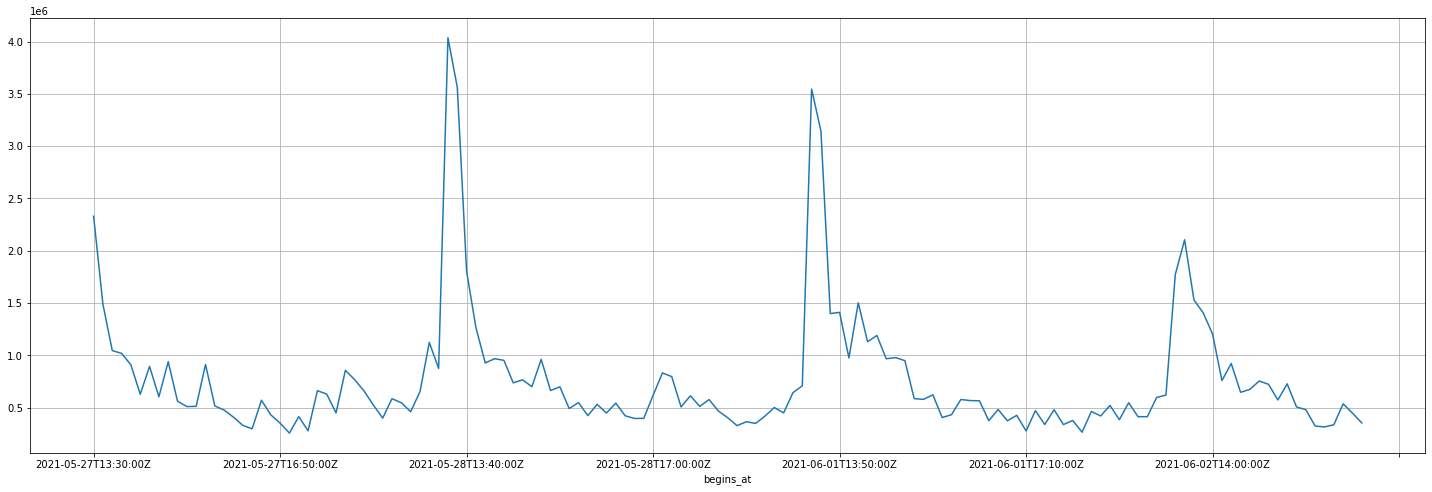

In [288]:
df.volume.plot(figsize=(25,8),grid=True)

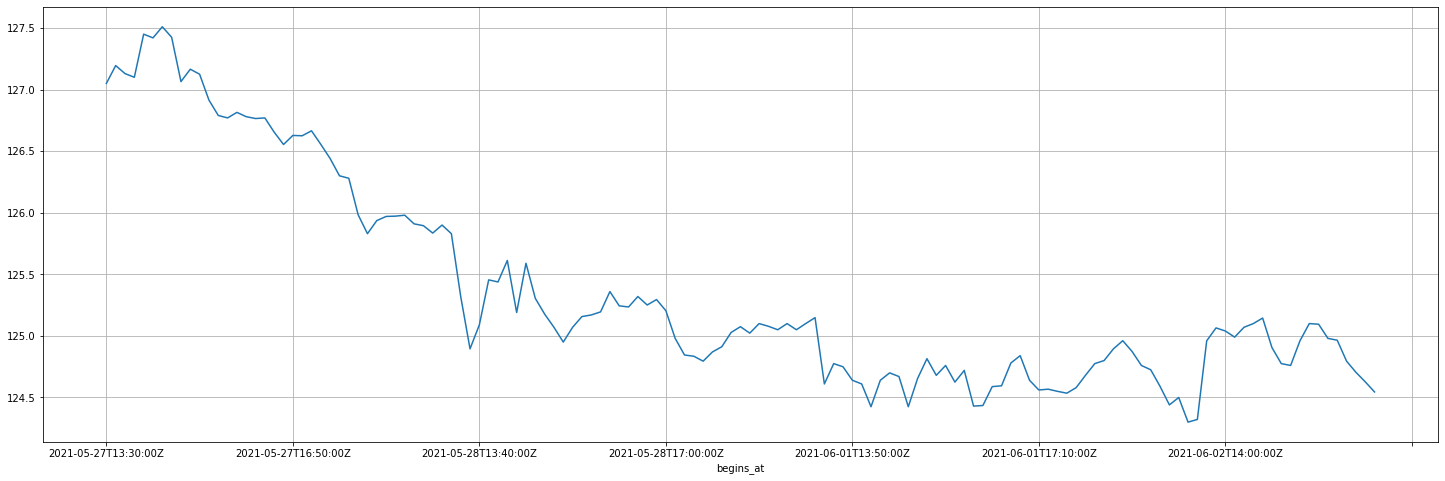

In [287]:
df.close_price.plot(figsize=(25,8),grid=True)
#df.volume.plot(figsize=(25,8),grid=True)

In [251]:
df.volume.quantile([0.1,0.25,0.5,0.95,1])

0.10     352996.0
0.25     430949.0
0.50     573128.0
0.95    1778958.2
1.00    4035739.0
Name: volume, dtype: float64

In [ ]:
r1 = rh.get_stock_historicals('aapl',interval='5min',span='week')
r2 = rh.get_stock_historicals('aapl',interval='hour',span='year')
r2 = rh.get_stock_historicals('aapl',interval='hour',span='month')

In [ ]:
r.get_current

In [23]:
r.export_completed_stock_orders(data_path)

In [6]:
r.logout()